In [1]:
import yt
import ytree
import numpy as np
import matplotlib.pyplot as plt
import json

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /home/dskinner6/.config/yt/ytrc is deprecated in favor of /home/dskinner6/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


In [2]:
yt.enable_plugins()

yt : [INFO     ] 2022-10-20 09:29:25,857 Loading plugins from /home/dskinner6/.config/yt/my_plugins.py


In [3]:
import matplotlib

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

In [4]:
run_dir = '../'

In [5]:
stars = ['p3_living', 'p3_binary', 'ns_binary', 'bh', 'p2', 'dm']
types = [5, 12, 13, 6, 7, 1]

In [6]:
with open('param_info.json') as f:
    param_info = json.load(f)
    
with open('run_DD_data.json') as f:
    DD_data = json.load(f)
    
with open('temp_run_info.json') as f:
    temp_run_info = json.load(f)
    
with open('halo_quantities.json') as f:
    halo_quantities = json.load(f)
    
with open('star_info.json') as f:
    star_info = json.load(f)

In [7]:
with open('massive_prog_info.json') as f:
    massive_prog = json.load(f)

In [8]:
run_names = list(DD_data.keys())

In [9]:
restart_ds = '0037'

In [10]:
## See if we can match the run_original merger tree until the restart redshift. 

merger_tree_match = {}

for run_name in run_names:
    merger_tree_match[run_name] = {}

In [10]:
#run_names = ['run_A']

potential_ds = {}
matching_ds = {}
for i in run_names:
    potential_ds[i] = []
    matching_ds[i] = []

In [11]:
## Finds the closest dataset in each run for each original dataset

for i, ds in enumerate(massive_prog):
    match_redshift = DD_data['run_original'][ds]['redshift']
    for run_name in run_names:
        if run_name != 'run_original':
            
            match_position = massive_prog[ds]['position']
            match_mass = massive_prog[ds]['mass']

            target_redshifts = np.array([DD_data[run_name][key]['redshift'] for key in DD_data[run_name].keys()])
            target_outputs = np.array([key for key in DD_data[run_name].keys()])
            
            diff = target_redshifts - match_redshift
            minimum = np.min(np.abs(diff))
            diff_index = np.argwhere(np.abs(diff) == np.min(minimum))[0][0]
            
            target_output = target_outputs[diff_index]
            potential_ds[run_name].append([ds, target_output])

In [12]:
## It's possible the timing will be off. I'm going to find the datasets that closely match the original dataset

for i, run_name in enumerate(run_names):
    for j, ds in enumerate(DD_data[run_name]):
        ds_list = []
        for matches in potential_ds[run_name]:
            if ds == matches[1]:
                ds_list.append(matches)
                
        if len(ds_list) == 1:
            matching_ds[run_name].append(ds_list[0])
        
        elif len(ds_list) > 1:
            original_ds = [o[0] for o in ds_list]
            original_redshifts = [DD_data['run_original'][o[0]]['redshift'] for o in ds_list]
            matching_redshift = DD_data[run_name][ds_list[0][1]]['redshift']
            
            diff = np.array(original_redshifts) - matching_redshift
            minimum = np.min(np.abs(diff))
            diff_index = np.argwhere(np.abs(diff) == np.min(minimum))[0][0]
            
            target_output = original_ds[diff_index]
            
            matching_ds[run_name].append([target_output, ds_list[0][1]])
        
        else:
            continue

In [13]:
matching_halo_info = {}
for key in matching_ds.keys():
    matching_halo_info[key] = {}

In [14]:
## Match the merger tree at the beginning up until the restart data set as close as possible 

b = ytree.load('../run_original' + '/rockstar_halos/trees/tree_0_0_0.dat')
output_images = '/home/dskinner6/localdata/SG64-2020/frontera_analysis/run_original/matching_halos/'

for i, run_name in enumerate(matching_ds):
    a = ytree.load('../' + run_name + '/rockstar_halos/trees/tree_0_0_0.dat')
    for outputs in matching_ds[run_name]:
        print(outputs)
        original_output = outputs[0]
        matching_output = outputs[1]
        
        if int(matching_output) <= int(restart_ds):
            
            matching_redshift = DD_data[run_name][matching_output]['redshift']

            matching_halo_info[run_name][matching_output] = {}

            target_halo = massive_prog[original_output]['halo_id']
            target_mass = massive_prog[original_output]['mass']
            target_position = massive_prog[original_output]['position']
            target_rvir = massive_prog[original_output]['rvir']
            
            ## Plot the original
            
            print('Plotting the original')
            ds = yt.load('../' + run_name + '/DD' + original_output + '/output_' + original_output)
        
            #stars = ['p3', 'p2', 'p3_living']
            #for s in stars:
            #    ds.add_particle_filter(s)

            #halo_id = target_halo
            #halo_pos = ds.arr(target_position, 'unitary').to('kpc')
            #halo_rvir = ds.quan(target_rvir, 'unitary').to('kpc')
            #halo_mass = ds.quan(target_mass, 'Msun')

            #sp = ds.sphere(halo_pos, halo_rvir)

            #p3_indices = sp['p3', 'particle_index']
            #p3_test = sp['p3', 'particle_mass'].to('Msun')
            #p3_pos = sp['p3', 'particle_position'].to('kpc')
            #p2_pos = sp['p2', 'particle_position'].to('kpc')

            ## Replace with the central halo 

            #prj = yt.ProjectionPlot(ds, 'x', 'density', center = halo_pos, weight_field='density', width=(10, 'kpc'))
            #prj.annotate_sphere([0,0], halo_rvir, coord_system='plot')
            #for p3 in p3_pos:
            #    prj.annotate_marker(p3, plot_args={'color':'white'})
            #for p2 in p3_pos:
            #    prj.annotate_marker(p2, plot_args={'color':'black'})
            #prj.annotate_timestamp(corner='upper_left', redshift=True, draw_inset_box=True)
            #prj.save(output_images + original_output + '_matching_density.png')

            delta = 0.01
            criteria = "(tree['tree', 'redshift'] > " + str(matching_redshift - delta) + ") & (tree['tree', 'redshift'] < " + str(matching_redshift + delta) + ')'

            halos_original = list(b.select_halos(criteria))

            if len(halos_original) == 0:
                delta = 0.05
                criteria = "(tree['tree', 'redshift'] > " + str(matching_redshift - delta) + ") & (tree['tree', 'redshift'] < " + str(matching_redshift + delta) + ')'

                halos_original = list(b.select_halos(criteria))
                if len(halos_original) != 0:
                    print("You've got halos. Let's find the matching halo.")
                else:
                    print('Refine again!')

            else:
                print('Checking to find the matching halo.')

            ## Check to see if we found the matching halo in the original tree:
            original_positions = []
            original_masses = []
            original_ids = []
            for halo in halos_original:
                original_positions.append(halo['position'].to('unitary'))
                original_masses.append(halo['mass'])
                original_ids.append(halo['halo_id'])

            dr_position = np.sqrt(((np.array(original_positions) - target_position)**2).sum(1))
            dr_mass = np.abs(np.array(original_masses) - target_mass)

            min_pos_index = np.argwhere(dr_position == np.min(dr_position))[0][0]
            min_mass_index = np.argwhere(dr_mass == np.min(dr_mass))[0][0]

            if min_pos_index == min_mass_index:
                print('Found the matching halo! Halo ID #' + str(original_ids[min_pos_index]))
                original_redshift = halos_original[min_pos_index]['redshift']
                print(original_redshift)
            else:
                print(original_output)
                print('Cant find matching halo in original tree...')
                print('Must refine criteria.')


            halos = list(a.select_halos("(tree['tree', 'redshift'] == " + str(original_redshift) + ')'))

            if len(halos) == 0:
                halos = list(a.select_halos(criteria))

            positions = []
            masses = []
            ids = []
            rvirs = []
            for halo in halos:
                positions.append(halo['position'].to('unitary'))
                masses.append(halo['mass'])
                ids.append(halo['halo_id'])
                rvirs.append(halo['virial_radius'].to('unitary'))

            dr_position = np.sqrt(((np.array(positions) - target_position)**2).sum(1))
            dr_mass = np.abs(np.array(masses) - target_mass)

            min_pos_index = np.argwhere(dr_position == np.min(dr_position))[0][0]
            min_mass_index = [i[0] for i in np.argwhere(dr_mass == np.min(dr_mass))]

            if min_pos_index in min_mass_index:
                print('Found the matching halo! Halo ID #' + str(ids[min_pos_index]))
                redshift = halos[min_pos_index]['redshift']

                #matching_halo_info[run_name][matching_output]['halo_id'] = ids[min_pos_index]
                matching_halo_info[run_name][matching_output]['position'] = positions[min_pos_index].v.tolist()
                matching_halo_info[run_name][matching_output]['mass'] = masses[min_pos_index].v.tolist()
                matching_halo_info[run_name][matching_output]['rvir'] = rvirs[min_pos_index].v.tolist()

            else:
                print('Cant find matching halo in original tree...')
                print('Choosing closest halo that is of the same order mass')
                order_mass = int("{:e}".format(target_mass).split('e+')[1])
                mass_criteria  = (np.array(masses) > 10**(order_mass)) & (np.array(masses) < 9*10**(order_mass))

                index = np.argwhere(dr_position == np.min(dr_position))[0][0]

                #matching_halo_info[run_name][matching_output]['halo_id'] = ids[index]
                matching_halo_info[run_name][matching_output]['position'] = positions[index].v.tolist()
                matching_halo_info[run_name][matching_output]['mass'] = masses[index].v.tolist()
                matching_halo_info[run_name][matching_output]['rvir'] = rvirs[index].v.tolist()

            print('\n')
        else:
            continue
            

yt : [INFO     ] 2022-10-10 17:36:35,760 Parameters: current_time              = 22.745089719978
yt : [INFO     ] 2022-10-10 17:36:35,760 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:35,761 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:35,761 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:35,762 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:35,762 Parameters: current_redshift          = 26.205185090537
yt : [INFO     ] 2022-10-10 17:36:35,762 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:35,763 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:35,763 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-10-10 17:36:35,763 Parameters: hubble_constant           = 0.6766


Additional features and improved performance (usually) by saving this arbor with "save_arbor" and reloading:
	>>> a = ytree.load("../run_original/rockstar_halos/trees/tree_0_0_0.dat")
	>>> fn = a.save_arbor()
	>>> a = ytree.load(fn)
['0025', '0025']
Plotting the original


Selecting halos (found 3): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 780.50it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #3
26.203484


Selecting halos (found 21): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 1061.99it/s]
yt : [INFO     ] 2022-10-10 17:36:36,690 Parameters: current_time              = 23.622229746859
yt : [INFO     ] 2022-10-10 17:36:36,691 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:36,692 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:36,692 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:36,692 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:36,693 Parameters: current_redshift          = 25.527466803273
yt : [INFO     ] 2022-10-10 17:36:36,693 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:36,693 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:36,693 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0026', '0026']
Plotting the original


Selecting halos (found 5): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 671.83it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #4
25.525198


Selecting halos (found 27): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 1134.44it/s]
yt : [INFO     ] 2022-10-10 17:36:37,642 Parameters: current_time              = 24.499369773757
yt : [INFO     ] 2022-10-10 17:36:37,643 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:37,644 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:37,644 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:37,645 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:37,645 Parameters: current_redshift          = 24.890434060978
yt : [INFO     ] 2022-10-10 17:36:37,645 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:37,645 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:37,646 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0027', '0027']
Plotting the original


Selecting halos (found 9): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 819.38it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #3
24.89332


Selecting halos (found 38): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 907.81it/s]
yt : [INFO     ] 2022-10-10 17:36:38,642 Parameters: current_time              = 25.376509800672
yt : [INFO     ] 2022-10-10 17:36:38,643 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:38,643 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:38,644 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:38,644 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:38,645 Parameters: current_redshift          = 24.290314607147
yt : [INFO     ] 2022-10-10 17:36:38,645 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:38,645 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:38,645 Parameters: omega_radiation          

Found the matching halo! Halo ID #12


['0028', '0028']
Plotting the original


Selecting halos (found 14): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 861.55it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #6
24.290844


Selecting halos (found 52): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 1139.81it/s]
yt : [INFO     ] 2022-10-10 17:36:39,552 Parameters: current_time              = 26.253649827605
yt : [INFO     ] 2022-10-10 17:36:39,553 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:39,554 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:39,554 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:39,555 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:39,555 Parameters: current_redshift          = 23.723800913527
yt : [INFO     ] 2022-10-10 17:36:39,555 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:39,555 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:39,556 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0029', '0029']
Plotting the original


Selecting halos (found 17): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 636.21it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #6
23.72188


Selecting halos (found 60): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 1135.71it/s]
yt : [INFO     ] 2022-10-10 17:36:40,543 Parameters: current_time              = 27.130789854557
yt : [INFO     ] 2022-10-10 17:36:40,544 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:40,545 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:40,545 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:40,546 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:40,546 Parameters: current_redshift          = 23.187979466477
yt : [INFO     ] 2022-10-10 17:36:40,546 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:40,546 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:40,546 Parameters: omega_radiation          

Found the matching halo! Halo ID #20


['0030', '0030']
Plotting the original


Selecting halos (found 23): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 851.33it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #5
23.189646


Selecting halos (found 73): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 869.92it/s]
yt : [INFO     ] 2022-10-10 17:36:41,619 Parameters: current_time              = 28.007929881528
yt : [INFO     ] 2022-10-10 17:36:41,620 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:41,621 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:41,622 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:41,622 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:41,623 Parameters: current_redshift          = 22.680273538569
yt : [INFO     ] 2022-10-10 17:36:41,623 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:41,623 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:41,624 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0031', '0031']
Plotting the original


Selecting halos (found 24): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 805.21it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #65
22.67985


Selecting halos (found 82): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 1117.64it/s]
yt : [INFO     ] 2022-10-10 17:36:42,613 Parameters: current_time              = 28.88506990852
yt : [INFO     ] 2022-10-10 17:36:42,614 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:42,615 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:42,616 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:42,616 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:42,617 Parameters: current_redshift          = 22.198394426362
yt : [INFO     ] 2022-10-10 17:36:42,617 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:42,617 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:42,617 Parameters: omega_radiation           

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0032', '0032']
Plotting the original


Selecting halos (found 26): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 671.92it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #8
22.196474


Selecting halos (found 103): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 925.18it/s]
yt : [INFO     ] 2022-10-10 17:36:43,695 Parameters: current_time              = 29.762228456744
yt : [INFO     ] 2022-10-10 17:36:43,695 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:43,696 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:43,697 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:43,697 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:43,697 Parameters: current_redshift          = 21.740292874543
yt : [INFO     ] 2022-10-10 17:36:43,697 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:43,697 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:43,698 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0033', '0033']
Plotting the original


Selecting halos (found 35): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 796.11it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #25
21.742779


Selecting halos (found 119): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 1085.85it/s]
yt : [INFO     ] 2022-10-10 17:36:44,673 Parameters: current_time              = 30.639372963722
yt : [INFO     ] 2022-10-10 17:36:44,674 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:44,674 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:44,675 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:44,675 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:44,676 Parameters: current_redshift          = 21.304161014959
yt : [INFO     ] 2022-10-10 17:36:44,676 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:44,676 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:44,676 Parameters: omega_radiation          

Found the matching halo! Halo ID #41


['0034', '0034']
Plotting the original


Selecting halos (found 45): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 845.57it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #17
21.301516


Selecting halos (found 135): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 767.91it/s]
yt : [INFO     ] 2022-10-10 17:36:45,881 Parameters: current_time              = 31.516513789274
yt : [INFO     ] 2022-10-10 17:36:45,882 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:45,882 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:45,883 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:45,884 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:45,884 Parameters: current_redshift          = 20.88835557169
yt : [INFO     ] 2022-10-10 17:36:45,884 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:45,884 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:45,885 Parameters: omega_radiation           

Found the matching halo! Halo ID #44


['0035', '0035']
Plotting the original


Selecting halos (found 48): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 714.63it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #14
20.886627


Selecting halos (found 147): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 1005.94it/s]
yt : [INFO     ] 2022-10-10 17:36:47,005 Parameters: current_time              = 32.393617277821
yt : [INFO     ] 2022-10-10 17:36:47,005 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:47,006 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:47,006 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:47,007 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:47,007 Parameters: current_redshift          = 20.491416656862
yt : [INFO     ] 2022-10-10 17:36:47,007 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:47,007 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:47,008 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0036', '0036']
Plotting the original


Selecting halos (found 50): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 592.37it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #4
20.49151


Selecting halos (found 163): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 1033.04it/s]
yt : [INFO     ] 2022-10-10 17:36:48,140 Parameters: current_time              = 33.27075988951
yt : [INFO     ] 2022-10-10 17:36:48,141 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:48,141 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:48,142 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:48,142 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:48,142 Parameters: current_redshift          = 20.111978616284
yt : [INFO     ] 2022-10-10 17:36:48,142 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:48,143 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:48,143 Parameters: omega_radiation           

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0037', '0037']
Plotting the original


Selecting halos (found 52): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 827.21it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #29
20.110407


Selecting halos (found 180): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 733.08it/s]
yt : [INFO     ] 2022-10-10 17:36:49,425 Parameters: current_time              = 22.745089719978
yt : [INFO     ] 2022-10-10 17:36:49,426 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:49,427 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:49,427 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:49,428 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:49,428 Parameters: current_redshift          = 26.205185090537
yt : [INFO     ] 2022-10-10 17:36:49,428 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:49,428 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:49,429 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0039', '0038']
['0040', '0039']
['0041', '0040']
['0042', '0041']
['0043', '0042']
['0044', '0043']
['0045', '0044']
['0046', '0045']
['0047', '0046']
['0048', '0047']
['0049', '0048']
['0050', '0049']
['0051', '0050']
['0052', '0051']
['0053', '0052']
['0054', '0053']
['0055', '0054']
['0056', '0055']
['0057', '0056']
['0058', '0057']
['0059', '0058']
['0060', '0059']
['0061', '0060']
['0062', '0061']
['0063', '0062']
['0064', '0063']
['0065', '0064']
['0066', '0065']
['0067', '0066']
['0068', '0067']
['0069', '0068']
['0070', '0069']
['0071', '0070']
['0072', '0071']
['0073', '0072']
['0074', '0073']
['0075', '0074']
['0076', '0075']
['0077', '0076']
['0082', '0077']
['0087', '0078']
['0092', '0079']
['0097', '0080']
['0102', '0081']
['0107', '0082']
['0112', '0083']
['0117', '0084']
['0122', '0085']
['0125', '0086']
['0025', '0025']
Plotting the original


Selecting halos (found 3): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 832.04it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #3
26.203484


Selecting halos (found 22): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 812.70it/s]
yt : [INFO     ] 2022-10-10 17:36:50,499 Parameters: current_time              = 23.622229746859
yt : [INFO     ] 2022-10-10 17:36:50,500 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:50,500 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:50,501 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:50,501 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:50,501 Parameters: current_redshift          = 25.527466803273
yt : [INFO     ] 2022-10-10 17:36:50,502 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:50,502 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:50,502 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0026', '0026']
Plotting the original


Selecting halos (found 5): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 676.74it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #4
25.525198


Selecting halos (found 30): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 749.75it/s]
yt : [INFO     ] 2022-10-10 17:36:51,734 Parameters: current_time              = 24.499369773757
yt : [INFO     ] 2022-10-10 17:36:51,735 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:51,735 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:51,736 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:51,736 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:51,737 Parameters: current_redshift          = 24.890434060978
yt : [INFO     ] 2022-10-10 17:36:51,737 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:51,737 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:51,738 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0027', '0027']
Plotting the original


Selecting halos (found 9): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 647.59it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #3
24.89332


Selecting halos (found 43): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 913.85it/s]
yt : [INFO     ] 2022-10-10 17:36:52,847 Parameters: current_time              = 25.376509800672
yt : [INFO     ] 2022-10-10 17:36:52,848 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:52,848 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:52,849 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:52,850 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:52,850 Parameters: current_redshift          = 24.290314607147
yt : [INFO     ] 2022-10-10 17:36:52,850 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:52,850 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:52,851 Parameters: omega_radiation          

Found the matching halo! Halo ID #5


['0028', '0028']
Plotting the original


Selecting halos (found 14): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 662.62it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #6
24.290844


Selecting halos (found 54): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 777.66it/s]
yt : [INFO     ] 2022-10-10 17:36:53,999 Parameters: current_time              = 26.253649827605
yt : [INFO     ] 2022-10-10 17:36:53,999 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:54,000 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:54,000 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:54,001 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:54,001 Parameters: current_redshift          = 23.723800913527
yt : [INFO     ] 2022-10-10 17:36:54,001 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:54,001 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:54,002 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0029', '0029']
Plotting the original


Selecting halos (found 17): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 761.10it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #6
23.72188


Selecting halos (found 60): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 989.56it/s]
yt : [INFO     ] 2022-10-10 17:36:54,996 Parameters: current_time              = 27.130789854557
yt : [INFO     ] 2022-10-10 17:36:54,996 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:54,997 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:54,997 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:54,998 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:54,998 Parameters: current_redshift          = 23.187979466477
yt : [INFO     ] 2022-10-10 17:36:54,998 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:54,999 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:54,999 Parameters: omega_radiation          

Found the matching halo! Halo ID #20


['0030', '0030']
Plotting the original


Selecting halos (found 23): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 585.26it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #5
23.189646


Selecting halos (found 69): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 973.55it/s]
yt : [INFO     ] 2022-10-10 17:36:56,099 Parameters: current_time              = 28.007929881528
yt : [INFO     ] 2022-10-10 17:36:56,100 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:56,101 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:56,101 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:56,102 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:56,102 Parameters: current_redshift          = 22.680273538569
yt : [INFO     ] 2022-10-10 17:36:56,102 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:56,102 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:56,103 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0031', '0031']
Plotting the original


Selecting halos (found 24): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 842.59it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #65
22.67985


Selecting halos (found 83): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 844.62it/s]
yt : [INFO     ] 2022-10-10 17:36:57,142 Parameters: current_time              = 28.88506990852
yt : [INFO     ] 2022-10-10 17:36:57,142 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:57,143 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:57,143 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:57,144 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:57,144 Parameters: current_redshift          = 22.198394426362
yt : [INFO     ] 2022-10-10 17:36:57,144 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:57,145 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:57,145 Parameters: omega_radiation           

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0032', '0032']
Plotting the original


Selecting halos (found 26): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 836.64it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #8
22.196474


Selecting halos (found 103): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 892.88it/s]
yt : [INFO     ] 2022-10-10 17:36:58,176 Parameters: current_time              = 29.762228456744
yt : [INFO     ] 2022-10-10 17:36:58,177 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:58,177 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:58,178 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:58,178 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:58,178 Parameters: current_redshift          = 21.740292874543
yt : [INFO     ] 2022-10-10 17:36:58,179 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:58,179 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:58,179 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0033', '0033']
Plotting the original


Selecting halos (found 35): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 814.42it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #25
21.742779


Selecting halos (found 117): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 840.79it/s]
yt : [INFO     ] 2022-10-10 17:36:59,256 Parameters: current_time              = 30.639372963722
yt : [INFO     ] 2022-10-10 17:36:59,256 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:36:59,257 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:36:59,258 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:36:59,258 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:36:59,258 Parameters: current_redshift          = 21.304161014959
yt : [INFO     ] 2022-10-10 17:36:59,259 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:36:59,259 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:36:59,259 Parameters: omega_radiation          

Found the matching halo! Halo ID #41


['0034', '0034']
Plotting the original


Selecting halos (found 45): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 844.88it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #17
21.301516


Selecting halos (found 130): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 1026.96it/s]
yt : [INFO     ] 2022-10-10 17:37:00,242 Parameters: current_time              = 31.516513789274
yt : [INFO     ] 2022-10-10 17:37:00,243 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:00,243 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:00,244 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:00,244 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:00,244 Parameters: current_redshift          = 20.88835557169
yt : [INFO     ] 2022-10-10 17:37:00,244 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:00,245 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:00,245 Parameters: omega_radiation           

Found the matching halo! Halo ID #44


['0035', '0035']
Plotting the original


Selecting halos (found 48): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 843.13it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #14
20.886627


Selecting halos (found 141): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 776.46it/s]
yt : [INFO     ] 2022-10-10 17:37:01,376 Parameters: current_time              = 32.393617277821
yt : [INFO     ] 2022-10-10 17:37:01,377 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:01,378 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:01,378 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:01,379 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:01,379 Parameters: current_redshift          = 20.491416656862
yt : [INFO     ] 2022-10-10 17:37:01,379 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:01,380 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:01,380 Parameters: omega_radiation          

Found the matching halo! Halo ID #50


['0036', '0036']
Plotting the original


Selecting halos (found 50): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 771.43it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #4
20.49151


Selecting halos (found 159): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 951.92it/s]
yt : [INFO     ] 2022-10-10 17:37:02,498 Parameters: current_time              = 33.27075988951
yt : [INFO     ] 2022-10-10 17:37:02,498 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:02,499 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:02,499 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:02,500 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:02,500 Parameters: current_redshift          = 20.111978616284
yt : [INFO     ] 2022-10-10 17:37:02,500 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:02,500 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:02,501 Parameters: omega_radiation           

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0037', '0037']
Plotting the original


Selecting halos (found 52): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 563.25it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #29
20.110407


Selecting halos (found 176): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 992.22it/s]
yt : [INFO     ] 2022-10-10 17:37:03,698 Parameters: current_time              = 22.745089719978
yt : [INFO     ] 2022-10-10 17:37:03,698 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:03,699 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:03,699 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:03,700 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:03,700 Parameters: current_redshift          = 26.205185090537
yt : [INFO     ] 2022-10-10 17:37:03,700 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:03,700 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:03,701 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0039', '0038']
['0040', '0039']
['0041', '0040']
['0042', '0041']
['0043', '0042']
['0044', '0043']
['0045', '0044']
['0046', '0045']
['0047', '0046']
['0048', '0047']
['0049', '0048']
['0050', '0049']
['0051', '0050']
['0052', '0051']
['0053', '0052']
['0054', '0053']
['0055', '0054']
['0056', '0055']
['0057', '0056']
['0058', '0057']
['0059', '0058']
['0060', '0059']
['0061', '0060']
['0062', '0061']
['0063', '0062']
['0064', '0063']
['0065', '0064']
['0066', '0065']
['0067', '0066']
['0068', '0067']
['0069', '0068']
['0070', '0069']
['0071', '0070']
['0072', '0071']
['0073', '0072']
['0074', '0073']
['0075', '0074']
['0076', '0075']
['0077', '0076']
['0082', '0077']
['0087', '0078']
['0092', '0079']
['0097', '0080']
['0102', '0081']
['0107', '0082']
['0112', '0083']
['0117', '0084']
['0122', '0085']
['0125', '0086']
['0025', '0025']
Plotting the original


Selecting halos (found 3): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 867.18it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #3
26.203484


Selecting halos (found 22): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 720.57it/s]
yt : [INFO     ] 2022-10-10 17:37:04,795 Parameters: current_time              = 23.622229746859
yt : [INFO     ] 2022-10-10 17:37:04,795 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:04,796 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:04,796 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:04,797 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:04,797 Parameters: current_redshift          = 25.527466803273
yt : [INFO     ] 2022-10-10 17:37:04,797 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:04,798 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:04,798 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0026', '0026']
Plotting the original


Selecting halos (found 5): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 864.08it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #4
25.525198


Selecting halos (found 30): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 1037.94it/s]
yt : [INFO     ] 2022-10-10 17:37:05,718 Parameters: current_time              = 24.499369773757
yt : [INFO     ] 2022-10-10 17:37:05,719 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:05,719 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:05,720 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:05,720 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:05,721 Parameters: current_redshift          = 24.890434060978
yt : [INFO     ] 2022-10-10 17:37:05,721 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:05,721 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:05,721 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0027', '0027']
Plotting the original


Selecting halos (found 9): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 804.06it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #3
24.89332


Selecting halos (found 41): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 835.45it/s]
yt : [INFO     ] 2022-10-10 17:37:06,755 Parameters: current_time              = 25.376509800672
yt : [INFO     ] 2022-10-10 17:37:06,755 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:06,756 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:06,756 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:06,757 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:06,757 Parameters: current_redshift          = 24.290314607147
yt : [INFO     ] 2022-10-10 17:37:06,757 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:06,757 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:06,758 Parameters: omega_radiation          

Found the matching halo! Halo ID #12


['0028', '0028']
Plotting the original


Selecting halos (found 14): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 827.31it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #6
24.290844


Selecting halos (found 53): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 1081.67it/s]
yt : [INFO     ] 2022-10-10 17:37:07,685 Parameters: current_time              = 26.253649827605
yt : [INFO     ] 2022-10-10 17:37:07,685 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:07,686 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:07,687 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:07,687 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:07,687 Parameters: current_redshift          = 23.723800913527
yt : [INFO     ] 2022-10-10 17:37:07,688 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:07,688 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:07,688 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0029', '0029']
Plotting the original


Selecting halos (found 17): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 853.66it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #6
23.72188


Selecting halos (found 59): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 865.54it/s]
yt : [INFO     ] 2022-10-10 17:37:08,707 Parameters: current_time              = 27.130789854557
yt : [INFO     ] 2022-10-10 17:37:08,708 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:08,709 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:08,709 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:08,709 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:08,710 Parameters: current_redshift          = 23.187979466477
yt : [INFO     ] 2022-10-10 17:37:08,710 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:08,710 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:08,710 Parameters: omega_radiation          

Found the matching halo! Halo ID #20


['0030', '0030']
Plotting the original


Selecting halos (found 23): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 810.00it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #5
23.189646


Selecting halos (found 73): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 1066.73it/s]
yt : [INFO     ] 2022-10-10 17:37:09,649 Parameters: current_time              = 28.007929881528
yt : [INFO     ] 2022-10-10 17:37:09,649 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:09,650 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:09,651 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:09,651 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:09,651 Parameters: current_redshift          = 22.680273538569
yt : [INFO     ] 2022-10-10 17:37:09,652 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:09,652 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:09,652 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0031', '0031']
Plotting the original


Selecting halos (found 24): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 587.08it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #65
22.67985


Selecting halos (found 83): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 1045.97it/s]
yt : [INFO     ] 2022-10-10 17:37:10,740 Parameters: current_time              = 28.88506990852
yt : [INFO     ] 2022-10-10 17:37:10,741 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:10,742 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:10,743 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:10,743 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:10,744 Parameters: current_redshift          = 22.198394426362
yt : [INFO     ] 2022-10-10 17:37:10,744 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:10,744 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:10,744 Parameters: omega_radiation           

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0032', '0032']
Plotting the original


Selecting halos (found 26): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 681.00it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #8
22.196474


Selecting halos (found 101): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 730.24it/s]
yt : [INFO     ] 2022-10-10 17:37:11,956 Parameters: current_time              = 29.762228456744
yt : [INFO     ] 2022-10-10 17:37:11,956 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:11,957 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:11,958 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:11,958 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:11,958 Parameters: current_redshift          = 21.740292874543
yt : [INFO     ] 2022-10-10 17:37:11,958 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:11,959 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:11,959 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0033', '0033']
Plotting the original


Selecting halos (found 35): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 773.20it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #25
21.742779


Selecting halos (found 118): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 1055.22it/s]
yt : [INFO     ] 2022-10-10 17:37:12,924 Parameters: current_time              = 30.639372963722
yt : [INFO     ] 2022-10-10 17:37:12,924 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:12,925 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:12,926 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:12,926 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:12,926 Parameters: current_redshift          = 21.304161014959
yt : [INFO     ] 2022-10-10 17:37:12,927 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:12,927 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:12,927 Parameters: omega_radiation          

Found the matching halo! Halo ID #41


['0034', '0034']
Plotting the original


Selecting halos (found 45): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 808.23it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #17
21.301516


Selecting halos (found 136): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 697.54it/s]
yt : [INFO     ] 2022-10-10 17:37:14,172 Parameters: current_time              = 31.516513789274
yt : [INFO     ] 2022-10-10 17:37:14,173 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:14,174 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:14,174 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:14,175 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:14,175 Parameters: current_redshift          = 20.88835557169
yt : [INFO     ] 2022-10-10 17:37:14,175 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:14,175 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:14,175 Parameters: omega_radiation           

Found the matching halo! Halo ID #43


['0035', '0035']
Plotting the original


Selecting halos (found 48): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 688.65it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #14
20.886627


Selecting halos (found 149): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 986.72it/s]
yt : [INFO     ] 2022-10-10 17:37:15,230 Parameters: current_time              = 32.393617277821
yt : [INFO     ] 2022-10-10 17:37:15,231 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:15,231 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:15,232 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:15,232 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:15,233 Parameters: current_redshift          = 20.491416656862
yt : [INFO     ] 2022-10-10 17:37:15,233 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:15,233 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:15,233 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0036', '0036']
Plotting the original


Selecting halos (found 50): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 801.47it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #4
20.49151


Selecting halos (found 166): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 851.57it/s]
yt : [INFO     ] 2022-10-10 17:37:16,369 Parameters: current_time              = 33.27075988951
yt : [INFO     ] 2022-10-10 17:37:16,370 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:16,371 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:16,371 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:16,372 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:16,372 Parameters: current_redshift          = 20.111978616284
yt : [INFO     ] 2022-10-10 17:37:16,372 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:16,373 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:16,373 Parameters: omega_radiation           

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0037', '0037']
Plotting the original


Selecting halos (found 52): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 819.51it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #29
20.110407


Selecting halos (found 182): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 987.82it/s]
yt : [INFO     ] 2022-10-10 17:37:17,487 Parameters: current_time              = 22.745089719978
yt : [INFO     ] 2022-10-10 17:37:17,487 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:17,488 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:17,489 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:17,489 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:17,490 Parameters: current_redshift          = 26.205185090537
yt : [INFO     ] 2022-10-10 17:37:17,490 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:17,490 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:17,490 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0039', '0038']
['0040', '0039']
['0041', '0040']
['0042', '0041']
['0043', '0042']
['0044', '0043']
['0045', '0044']
['0046', '0045']
['0047', '0046']
['0048', '0047']
['0049', '0048']
['0050', '0049']
['0051', '0050']
['0052', '0051']
['0053', '0052']
['0054', '0053']
['0055', '0054']
['0056', '0055']
['0057', '0056']
['0058', '0057']
['0059', '0058']
['0060', '0059']
['0061', '0060']
['0062', '0061']
['0063', '0062']
['0064', '0063']
['0065', '0064']
['0066', '0065']
['0067', '0066']
['0068', '0067']
['0069', '0068']
['0070', '0069']
['0071', '0070']
['0072', '0071']
['0073', '0072']
['0074', '0073']
['0075', '0074']
['0076', '0075']
['0077', '0076']
['0082', '0077']
['0087', '0078']
['0092', '0079']
['0097', '0080']
['0102', '0081']
['0107', '0082']
['0112', '0083']
['0117', '0084']
['0122', '0085']
['0125', '0086']
['0025', '0025']
Plotting the original


Selecting halos (found 3): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 786.65it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #3
26.203484


Selecting halos (found 22): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 603.31it/s]
yt : [INFO     ] 2022-10-10 17:37:18,716 Parameters: current_time              = 23.622229746859
yt : [INFO     ] 2022-10-10 17:37:18,717 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:18,717 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:18,718 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:18,718 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:18,719 Parameters: current_redshift          = 25.527466803273
yt : [INFO     ] 2022-10-10 17:37:18,719 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:18,719 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:18,719 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0026', '0026']
Plotting the original


Selecting halos (found 5): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 738.64it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #4
25.525198


Selecting halos (found 29): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 1042.64it/s]
yt : [INFO     ] 2022-10-10 17:37:19,635 Parameters: current_time              = 24.499369773757
yt : [INFO     ] 2022-10-10 17:37:19,636 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:19,636 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:19,637 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:19,637 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:19,638 Parameters: current_redshift          = 24.890434060978
yt : [INFO     ] 2022-10-10 17:37:19,638 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:19,638 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:19,639 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0027', '0027']
Plotting the original


Selecting halos (found 9): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 496.17it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #3
24.89332


Selecting halos (found 39): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 972.32it/s]
yt : [INFO     ] 2022-10-10 17:37:20,722 Parameters: current_time              = 25.376509800672
yt : [INFO     ] 2022-10-10 17:37:20,722 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:20,723 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:20,723 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:20,724 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:20,724 Parameters: current_redshift          = 24.290314607147
yt : [INFO     ] 2022-10-10 17:37:20,724 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:20,724 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:20,724 Parameters: omega_radiation          

Found the matching halo! Halo ID #12


['0028', '0028']
Plotting the original


Selecting halos (found 14): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 819.70it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #6
24.290844


Selecting halos (found 53): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 726.36it/s]
yt : [INFO     ] 2022-10-10 17:37:21,864 Parameters: current_time              = 26.253649827605
yt : [INFO     ] 2022-10-10 17:37:21,865 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:21,866 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:21,867 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:21,867 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:21,868 Parameters: current_redshift          = 23.723800913527
yt : [INFO     ] 2022-10-10 17:37:21,868 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:21,868 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:21,869 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0029', '0029']
Plotting the original


Selecting halos (found 17): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 715.56it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #6
23.72188


Selecting halos (found 58): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 843.27it/s]
yt : [INFO     ] 2022-10-10 17:37:22,937 Parameters: current_time              = 27.130789854557
yt : [INFO     ] 2022-10-10 17:37:22,937 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:22,938 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:22,938 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:22,939 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:22,939 Parameters: current_redshift          = 23.187979466477
yt : [INFO     ] 2022-10-10 17:37:22,939 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:22,940 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:22,940 Parameters: omega_radiation          

Found the matching halo! Halo ID #21


['0030', '0030']
Plotting the original


Selecting halos (found 23): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 846.09it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #5
23.189646


Selecting halos (found 70): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 723.45it/s]
yt : [INFO     ] 2022-10-10 17:37:24,026 Parameters: current_time              = 28.007929881528
yt : [INFO     ] 2022-10-10 17:37:24,026 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:24,027 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:24,028 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:24,028 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:24,029 Parameters: current_redshift          = 22.680273538569
yt : [INFO     ] 2022-10-10 17:37:24,029 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:24,029 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:24,029 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0031', '0031']
Plotting the original


Selecting halos (found 24): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 841.50it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #65
22.67985


Selecting halos (found 82): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 1044.73it/s]
yt : [INFO     ] 2022-10-10 17:37:24,943 Parameters: current_time              = 28.88506990852
yt : [INFO     ] 2022-10-10 17:37:24,944 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:24,944 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:24,945 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:24,945 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:24,946 Parameters: current_redshift          = 22.198394426362
yt : [INFO     ] 2022-10-10 17:37:24,946 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:24,946 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:24,946 Parameters: omega_radiation           

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0032', '0032']
Plotting the original


Selecting halos (found 26): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 866.20it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #8
22.196474


Selecting halos (found 103): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 731.18it/s]
yt : [INFO     ] 2022-10-10 17:37:26,065 Parameters: current_time              = 29.762228456744
yt : [INFO     ] 2022-10-10 17:37:26,065 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:26,066 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:26,066 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:26,067 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:26,067 Parameters: current_redshift          = 21.740292874543
yt : [INFO     ] 2022-10-10 17:37:26,067 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:26,067 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:26,068 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0033', '0033']
Plotting the original


Selecting halos (found 35): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 775.78it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #25
21.742779


Selecting halos (found 120): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 977.65it/s]
yt : [INFO     ] 2022-10-10 17:37:27,065 Parameters: current_time              = 30.639372963722
yt : [INFO     ] 2022-10-10 17:37:27,066 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:27,066 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:27,067 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:27,067 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:27,067 Parameters: current_redshift          = 21.304161014959
yt : [INFO     ] 2022-10-10 17:37:27,068 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:27,068 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:27,068 Parameters: omega_radiation          

Found the matching halo! Halo ID #41


['0034', '0034']
Plotting the original


Selecting halos (found 45): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 559.07it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #17
21.301516


Selecting halos (found 136): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 1024.06it/s]
yt : [INFO     ] 2022-10-10 17:37:28,153 Parameters: current_time              = 31.516513789274
yt : [INFO     ] 2022-10-10 17:37:28,154 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:28,154 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:28,155 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:28,155 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:28,155 Parameters: current_redshift          = 20.88835557169
yt : [INFO     ] 2022-10-10 17:37:28,156 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:28,156 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:28,156 Parameters: omega_radiation           

Found the matching halo! Halo ID #43


['0035', '0035']
Plotting the original


Selecting halos (found 48): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 761.38it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #14
20.886627


Selecting halos (found 151): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 1012.01it/s]
yt : [INFO     ] 2022-10-10 17:37:29,140 Parameters: current_time              = 32.393617277821
yt : [INFO     ] 2022-10-10 17:37:29,140 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:29,141 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:29,142 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:29,142 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:29,143 Parameters: current_redshift          = 20.491416656862
yt : [INFO     ] 2022-10-10 17:37:29,143 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:29,143 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:29,144 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0036', '0036']
Plotting the original


Selecting halos (found 50): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 545.78it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #4
20.49151


Selecting halos (found 170): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 931.93it/s]
yt : [INFO     ] 2022-10-10 17:37:30,314 Parameters: current_time              = 33.27075988951
yt : [INFO     ] 2022-10-10 17:37:30,314 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:30,315 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:30,316 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:30,316 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:30,316 Parameters: current_redshift          = 20.111978616284
yt : [INFO     ] 2022-10-10 17:37:30,316 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:30,317 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:30,317 Parameters: omega_radiation           

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0037', '0037']
Plotting the original


Selecting halos (found 52): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 679.35it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #29
20.110407


Selecting halos (found 186): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 754.95it/s]
yt : [INFO     ] 2022-10-10 17:37:31,589 Parameters: current_time              = 22.745089719978
yt : [INFO     ] 2022-10-10 17:37:31,589 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:31,590 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:31,590 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:31,591 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:31,591 Parameters: current_redshift          = 26.205185090537
yt : [INFO     ] 2022-10-10 17:37:31,591 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:31,591 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:31,592 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0039', '0038']
['0040', '0039']
['0041', '0040']
['0042', '0041']
['0043', '0042']
['0044', '0043']
['0045', '0044']
['0046', '0045']
['0047', '0046']
['0048', '0047']
['0049', '0048']
['0050', '0049']
['0051', '0050']
['0052', '0051']
['0053', '0052']
['0054', '0053']
['0055', '0054']
['0056', '0055']
['0057', '0056']
['0058', '0057']
['0059', '0058']
['0060', '0059']
['0061', '0060']
['0062', '0061']
['0063', '0062']
['0064', '0063']
['0065', '0064']
['0066', '0065']
['0067', '0066']
['0068', '0067']
['0069', '0068']
['0070', '0069']
['0071', '0070']
['0072', '0071']
['0073', '0072']
['0074', '0073']
['0075', '0074']
['0076', '0075']
['0077', '0076']
['0082', '0077']
['0087', '0078']
['0092', '0079']
['0097', '0080']
['0102', '0081']
['0107', '0082']
['0112', '0083']
['0117', '0084']
['0122', '0085']
['0125', '0086']
['0025', '0025']
Plotting the original


Selecting halos (found 3): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 873.95it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #3
26.203484


Selecting halos (found 20): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 874.90it/s]
yt : [INFO     ] 2022-10-10 17:37:32,566 Parameters: current_time              = 23.622229746859
yt : [INFO     ] 2022-10-10 17:37:32,566 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:32,567 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:32,567 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:32,568 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:32,568 Parameters: current_redshift          = 25.527466803273
yt : [INFO     ] 2022-10-10 17:37:32,568 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:32,568 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:32,569 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0026', '0026']
Plotting the original


Selecting halos (found 5): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 783.61it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #4
25.525198


Selecting halos (found 27): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 846.58it/s]
yt : [INFO     ] 2022-10-10 17:37:33,577 Parameters: current_time              = 24.499369773757
yt : [INFO     ] 2022-10-10 17:37:33,578 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:33,578 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:33,579 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:33,579 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:33,580 Parameters: current_redshift          = 24.890434060978
yt : [INFO     ] 2022-10-10 17:37:33,580 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:33,580 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:33,580 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0027', '0027']
Plotting the original


Selecting halos (found 9): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 860.07it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #3
24.89332


Selecting halos (found 39): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 1085.63it/s]
yt : [INFO     ] 2022-10-10 17:37:34,462 Parameters: current_time              = 25.376509800672
yt : [INFO     ] 2022-10-10 17:37:34,462 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:34,463 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:34,463 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:34,464 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:34,464 Parameters: current_redshift          = 24.290314607147
yt : [INFO     ] 2022-10-10 17:37:34,464 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:34,464 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:34,465 Parameters: omega_radiation          

Found the matching halo! Halo ID #12


['0028', '0028']
Plotting the original


Selecting halos (found 14): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 844.50it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #6
24.290844


Selecting halos (found 54): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 829.37it/s]
yt : [INFO     ] 2022-10-10 17:37:35,488 Parameters: current_time              = 26.253649827605
yt : [INFO     ] 2022-10-10 17:37:35,488 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:35,489 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:35,489 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:35,490 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:35,490 Parameters: current_redshift          = 23.723800913527
yt : [INFO     ] 2022-10-10 17:37:35,490 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:35,490 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:35,490 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0029', '0029']
Plotting the original


Selecting halos (found 17): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 849.45it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #6
23.72188


Selecting halos (found 59): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 1044.50it/s]
yt : [INFO     ] 2022-10-10 17:37:36,412 Parameters: current_time              = 27.130789854557
yt : [INFO     ] 2022-10-10 17:37:36,412 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:36,413 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:36,413 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:36,414 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:36,414 Parameters: current_redshift          = 23.187979466477
yt : [INFO     ] 2022-10-10 17:37:36,414 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:36,414 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:36,415 Parameters: omega_radiation          

Found the matching halo! Halo ID #21


['0030', '0030']
Plotting the original


Selecting halos (found 23): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 552.97it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #5
23.189646


Selecting halos (found 71): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 1048.48it/s]
yt : [INFO     ] 2022-10-10 17:37:37,471 Parameters: current_time              = 28.007929881528
yt : [INFO     ] 2022-10-10 17:37:37,472 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:37,472 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:37,473 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:37,473 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:37,474 Parameters: current_redshift          = 22.680273538569
yt : [INFO     ] 2022-10-10 17:37:37,474 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:37,474 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:37,474 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0031', '0031']
Plotting the original


Selecting halos (found 24): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 804.64it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #65
22.67985


Selecting halos (found 82): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 828.87it/s]
yt : [INFO     ] 2022-10-10 17:37:38,510 Parameters: current_time              = 28.88506990852
yt : [INFO     ] 2022-10-10 17:37:38,511 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:38,511 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:38,512 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:38,512 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:38,513 Parameters: current_redshift          = 22.198394426362
yt : [INFO     ] 2022-10-10 17:37:38,513 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:38,513 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:38,513 Parameters: omega_radiation           

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0032', '0032']
Plotting the original


Selecting halos (found 26): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 844.25it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #8
22.196474


Selecting halos (found 104): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 1049.95it/s]
yt : [INFO     ] 2022-10-10 17:37:39,441 Parameters: current_time              = 29.762228456744
yt : [INFO     ] 2022-10-10 17:37:39,442 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:39,442 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:39,443 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:39,443 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:39,443 Parameters: current_redshift          = 21.740292874543
yt : [INFO     ] 2022-10-10 17:37:39,444 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:39,444 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:39,444 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0033', '0033']
Plotting the original


Selecting halos (found 35): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 827.70it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #25
21.742779


Selecting halos (found 115): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 729.63it/s]
yt : [INFO     ] 2022-10-10 17:37:40,573 Parameters: current_time              = 30.639372963722
yt : [INFO     ] 2022-10-10 17:37:40,574 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:40,574 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:40,575 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:40,575 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:40,575 Parameters: current_redshift          = 21.304161014959
yt : [INFO     ] 2022-10-10 17:37:40,576 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:40,576 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:40,576 Parameters: omega_radiation          

Found the matching halo! Halo ID #41


['0034', '0034']
Plotting the original


Selecting halos (found 45): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 827.36it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #17
21.301516


Selecting halos (found 130): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 1051.88it/s]
yt : [INFO     ] 2022-10-10 17:37:41,535 Parameters: current_time              = 31.516513789274
yt : [INFO     ] 2022-10-10 17:37:41,535 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:41,536 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:41,536 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:41,537 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:41,537 Parameters: current_redshift          = 20.88835557169
yt : [INFO     ] 2022-10-10 17:37:41,537 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:41,538 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:41,538 Parameters: omega_radiation           

Found the matching halo! Halo ID #107


['0035', '0035']
Plotting the original


Selecting halos (found 48): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 806.02it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #14
20.886627


Selecting halos (found 144): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 789.30it/s]
yt : [INFO     ] 2022-10-10 17:37:42,662 Parameters: current_time              = 32.393617277821
yt : [INFO     ] 2022-10-10 17:37:42,662 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:42,663 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:42,663 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:42,664 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:42,664 Parameters: current_redshift          = 20.491416656862
yt : [INFO     ] 2022-10-10 17:37:42,664 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:42,665 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:42,665 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0036', '0036']
Plotting the original


Selecting halos (found 50): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 817.14it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #4
20.49151


Selecting halos (found 163): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 1054.55it/s]
yt : [INFO     ] 2022-10-10 17:37:43,799 Parameters: current_time              = 33.27075988951


Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0037', '0037']
Plotting the original


yt : [INFO     ] 2022-10-10 17:37:43,799 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:43,800 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:43,801 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:43,801 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:43,801 Parameters: current_redshift          = 20.111978616284
yt : [INFO     ] 2022-10-10 17:37:43,801 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:43,802 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:43,802 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-10-10 17:37:43,802 Parameters: hubble_constant           = 0.6766
Selecting halos (found 52): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 554.37it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #29
20.110407


Selecting halos (found 179): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 947.63it/s]
yt : [INFO     ] 2022-10-10 17:37:45,008 Parameters: current_time              = 22.745089719978
yt : [INFO     ] 2022-10-10 17:37:45,008 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:45,009 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:45,009 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:45,010 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:45,010 Parameters: current_redshift          = 26.205185090537
yt : [INFO     ] 2022-10-10 17:37:45,010 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:45,010 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:45,011 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0039', '0038']
['0040', '0039']
['0041', '0040']
['0042', '0041']
['0043', '0042']
['0044', '0043']
['0045', '0044']
['0046', '0045']
['0047', '0046']
['0048', '0047']
['0049', '0048']
['0050', '0049']
['0051', '0050']
['0052', '0051']
['0053', '0052']
['0054', '0053']
['0055', '0054']
['0056', '0055']
['0057', '0056']
['0058', '0057']
['0059', '0058']
['0060', '0059']
['0061', '0060']
['0062', '0061']
['0063', '0062']
['0064', '0063']
['0065', '0064']
['0066', '0065']
['0067', '0066']
['0068', '0067']
['0069', '0068']
['0070', '0069']
['0071', '0070']
['0072', '0071']
['0073', '0072']
['0074', '0073']
['0075', '0074']
['0076', '0075']
['0077', '0076']
['0082', '0077']
['0087', '0078']
['0092', '0079']
['0097', '0080']
['0102', '0081']
['0107', '0082']
['0112', '0083']
['0117', '0084']
['0122', '0085']
['0125', '0086']
['0025', '0025']
Plotting the original


Selecting halos (found 3): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 837.14it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #3
26.203484


Selecting halos (found 22): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 723.43it/s]
yt : [INFO     ] 2022-10-10 17:37:46,089 Parameters: current_time              = 23.622229746859
yt : [INFO     ] 2022-10-10 17:37:46,090 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:46,091 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:46,091 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:46,092 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:46,092 Parameters: current_redshift          = 25.527466803273
yt : [INFO     ] 2022-10-10 17:37:46,092 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:46,093 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:46,093 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0026', '0026']
Plotting the original


Selecting halos (found 5): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 860.97it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #4
25.525198


Selecting halos (found 29): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1077.05it/s]
yt : [INFO     ] 2022-10-10 17:37:46,959 Parameters: current_time              = 24.499369773757
yt : [INFO     ] 2022-10-10 17:37:46,959 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:46,960 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:46,961 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:46,961 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:46,961 Parameters: current_redshift          = 24.890434060978
yt : [INFO     ] 2022-10-10 17:37:46,962 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:46,962 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:46,962 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0027', '0027']
Plotting the original


Selecting halos (found 9): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 847.75it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #3
24.89332


Selecting halos (found 40): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 831.60it/s]
yt : [INFO     ] 2022-10-10 17:37:47,958 Parameters: current_time              = 25.376509800672
yt : [INFO     ] 2022-10-10 17:37:47,958 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:47,959 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:47,959 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:47,960 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:47,960 Parameters: current_redshift          = 24.290314607147
yt : [INFO     ] 2022-10-10 17:37:47,960 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:47,960 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:47,961 Parameters: omega_radiation          

Found the matching halo! Halo ID #11


['0028', '0028']
Plotting the original


Selecting halos (found 14): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 828.02it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #6
24.290844


Selecting halos (found 54): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1062.95it/s]
yt : [INFO     ] 2022-10-10 17:37:48,863 Parameters: current_time              = 26.253649827605
yt : [INFO     ] 2022-10-10 17:37:48,864 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:48,864 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:48,865 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:48,865 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:48,865 Parameters: current_redshift          = 23.723800913527
yt : [INFO     ] 2022-10-10 17:37:48,866 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:48,866 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:48,866 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0029', '0029']
Plotting the original


Selecting halos (found 17): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 858.16it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #6
23.72188


Selecting halos (found 60): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 777.76it/s]
yt : [INFO     ] 2022-10-10 17:37:49,913 Parameters: current_time              = 27.130789854557
yt : [INFO     ] 2022-10-10 17:37:49,913 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:49,914 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:49,915 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:49,915 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:49,915 Parameters: current_redshift          = 23.187979466477
yt : [INFO     ] 2022-10-10 17:37:49,915 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:49,916 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:49,916 Parameters: omega_radiation          

Found the matching halo! Halo ID #20


['0030', '0030']
Plotting the original


Selecting halos (found 23): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 830.71it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #5
23.189646


Selecting halos (found 74): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1012.31it/s]
yt : [INFO     ] 2022-10-10 17:37:50,854 Parameters: current_time              = 28.007929881528
yt : [INFO     ] 2022-10-10 17:37:50,855 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:50,855 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:50,856 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:50,857 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:50,857 Parameters: current_redshift          = 22.680273538569
yt : [INFO     ] 2022-10-10 17:37:50,857 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:50,858 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:50,858 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0031', '0031']
Plotting the original


Selecting halos (found 24): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 531.61it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #65
22.67985


Selecting halos (found 84): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 999.22it/s]
yt : [INFO     ] 2022-10-10 17:37:51,951 Parameters: current_time              = 28.88506990852
yt : [INFO     ] 2022-10-10 17:37:51,951 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:51,952 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:51,953 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:51,953 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:51,953 Parameters: current_redshift          = 22.198394426362
yt : [INFO     ] 2022-10-10 17:37:51,953 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:51,954 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:51,954 Parameters: omega_radiation           

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0032', '0032']
Plotting the original


Selecting halos (found 26): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 823.48it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #8
22.196474


Selecting halos (found 100): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1013.60it/s]
yt : [INFO     ] 2022-10-10 17:37:52,905 Parameters: current_time              = 29.762228456744
yt : [INFO     ] 2022-10-10 17:37:52,906 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:52,907 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:52,907 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:52,908 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:52,908 Parameters: current_redshift          = 21.740292874543
yt : [INFO     ] 2022-10-10 17:37:52,908 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:52,909 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:52,909 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0033', '0033']
Plotting the original


Selecting halos (found 35): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 576.10it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #25
21.742779


Selecting halos (found 114): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1045.18it/s]
yt : [INFO     ] 2022-10-10 17:37:53,951 Parameters: current_time              = 30.639372963722
yt : [INFO     ] 2022-10-10 17:37:53,952 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:53,953 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:53,953 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:53,954 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:53,954 Parameters: current_redshift          = 21.304161014959
yt : [INFO     ] 2022-10-10 17:37:53,954 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:53,955 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:53,955 Parameters: omega_radiation          

Found the matching halo! Halo ID #42


['0034', '0034']
Plotting the original


Selecting halos (found 45): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 776.12it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #17
21.301516


Selecting halos (found 129): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 801.02it/s]
yt : [INFO     ] 2022-10-10 17:37:55,057 Parameters: current_time              = 31.516513789274
yt : [INFO     ] 2022-10-10 17:37:55,057 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:55,058 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:55,058 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:55,059 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:55,059 Parameters: current_redshift          = 20.88835557169
yt : [INFO     ] 2022-10-10 17:37:55,059 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:55,060 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:55,060 Parameters: omega_radiation           

Found the matching halo! Halo ID #43


['0035', '0035']
Plotting the original


Selecting halos (found 48): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 818.04it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #14
20.886627


Selecting halos (found 141): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 971.77it/s]
yt : [INFO     ] 2022-10-10 17:37:56,059 Parameters: current_time              = 32.393617277821
yt : [INFO     ] 2022-10-10 17:37:56,060 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:56,060 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:56,061 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:56,061 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:56,062 Parameters: current_redshift          = 20.491416656862
yt : [INFO     ] 2022-10-10 17:37:56,062 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:56,062 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:56,062 Parameters: omega_radiation          

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0036', '0036']
Plotting the original


Selecting halos (found 50): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 834.66it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #4
20.49151


Selecting halos (found 157): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 802.19it/s]
yt : [INFO     ] 2022-10-10 17:37:57,168 Parameters: current_time              = 33.27075988951
yt : [INFO     ] 2022-10-10 17:37:57,169 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:37:57,169 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:37:57,170 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:37:57,170 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:37:57,171 Parameters: current_redshift          = 20.111978616284
yt : [INFO     ] 2022-10-10 17:37:57,171 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:37:57,171 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:37:57,171 Parameters: omega_radiation           

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0037', '0037']
Plotting the original


Selecting halos (found 52): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 791.67it/s]


Checking to find the matching halo.
Found the matching halo! Halo ID #29
20.110407


Selecting halos (found 172): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 990.03it/s]


Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


['0039', '0038']
['0040', '0039']
['0041', '0040']
['0042', '0041']
['0043', '0042']
['0044', '0043']
['0045', '0044']
['0046', '0045']
['0047', '0046']
['0048', '0047']
['0049', '0048']
['0050', '0049']
['0051', '0050']
['0052', '0051']
['0053', '0052']
['0054', '0053']
['0055', '0054']
['0056', '0055']
['0057', '0056']
['0058', '0057']
['0059', '0058']
['0060', '0059']
['0061', '0060']
['0062', '0061']
['0063', '0062']
['0064', '0063']
['0065', '0064']
['0066', '0065']
['0067', '0066']
['0068', '0067']
['0069', '0068']
['0070', '0069']
['0071', '0070']
['0072', '0071']
['0073', '0072']
['0074', '0073']
['0075', '0074']
['0076', '0075']
['0077', '0076']
['0082', '0077']
['0087', '0078']
['0092', '0079']
['0097', '0080']
['0102', '0081']
['0107', '0082']
['0112', '0083']
['0117', '0084']
['0122', '0085']
['0125', '0086']


In [168]:
## Plotting the halos

for i, run_name in enumerate(matching_halo_info):
    output_images = run_name + '/matching_halos/'
    for j, o in enumerate(matching_halo_info[run_name]):
        
        ds = yt.load('../' + run_name + '/DD' + o + '/output_' + o)
        
        stars = ['p3', 'p2', 'p3_living']
        for s in stars:
            ds.add_particle_filter(s)
        
        halo_id = matching_halo_info[run_name][o]['halo_id']
        halo_pos = ds.arr(matching_halo_info[run_name][o]['position'], 'unitary').to('kpc')
        halo_rvir = ds.quan(matching_halo_info[run_name][o]['rvir'], 'unitary').to('kpc')
        halo_mass = ds.quan(matching_halo_info[run_name][o]['mass'], 'Msun')

        sp = ds.sphere(halo_pos, halo_rvir)

        p3_indices = sp['p3', 'particle_index']
        p3_test = sp['p3', 'particle_mass'].to('Msun')
        p3_pos = sp['p3', 'particle_position'].to('kpc')
        p2_pos = sp['p2', 'particle_position'].to('kpc')

        ## Replace with the central halo 

        prj = yt.ProjectionPlot(ds, 'x', 'density', center = halo_pos, weight_field='density', width=(10, 'kpc'))
        prj.annotate_sphere([0,0], halo_rvir, coord_system='plot')
        for p3 in p3_pos:
            prj.annotate_marker(p3, plot_args={'color':'white'})
        for p2 in p3_pos:
            prj.annotate_marker(p2, plot_args={'color':'black'})
        prj.annotate_timestamp(corner='upper_left', redshift=True, draw_inset_box=True)
        prj.save(output_images + o + '_matching_density.png')

yt : [INFO     ] 2022-10-06 12:52:11,051 Parameters: current_time              = 22.745089719978
yt : [INFO     ] 2022-10-06 12:52:11,052 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-06 12:52:11,053 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-06 12:52:11,053 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-06 12:52:11,053 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-06 12:52:11,054 Parameters: current_redshift          = 26.205185090537
yt : [INFO     ] 2022-10-06 12:52:11,054 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-06 12:52:11,054 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-06 12:52:11,054 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-10-06 12:52:11,055 Parameters: hubble_constant           = 0.6766

Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'all', 'nbody', 'p2', 'p3', 'p3_living'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'all', 'nbody', 'p2', 'p3', 'p3_living'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


yt : [INFO     ] 2022-10-06 12:52:17,814 Projection completed
yt : [INFO     ] 2022-10-06 12:52:17,814 xlim = 17.175009 27.175009
yt : [INFO     ] 2022-10-06 12:52:17,815 ylim = 13.636255 23.636255
yt : [INFO     ] 2022-10-06 12:52:17,815 xlim = 0.444668 0.703573
yt : [INFO     ] 2022-10-06 12:52:17,815 ylim = 0.353049 0.611953
yt : [INFO     ] 2022-10-06 12:52:17,816 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2022-10-06 12:52:18,004 Saving plot run_A/matching_halos/0027_matching_density.png
yt : [INFO     ] 2022-10-06 12:52:18,230 Parameters: current_time              = 25.376509800672
yt : [INFO     ] 2022-10-06 12:52:18,231 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-06 12:52:18,231 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-06 12:52:18,232 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-06 12:52:18,232 Parameters: cosmological_simulation   = 1
yt : 

yt : [INFO     ] 2022-10-06 12:52:21,236 Parameters: hubble_constant           = 0.6766

Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:00<00:00, 17344.59it/s]
yt : [INFO     ] 2022-10-06 12:52:21,259 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'all', 'nbody', 'p2', 'p3', 'p3_living'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'all', 'nbody', 'p2', 'p3', 'p3_living'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


yt : [INFO     ] 2022-10-06 12:52:28,602 Projection completed
yt : [INFO     ] 2022-10-06 12:52:28,603 xlim = 17.447157 27.447157
yt : [INFO     ] 2022-10-06 12:52:28,603 ylim = 14.176668 24.176668
yt : [INFO     ] 2022-10-06 12:52:28,603 xlim = 0.413153 0.649956
yt : [INFO     ] 2022-10-06 12:52:28,604 ylim = 0.335707 0.572510
yt : [INFO     ] 2022-10-06 12:52:28,605 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2022-10-06 12:52:28,789 Saving plot run_A/matching_halos/0031_matching_density.png
yt : [INFO     ] 2022-10-06 12:52:29,044 Parameters: current_time              = 28.88506990852
yt : [INFO     ] 2022-10-06 12:52:29,045 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-06 12:52:29,046 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-06 12:52:29,046 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-06 12:52:29,047 Parameters: cosmological_simulation   = 1
yt : [

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'all', 'nbody', 'p2', 'p3', 'p3_living'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'all', 'nbody', 'p2', 'p3', 'p3_living'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


yt : [INFO     ] 2022-10-06 12:52:39,178 Projection completed
yt : [INFO     ] 2022-10-06 12:52:39,178 xlim = 19.266592 29.266592
yt : [INFO     ] 2022-10-06 12:52:39,179 ylim = 15.821543 25.821543
yt : [INFO     ] 2022-10-06 12:52:39,179 xlim = 0.421714 0.640598
yt : [INFO     ] 2022-10-06 12:52:39,179 ylim = 0.346308 0.565191
yt : [INFO     ] 2022-10-06 12:52:39,180 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2022-10-06 12:52:39,373 Saving plot run_A/matching_halos/0035_matching_density.png
yt : [INFO     ] 2022-10-06 12:52:39,618 Parameters: current_time              = 32.393617277821
yt : [INFO     ] 2022-10-06 12:52:39,619 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-06 12:52:39,619 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-06 12:52:39,620 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-06 12:52:39,620 Parameters: cosmological_simulation   = 1
yt : 

In [17]:
## After the restart output, we find the largest halo containing our star particle

particle_id = int(param_info['run_A']['id'])
output_images = '/home/dskinner6/localdata/SG64-2020/frontera_analysis/run_A/matching_halos/'

## Identify position of the particle --> see what halo it's in 

for i, run_name in enumerate(matching_halo_info):
    a = ytree.load('../' + run_name + '/rockstar_halos/trees/tree_0_0_0.dat')
    for j, o in enumerate(DD_data[run_name]):
        if int(o) > int(restart_ds):
            print(ds)
            ds = yt.load('../' + run_name + '/DD' + o + '/output_' + o)
            redshift = ds.current_redshift
            
            stars = ['p3', 'p2', 'p3_living']
            for s in stars:
                ds.add_particle_filter(s)
            
            ad = ds.all_data()
            
            particle_ids = ad['all', 'particle_index']
            particle_index = np.argwhere(particle_ids == particle_id)[0][0]
            particle_position = ad['all', 'particle_position'][particle_index].to('kpc')
            
            ## This works for now. Wonder about in the future... May have to find the closest redshift.
            delta = 0.01
            criteria = "(tree['tree', 'redshift'] > " + str(redshift - delta) + ") & (tree['tree', 'redshift'] < " + str(redshift + delta) + ')'

            halos_original = list(a.select_halos(criteria))
                
            halos_positions = []
            halos_rvirs = []
            halos_mass = []
            
            for halo in halos_original:
                halos_positions.append(ds.arr(halo['position'].to('unitary'), 'unitary').to('kpc'))
                halos_rvirs.append(ds.quan(halo['virial_radius'].to('unitary'), 'unitary').to('kpc'))
                halos_mass.append(halo['mass'])
            
            dr_position = np.sqrt(((halos_positions - particle_position)**2).sum(1))
            inside = dr_position < halos_rvirs
            
            halos_mass = np.array(halos_mass)[inside]
            halos_positions = np.array(halos_positions)[inside]
            halos_rvirs = np.array(halos_rvirs)[inside]
            
            massive_index = np.argwhere(halos_mass == np.max(halos_mass))[0][0]
            
            matching_halo_info[run_name][o] = {}
            matching_halo_info[run_name][o]['position'] = ds.arr(halos_positions[massive_index], 'kpc').to('unitary').v.tolist()
            matching_halo_info[run_name][o]['mass'] = halos_mass[massive_index].tolist()
            matching_halo_info[run_name][o]['rvir'] = ds.quan(halos_rvirs[massive_index], 'kpc').to('unitary').v.tolist()
            
            #halo_pos = ds.arr(matching_halo_info[run_name][o]['position'], 'unitary').to('kpc')
            #halo_rvir = ds.quan(matching_halo_info[run_name][o]['rvir'], 'unitary').to('kpc')
            #halo_mass = ds.quan(matching_halo_info[run_name][o]['mass'], 'Msun')
            #print(halo_pos)

            #sp = ds.sphere(halo_pos, halo_rvir)

            #p3_indices = sp['p3', 'particle_index']
            #p3_test = sp['p3', 'particle_mass'].to('Msun')
            #p3_pos = sp['p3', 'particle_position'].to('kpc')
            #p2_pos = sp['p2', 'particle_position'].to('kpc')

            ## Replace with the central halo 

            #prj = yt.ProjectionPlot(ds, 'x', 'density', center = halo_pos, weight_field='density', width=(10, 'kpc'))
            #prj.annotate_sphere([0,0], halo_rvir, coord_system='plot')
            #for p3 in p3_pos:
            #    prj.annotate_marker(p3, plot_args={'color':'white'})
            #for p2 in p3_pos:
            #    prj.annotate_marker(p2, plot_args={'color':'black'})
            #prj.annotate_timestamp(corner='upper_left', redshift=True, draw_inset_box=True)
            #prj.save(output_images + o + '_matching_density.png')

yt : [INFO     ] 2022-10-10 17:53:48,018 Parameters: current_time              = 34.147897283796
yt : [INFO     ] 2022-10-10 17:53:48,019 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:53:48,019 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:53:48,020 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:53:48,020 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:53:48,020 Parameters: current_redshift          = 19.748856524141
yt : [INFO     ] 2022-10-10 17:53:48,021 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 17:53:48,021 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 17:53:48,021 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-10-10 17:53:48,021 Parameters: hubble_constant           = 0.6766


output_0037


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:00<00:00, 3709.42it/s]
yt : [INFO     ] 2022-10-10 17:53:48,202 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'z' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

output_0038


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 612/612 [00:00<00:00, 20038.20it/s]
yt : [INFO     ] 2022-10-10 17:53:52,382 Gathering a field list (this may take a moment.)
Selecting halos (found 200): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 709.71it/s]
yt : [INFO     ] 2022-10-10 17:53:56,428 Parameters: current_time              = 35.902222481214
yt : [INFO     ] 2022-10-10 17:53:56,429 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:53:56,429 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:53:56,430 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:53:56,430 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:53:56,431 Parameters: current_redshif

output_0039


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 677/677 [00:00<00:00, 14594.02it/s]
yt : [INFO     ] 2022-10-10 17:53:56,501 Gathering a field list (this may take a moment.)
Selecting halos (found 216): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 778.82it/s]
yt : [INFO     ] 2022-10-10 17:54:00,502 Parameters: current_time              = 36.779365080144
yt : [INFO     ] 2022-10-10 17:54:00,503 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:54:00,504 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:54:00,504 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:54:00,505 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:54:00,505 Parameters: current_redshif

output_0040


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:00<00:00, 20236.20it/s]
yt : [INFO     ] 2022-10-10 17:54:00,557 Gathering a field list (this may take a moment.)
Selecting halos (found 229): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 987.07it/s]
yt : [INFO     ] 2022-10-10 17:54:04,681 Parameters: current_time              = 37.656507247322
yt : [INFO     ] 2022-10-10 17:54:04,682 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:54:04,682 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:54:04,683 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:54:04,683 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:54:04,684 Parameters: current_redshif

output_0041


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 711/711 [00:00<00:00, 3579.93it/s]
yt : [INFO     ] 2022-10-10 17:54:04,899 Gathering a field list (this may take a moment.)
Selecting halos (found 248): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 1014.15it/s]
yt : [INFO     ] 2022-10-10 17:54:08,903 Parameters: current_time              = 38.533641182594
yt : [INFO     ] 2022-10-10 17:54:08,904 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:54:08,904 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:54:08,905 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:54:08,906 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:54:08,906 Parameters: current_redshif

output_0042


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 716/716 [00:00<00:00, 3759.87it/s]
yt : [INFO     ] 2022-10-10 17:54:09,114 Gathering a field list (this may take a moment.)
Selecting halos (found 266): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 965.43it/s]
yt : [INFO     ] 2022-10-10 17:54:13,239 Parameters: current_time              = 39.410784698242
yt : [INFO     ] 2022-10-10 17:54:13,240 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:54:13,241 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:54:13,241 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:54:13,241 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:54:13,242 Parameters: current_redshif

output_0043


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 769/769 [00:00<00:00, 4077.99it/s]
yt : [INFO     ] 2022-10-10 17:54:13,449 Gathering a field list (this may take a moment.)
Selecting halos (found 287): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 984.01it/s]
yt : [INFO     ] 2022-10-10 17:54:17,858 Parameters: current_time              = 40.287926326965
yt : [INFO     ] 2022-10-10 17:54:17,859 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:54:17,859 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:54:17,860 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:54:17,860 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:54:17,861 Parameters: current_redshif

output_0044


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 797/797 [00:00<00:00, 4197.20it/s]
yt : [INFO     ] 2022-10-10 17:54:18,071 Gathering a field list (this may take a moment.)
Selecting halos (found 294): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 985.06it/s]
yt : [INFO     ] 2022-10-10 17:54:22,370 Parameters: current_time              = 41.165056935338
yt : [INFO     ] 2022-10-10 17:54:22,370 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:54:22,371 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:54:22,372 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:54:22,372 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:54:22,372 Parameters: current_redshif

output_0045


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 804/804 [00:00<00:00, 4234.87it/s]
yt : [INFO     ] 2022-10-10 17:54:22,582 Gathering a field list (this may take a moment.)
Selecting halos (found 312): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 963.74it/s]
yt : [INFO     ] 2022-10-10 17:54:26,869 Parameters: current_time              = 42.042198519707
yt : [INFO     ] 2022-10-10 17:54:26,870 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:54:26,870 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:54:26,871 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:54:26,872 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:54:26,872 Parameters: current_redshif

output_0046


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 835/835 [00:00<00:00, 20904.92it/s]
yt : [INFO     ] 2022-10-10 17:54:27,093 Gathering a field list (this may take a moment.)
Selecting halos (found 328): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 964.09it/s]
yt : [INFO     ] 2022-10-10 17:54:31,551 Parameters: current_time              = 42.919317688765
yt : [INFO     ] 2022-10-10 17:54:31,552 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:54:31,552 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:54:31,553 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:54:31,553 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:54:31,554 Parameters: current_redshif

output_0047


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 830/830 [00:00<00:00, 21200.64it/s]
yt : [INFO     ] 2022-10-10 17:54:31,617 Gathering a field list (this may take a moment.)
Selecting halos (found 337): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 980.65it/s]
yt : [INFO     ] 2022-10-10 17:54:36,143 Parameters: current_time              = 43.796501703069
yt : [INFO     ] 2022-10-10 17:54:36,143 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:54:36,144 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:54:36,145 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:54:36,145 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:54:36,146 Parameters: current_redshif

output_0048


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 857/857 [00:00<00:00, 20685.38it/s]
yt : [INFO     ] 2022-10-10 17:54:36,211 Gathering a field list (this may take a moment.)
Selecting halos (found 354): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 970.18it/s]
yt : [INFO     ] 2022-10-10 17:54:41,013 Parameters: current_time              = 44.673632439356
yt : [INFO     ] 2022-10-10 17:54:41,014 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:54:41,015 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:54:41,015 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:54:41,016 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:54:41,016 Parameters: current_redshif

output_0049


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 858/858 [00:00<00:00, 18671.33it/s]
yt : [INFO     ] 2022-10-10 17:54:41,084 Gathering a field list (this may take a moment.)
Selecting halos (found 365): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 969.64it/s]
yt : [INFO     ] 2022-10-10 17:54:45,734 Parameters: current_time              = 45.550757219002
yt : [INFO     ] 2022-10-10 17:54:45,735 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:54:45,736 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:54:45,736 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:54:45,737 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:54:45,737 Parameters: current_redshif

output_0050


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 857/857 [00:00<00:00, 20551.73it/s]
yt : [INFO     ] 2022-10-10 17:54:45,800 Gathering a field list (this may take a moment.)
Selecting halos (found 382): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 929.45it/s]
yt : [INFO     ] 2022-10-10 17:54:50,354 Parameters: current_time              = 46.42791015271
yt : [INFO     ] 2022-10-10 17:54:50,354 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:54:50,355 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:54:50,356 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:54:50,356 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:54:50,356 Parameters: current_redshift

output_0051


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 819/819 [00:00<00:00, 20524.20it/s]
yt : [INFO     ] 2022-10-10 17:54:50,418 Gathering a field list (this may take a moment.)
Selecting halos (found 396): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 942.91it/s]
yt : [INFO     ] 2022-10-10 17:54:55,263 Parameters: current_time              = 47.305048003957
yt : [INFO     ] 2022-10-10 17:54:55,264 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:54:55,264 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:54:55,265 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:54:55,265 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:54:55,266 Parameters: current_redshif

output_0052


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 881/881 [00:00<00:00, 20297.06it/s]
yt : [INFO     ] 2022-10-10 17:54:55,334 Gathering a field list (this may take a moment.)
Selecting halos (found 413): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 965.99it/s]
yt : [INFO     ] 2022-10-10 17:55:00,182 Parameters: current_time              = 48.182188956268
yt : [INFO     ] 2022-10-10 17:55:00,182 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:55:00,183 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:55:00,184 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:55:00,184 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:55:00,184 Parameters: current_redshif

output_0053


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 850/850 [00:00<00:00, 20181.47it/s]
yt : [INFO     ] 2022-10-10 17:55:00,248 Gathering a field list (this may take a moment.)
Selecting halos (found 425): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 878.33it/s]
yt : [INFO     ] 2022-10-10 17:55:05,025 Parameters: current_time              = 49.059326462703
yt : [INFO     ] 2022-10-10 17:55:05,025 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:55:05,026 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:55:05,026 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:55:05,027 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:55:05,027 Parameters: current_redshif

output_0054


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 881/881 [00:00<00:00, 20110.93it/s]
yt : [INFO     ] 2022-10-10 17:55:05,093 Gathering a field list (this may take a moment.)
Selecting halos (found 441): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 646.90it/s]
yt : [INFO     ] 2022-10-10 17:55:10,284 Parameters: current_time              = 49.936472195009
yt : [INFO     ] 2022-10-10 17:55:10,284 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:55:10,285 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:55:10,286 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:55:10,286 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:55:10,286 Parameters: current_redshif

output_0055


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 927/927 [00:00<00:00, 16744.70it/s]
yt : [INFO     ] 2022-10-10 17:55:10,365 Gathering a field list (this may take a moment.)
Selecting halos (found 446): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 643.85it/s]
yt : [INFO     ] 2022-10-10 17:55:15,236 Parameters: current_time              = 50.813602535072
yt : [INFO     ] 2022-10-10 17:55:15,236 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:55:15,237 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:55:15,237 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:55:15,238 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:55:15,238 Parameters: current_redshif

output_0056


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 927/927 [00:00<00:00, 19131.91it/s]
yt : [INFO     ] 2022-10-10 17:55:15,311 Gathering a field list (this may take a moment.)
Selecting halos (found 452): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 674.22it/s]
yt : [INFO     ] 2022-10-10 17:55:20,132 Parameters: current_time              = 51.690781096587
yt : [INFO     ] 2022-10-10 17:55:20,133 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:55:20,134 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:55:20,134 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:55:20,135 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:55:20,135 Parameters: current_redshif

output_0057


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 905/905 [00:00<00:00, 20316.45it/s]
yt : [INFO     ] 2022-10-10 17:55:20,204 Gathering a field list (this may take a moment.)
Selecting halos (found 466): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 652.69it/s]
yt : [INFO     ] 2022-10-10 17:55:25,111 Parameters: current_time              = 52.567918917626
yt : [INFO     ] 2022-10-10 17:55:25,112 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:55:25,113 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:55:25,113 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:55:25,113 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:55:25,114 Parameters: current_redshif

output_0058


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 883/883 [00:00<00:00, 19637.17it/s]
yt : [INFO     ] 2022-10-10 17:55:25,180 Gathering a field list (this may take a moment.)
Selecting halos (found 483): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 664.28it/s]
yt : [INFO     ] 2022-10-10 17:55:30,224 Parameters: current_time              = 53.445057397345
yt : [INFO     ] 2022-10-10 17:55:30,225 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:55:30,225 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:55:30,226 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:55:30,226 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:55:30,226 Parameters: current_redshif

output_0059


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 911/911 [00:00<00:00, 18870.59it/s]
yt : [INFO     ] 2022-10-10 17:55:30,297 Gathering a field list (this may take a moment.)
Selecting halos (found 500): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 643.32it/s]
yt : [INFO     ] 2022-10-10 17:55:35,181 Parameters: current_time              = 54.322172385914
yt : [INFO     ] 2022-10-10 17:55:35,182 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:55:35,183 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:55:35,183 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:55:35,183 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:55:35,184 Parameters: current_redshif

output_0060


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 930/930 [00:00<00:00, 18730.78it/s]
yt : [INFO     ] 2022-10-10 17:55:35,255 Gathering a field list (this may take a moment.)
Selecting halos (found 514): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 660.04it/s]
yt : [INFO     ] 2022-10-10 17:55:40,329 Parameters: current_time              = 55.199310856031
yt : [INFO     ] 2022-10-10 17:55:40,329 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:55:40,330 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:55:40,330 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:55:40,331 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:55:40,331 Parameters: current_redshif

output_0061


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 971/971 [00:00<00:00, 19469.04it/s]
yt : [INFO     ] 2022-10-10 17:55:40,404 Gathering a field list (this may take a moment.)
Selecting halos (found 527): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 667.82it/s]
yt : [INFO     ] 2022-10-10 17:55:45,668 Parameters: current_time              = 56.076448357646
yt : [INFO     ] 2022-10-10 17:55:45,669 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:55:45,669 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:55:45,670 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:55:45,670 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:55:45,670 Parameters: current_redshif

output_0062


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 978/978 [00:00<00:00, 20711.36it/s]
yt : [INFO     ] 2022-10-10 17:55:45,743 Gathering a field list (this may take a moment.)
Selecting halos (found 536): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 655.89it/s]
yt : [INFO     ] 2022-10-10 17:55:50,780 Parameters: current_time              = 56.953603017216
yt : [INFO     ] 2022-10-10 17:55:50,781 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:55:50,782 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:55:50,782 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:55:50,783 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:55:50,783 Parameters: current_redshif

output_0063


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 935/935 [00:00<00:00, 19793.44it/s]
yt : [INFO     ] 2022-10-10 17:55:50,854 Gathering a field list (this may take a moment.)
Selecting halos (found 551): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 884.17it/s]
yt : [INFO     ] 2022-10-10 17:55:55,629 Parameters: current_time              = 57.830752620857
yt : [INFO     ] 2022-10-10 17:55:55,630 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:55:55,631 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:55:55,631 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:55:55,632 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:55:55,632 Parameters: current_redshif

output_0064


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:00<00:00, 3539.32it/s]
yt : [INFO     ] 2022-10-10 17:55:55,919 Gathering a field list (this may take a moment.)
Selecting halos (found 561): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 883.28it/s]
yt : [INFO     ] 2022-10-10 17:56:00,780 Parameters: current_time              = 58.707888228515
yt : [INFO     ] 2022-10-10 17:56:00,781 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:56:00,782 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:56:00,782 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:56:00,783 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:56:00,783 Parameters: current_redshif

output_0065


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 970/970 [00:00<00:00, 3826.67it/s]
yt : [INFO     ] 2022-10-10 17:56:01,059 Gathering a field list (this may take a moment.)
Selecting halos (found 573): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 826.64it/s]
yt : [INFO     ] 2022-10-10 17:56:06,042 Parameters: current_time              = 59.585024238547
yt : [INFO     ] 2022-10-10 17:56:06,043 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:56:06,043 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:56:06,044 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:56:06,044 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:56:06,044 Parameters: current_redshif

output_0066


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 953/953 [00:00<00:00, 4042.67it/s]
yt : [INFO     ] 2022-10-10 17:56:06,302 Gathering a field list (this may take a moment.)
Selecting halos (found 580): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 639.00it/s]
yt : [INFO     ] 2022-10-10 17:56:11,598 Parameters: current_time              = 60.46216088269
yt : [INFO     ] 2022-10-10 17:56:11,599 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:56:11,600 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:56:11,600 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:56:11,601 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:56:11,601 Parameters: current_redshift

output_0067


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 936/936 [00:00<00:00, 14780.46it/s]
yt : [INFO     ] 2022-10-10 17:56:11,695 Gathering a field list (this may take a moment.)
Selecting halos (found 582): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 657.98it/s]
yt : [INFO     ] 2022-10-10 17:56:16,796 Parameters: current_time              = 61.339343026892
yt : [INFO     ] 2022-10-10 17:56:16,797 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:56:16,797 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:56:16,798 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:56:16,798 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:56:16,798 Parameters: current_redshif

output_0068


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 959/959 [00:00<00:00, 19248.58it/s]
yt : [INFO     ] 2022-10-10 17:56:16,873 Gathering a field list (this may take a moment.)
Selecting halos (found 595): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 843.82it/s]
yt : [INFO     ] 2022-10-10 17:56:21,803 Parameters: current_time              = 62.216482662516
yt : [INFO     ] 2022-10-10 17:56:21,804 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:56:21,804 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:56:21,805 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:56:21,805 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:56:21,806 Parameters: current_redshif

output_0069


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 951/951 [00:00<00:00, 3634.81it/s]
yt : [INFO     ] 2022-10-10 17:56:22,089 Gathering a field list (this may take a moment.)
Selecting halos (found 603): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 869.37it/s]
yt : [INFO     ] 2022-10-10 17:56:26,956 Parameters: current_time              = 63.093622321119
yt : [INFO     ] 2022-10-10 17:56:26,957 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:56:26,958 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:56:26,958 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:56:26,958 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:56:26,959 Parameters: current_redshif

output_0070


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 3851.82it/s]
yt : [INFO     ] 2022-10-10 17:56:27,241 Gathering a field list (this may take a moment.)
Selecting halos (found 608): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 640.24it/s]
yt : [INFO     ] 2022-10-10 17:56:32,746 Parameters: current_time              = 63.970762596505
yt : [INFO     ] 2022-10-10 17:56:32,747 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:56:32,747 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:56:32,748 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:56:32,748 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:56:32,749 Parameters: current_redshif

output_0071


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 997/997 [00:00<00:00, 18732.29it/s]
yt : [INFO     ] 2022-10-10 17:56:32,827 Gathering a field list (this may take a moment.)
Selecting halos (found 601): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 611.39it/s]
yt : [INFO     ] 2022-10-10 17:56:38,562 Parameters: current_time              = 64.847909835955
yt : [INFO     ] 2022-10-10 17:56:38,563 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:56:38,564 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:56:38,564 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:56:38,565 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:56:38,565 Parameters: current_redshif

output_0072


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1056/1056 [00:00<00:00, 19242.27it/s]
yt : [INFO     ] 2022-10-10 17:56:38,645 Gathering a field list (this may take a moment.)
Selecting halos (found 617): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 597.44it/s]
yt : [INFO     ] 2022-10-10 17:56:44,032 Parameters: current_time              = 65.725051374936
yt : [INFO     ] 2022-10-10 17:56:44,033 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:56:44,034 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:56:44,034 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:56:44,035 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:56:44,035 Parameters: current_redshif

output_0073


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1018/1018 [00:00<00:00, 13860.11it/s]
yt : [INFO     ] 2022-10-10 17:56:44,141 Gathering a field list (this may take a moment.)
Selecting halos (found 621): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 574.30it/s]
yt : [INFO     ] 2022-10-10 17:56:49,726 Parameters: current_time              = 66.602192550824
yt : [INFO     ] 2022-10-10 17:56:49,726 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:56:49,727 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:56:49,728 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:56:49,728 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:56:49,728 Parameters: current_redshif

output_0074


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1019/1019 [00:00<00:00, 18902.37it/s]
yt : [INFO     ] 2022-10-10 17:56:49,807 Gathering a field list (this may take a moment.)
Selecting halos (found 631): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 765.66it/s]
yt : [INFO     ] 2022-10-10 17:56:55,236 Parameters: current_time              = 67.479335520951
yt : [INFO     ] 2022-10-10 17:56:55,236 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:56:55,237 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:56:55,237 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:56:55,238 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:56:55,238 Parameters: current_redshif

output_0075


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1025/1025 [00:00<00:00, 19471.72it/s]
yt : [INFO     ] 2022-10-10 17:56:55,325 Gathering a field list (this may take a moment.)
Selecting halos (found 647): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 786.73it/s]
yt : [INFO     ] 2022-10-10 17:57:00,620 Parameters: current_time              = 68.356437241963
yt : [INFO     ] 2022-10-10 17:57:00,621 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:57:00,622 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:57:00,622 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:57:00,622 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:57:00,623 Parameters: current_redshif

output_0076


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:00<00:00, 3618.72it/s]
yt : [INFO     ] 2022-10-10 17:57:00,934 Gathering a field list (this may take a moment.)
Selecting halos (found 659): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 627.71it/s]
yt : [INFO     ] 2022-10-10 17:57:06,362 Parameters: current_time              = 69.23357853538
yt : [INFO     ] 2022-10-10 17:57:06,363 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:57:06,364 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:57:06,364 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:57:06,364 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:57:06,365 Parameters: current_redshift

output_0077


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1003/1003 [00:00<00:00, 19417.27it/s]
yt : [INFO     ] 2022-10-10 17:57:06,443 Gathering a field list (this may take a moment.)
Selecting halos (found 646): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 577.05it/s]
yt : [INFO     ] 2022-10-10 17:57:12,443 Parameters: current_time              = 70.110721141627
yt : [INFO     ] 2022-10-10 17:57:12,444 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:57:12,445 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:57:12,445 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:57:12,446 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:57:12,446 Parameters: current_redshif

output_0078


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1009/1009 [00:00<00:00, 17651.43it/s]
yt : [INFO     ] 2022-10-10 17:57:12,531 Gathering a field list (this may take a moment.)
Selecting halos (found 640): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 560.77it/s]
yt : [INFO     ] 2022-10-10 17:57:18,223 Parameters: current_time              = 70.987863605127
yt : [INFO     ] 2022-10-10 17:57:18,224 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:57:18,224 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:57:18,225 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:57:18,225 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:57:18,226 Parameters: current_redshif

output_0079


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 984/984 [00:00<00:00, 19066.78it/s]
yt : [INFO     ] 2022-10-10 17:57:18,302 Gathering a field list (this may take a moment.)
Selecting halos (found 648): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 577.17it/s]
yt : [INFO     ] 2022-10-10 17:57:23,612 Parameters: current_time              = 71.865004618855
yt : [INFO     ] 2022-10-10 17:57:23,613 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:57:23,613 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:57:23,614 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:57:23,615 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:57:23,615 Parameters: current_redshif

output_0080


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 974/974 [00:00<00:00, 18877.90it/s]
yt : [INFO     ] 2022-10-10 17:57:23,692 Gathering a field list (this may take a moment.)
Selecting halos (found 640): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 788.20it/s]
yt : [INFO     ] 2022-10-10 17:57:29,087 Parameters: current_time              = 72.742189081382
yt : [INFO     ] 2022-10-10 17:57:29,087 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:57:29,088 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:57:29,089 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:57:29,089 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:57:29,089 Parameters: current_redshif

output_0081


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1055/1055 [00:00<00:00, 19321.84it/s]
yt : [INFO     ] 2022-10-10 17:57:29,171 Gathering a field list (this may take a moment.)
Selecting halos (found 635): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 804.25it/s]
yt : [INFO     ] 2022-10-10 17:57:34,884 Parameters: current_time              = 73.619329835708
yt : [INFO     ] 2022-10-10 17:57:34,884 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:57:34,885 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:57:34,885 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:57:34,886 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:57:34,886 Parameters: current_redshif

output_0082


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1099/1099 [00:00<00:00, 19371.56it/s]
yt : [INFO     ] 2022-10-10 17:57:34,965 Gathering a field list (this may take a moment.)
Selecting halos (found 632): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 589.64it/s]
yt : [INFO     ] 2022-10-10 17:57:40,562 Parameters: current_time              = 74.496470137259
yt : [INFO     ] 2022-10-10 17:57:40,563 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:57:40,564 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:57:40,564 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:57:40,565 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:57:40,565 Parameters: current_redshif

output_0083


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:00<00:00, 19860.52it/s]
yt : [INFO     ] 2022-10-10 17:57:40,640 Gathering a field list (this may take a moment.)
Selecting halos (found 624): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 580.88it/s]
yt : [INFO     ] 2022-10-10 17:57:46,253 Parameters: current_time              = 75.373610336465
yt : [INFO     ] 2022-10-10 17:57:46,253 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:57:46,254 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:57:46,255 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:57:46,255 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:57:46,256 Parameters: current_redshif

output_0084


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 18491.54it/s]
yt : [INFO     ] 2022-10-10 17:57:46,336 Gathering a field list (this may take a moment.)
Selecting halos (found 634): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 547.43it/s]
yt : [INFO     ] 2022-10-10 17:57:51,744 Parameters: current_time              = 76.250750327464
yt : [INFO     ] 2022-10-10 17:57:51,745 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:57:51,746 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:57:51,746 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:57:51,747 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:57:51,747 Parameters: current_redshif

output_0085


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1042/1042 [00:00<00:00, 19109.78it/s]
yt : [INFO     ] 2022-10-10 17:57:51,823 Gathering a field list (this may take a moment.)
Selecting halos (found 638): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 554.83it/s]
yt : [INFO     ] 2022-10-10 17:57:57,271 Parameters: current_time              = 77.12789073308
yt : [INFO     ] 2022-10-10 17:57:57,272 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:57:57,272 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:57:57,273 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:57:57,274 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:57:57,274 Parameters: current_redshift

output_0086


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1058/1058 [00:00<00:00, 20164.28it/s]
yt : [INFO     ] 2022-10-10 17:57:57,351 Gathering a field list (this may take a moment.)
Selecting halos (found 633): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 545.79it/s]
yt : [INFO     ] 2022-10-10 17:58:03,282 Parameters: current_time              = 78.005035525624
yt : [INFO     ] 2022-10-10 17:58:03,283 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:58:03,283 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:58:03,284 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:58:03,284 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:58:03,284 Parameters: current_redshif

output_0087


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1021/1021 [00:00<00:00, 19009.42it/s]
yt : [INFO     ] 2022-10-10 17:58:03,360 Gathering a field list (this may take a moment.)
Selecting halos (found 647): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 563.68it/s]
yt : [INFO     ] 2022-10-10 17:58:09,066 Parameters: current_time              = 78.882177649562
yt : [INFO     ] 2022-10-10 17:58:09,067 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:58:09,068 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:58:09,068 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:58:09,069 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:58:09,069 Parameters: current_redshif

output_0088


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1062/1062 [00:00<00:00, 19690.52it/s]
yt : [INFO     ] 2022-10-10 17:58:09,145 Gathering a field list (this may take a moment.)
Selecting halos (found 642): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 541.29it/s]
yt : [INFO     ] 2022-10-10 17:58:15,065 Parameters: current_time              = 79.759315891485
yt : [INFO     ] 2022-10-10 17:58:15,066 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:58:15,066 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:58:15,067 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:58:15,067 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:58:15,068 Parameters: current_redshif

output_0089


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1063/1063 [00:00<00:00, 19732.62it/s]
yt : [INFO     ] 2022-10-10 17:58:15,148 Gathering a field list (this may take a moment.)
Selecting halos (found 641): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 551.39it/s]
yt : [INFO     ] 2022-10-10 17:58:21,024 Parameters: current_time              = 80.636454976748
yt : [INFO     ] 2022-10-10 17:58:21,025 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:58:21,025 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:58:21,026 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:58:21,026 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:58:21,027 Parameters: current_redshif

output_0090


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1120/1120 [00:00<00:00, 19674.08it/s]
yt : [INFO     ] 2022-10-10 17:58:21,107 Gathering a field list (this may take a moment.)
Selecting halos (found 627): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 522.88it/s]
yt : [INFO     ] 2022-10-10 17:58:27,179 Parameters: current_time              = 81.513594589975
yt : [INFO     ] 2022-10-10 17:58:27,179 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:58:27,180 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:58:27,181 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:58:27,181 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:58:27,182 Parameters: current_redshif

output_0091


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1160/1160 [00:00<00:00, 19645.53it/s]
yt : [INFO     ] 2022-10-10 17:58:27,266 Gathering a field list (this may take a moment.)
Selecting halos (found 629): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 535.61it/s]
yt : [INFO     ] 2022-10-10 17:58:33,143 Parameters: current_time              = 82.39073463129
yt : [INFO     ] 2022-10-10 17:58:33,144 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:58:33,144 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:58:33,145 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:58:33,145 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:58:33,146 Parameters: current_redshift

output_0092


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1181/1181 [00:00<00:00, 19962.81it/s]
yt : [INFO     ] 2022-10-10 17:58:33,230 Gathering a field list (this may take a moment.)
Selecting halos (found 638): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 517.10it/s]
yt : [INFO     ] 2022-10-10 17:58:39,076 Parameters: current_time              = 83.267891962823
yt : [INFO     ] 2022-10-10 17:58:39,077 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:58:39,077 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:58:39,078 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:58:39,079 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:58:39,079 Parameters: current_redshif

output_0093


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1089/1089 [00:00<00:00, 19791.23it/s]
yt : [INFO     ] 2022-10-10 17:58:39,160 Gathering a field list (this may take a moment.)
Selecting halos (found 623): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 482.32it/s]
yt : [INFO     ] 2022-10-10 17:58:45,130 Parameters: current_time              = 84.145034940064
yt : [INFO     ] 2022-10-10 17:58:45,130 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:58:45,131 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:58:45,132 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:58:45,132 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:58:45,133 Parameters: current_redshif

output_0094


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [00:00<00:00, 17209.75it/s]
yt : [INFO     ] 2022-10-10 17:58:45,226 Gathering a field list (this may take a moment.)
Selecting halos (found 595): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 496.90it/s]
yt : [INFO     ] 2022-10-10 17:58:50,916 Parameters: current_time              = 85.022176644187
yt : [INFO     ] 2022-10-10 17:58:50,917 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:58:50,918 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:58:50,918 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:58:50,919 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:58:50,919 Parameters: current_redshif

output_0095


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1113/1113 [00:00<00:00, 18256.36it/s]
yt : [INFO     ] 2022-10-10 17:58:51,005 Gathering a field list (this may take a moment.)
Selecting halos (found 568): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 508.91it/s]
yt : [INFO     ] 2022-10-10 17:58:56,712 Parameters: current_time              = 85.899318394838
yt : [INFO     ] 2022-10-10 17:58:56,713 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:58:56,713 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:58:56,714 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:58:56,714 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:58:56,715 Parameters: current_redshif

output_0096


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1095/1095 [00:00<00:00, 19674.70it/s]
yt : [INFO     ] 2022-10-10 17:58:56,794 Gathering a field list (this may take a moment.)
Selecting halos (found 559): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 515.72it/s]
yt : [INFO     ] 2022-10-10 17:59:02,482 Parameters: current_time              = 86.776424468624
yt : [INFO     ] 2022-10-10 17:59:02,482 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:59:02,483 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:59:02,483 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:59:02,484 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:59:02,484 Parameters: current_redshif

output_0097


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1127/1127 [00:00<00:00, 20071.08it/s]
yt : [INFO     ] 2022-10-10 17:59:02,565 Gathering a field list (this may take a moment.)
Selecting halos (found 534): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 509.23it/s]
yt : [INFO     ] 2022-10-10 17:59:08,295 Parameters: current_time              = 87.653559631881
yt : [INFO     ] 2022-10-10 17:59:08,295 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:59:08,296 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:59:08,297 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:59:08,297 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:59:08,297 Parameters: current_redshif

output_0098


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1107/1107 [00:00<00:00, 19503.97it/s]
yt : [INFO     ] 2022-10-10 17:59:08,377 Gathering a field list (this may take a moment.)
Selecting halos (found 506): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 485.96it/s]
yt : [INFO     ] 2022-10-10 17:59:14,304 Parameters: current_time              = 88.44306507624
yt : [INFO     ] 2022-10-10 17:59:14,305 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:59:14,306 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:59:14,307 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:59:14,307 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:59:14,307 Parameters: current_redshift

output_0099


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1155/1155 [00:00<00:00, 19617.57it/s]
yt : [INFO     ] 2022-10-10 17:59:14,391 Gathering a field list (this may take a moment.)
Selecting halos (found 467): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 508.26it/s]
yt : [INFO     ] 2022-10-10 17:59:19,976 Parameters: current_time              = 34.147897275165
yt : [INFO     ] 2022-10-10 17:59:19,977 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:59:19,978 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:59:19,978 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:59:19,979 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:59:19,979 Parameters: current_redshif

output_0100


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 619/619 [00:00<00:00, 17160.12it/s]
yt : [INFO     ] 2022-10-10 17:59:20,037 Gathering a field list (this may take a moment.)
Selecting halos (found 192): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 677.15it/s]
yt : [INFO     ] 2022-10-10 17:59:33,648 Parameters: current_time              = 35.025080858303
yt : [INFO     ] 2022-10-10 17:59:33,649 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:59:33,649 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:59:33,650 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:59:33,650 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:59:33,651 Parameters: current_redshif

output_0038


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 607/607 [00:00<00:00, 16029.86it/s]
yt : [INFO     ] 2022-10-10 17:59:33,971 Gathering a field list (this may take a moment.)
Selecting halos (found 199): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 968.50it/s]
yt : [INFO     ] 2022-10-10 17:59:47,843 Parameters: current_time              = 35.902223506401
yt : [INFO     ] 2022-10-10 17:59:47,844 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 17:59:47,845 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 17:59:47,845 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 17:59:47,846 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 17:59:47,846 Parameters: current_redshif

output_0039


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 12761.67it/s]
yt : [INFO     ] 2022-10-10 17:59:47,925 Gathering a field list (this may take a moment.)
Selecting halos (found 218): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 966.27it/s]
yt : [INFO     ] 2022-10-10 18:00:02,627 Parameters: current_time              = 36.779363935445
yt : [INFO     ] 2022-10-10 18:00:02,628 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:00:02,628 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:00:02,629 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:00:02,630 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:00:02,630 Parameters: current_redshif

output_0040


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 19407.32it/s]
yt : [INFO     ] 2022-10-10 18:00:02,689 Gathering a field list (this may take a moment.)
Selecting halos (found 234): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 674.99it/s]
yt : [INFO     ] 2022-10-10 18:00:17,834 Parameters: current_time              = 37.656505200673
yt : [INFO     ] 2022-10-10 18:00:17,835 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:00:17,836 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:00:17,836 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:00:17,837 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:00:17,837 Parameters: current_redshif

output_0041


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 697/697 [00:00<00:00, 17420.34it/s]
yt : [INFO     ] 2022-10-10 18:00:17,903 Gathering a field list (this may take a moment.)
Selecting halos (found 251): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 627.97it/s]
yt : [INFO     ] 2022-10-10 18:00:32,911 Parameters: current_time              = 38.53364462985
yt : [INFO     ] 2022-10-10 18:00:32,912 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:00:32,912 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:00:32,913 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:00:32,913 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:00:32,913 Parameters: current_redshift

output_0042


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 17981.03it/s]
yt : [INFO     ] 2022-10-10 18:00:32,980 Gathering a field list (this may take a moment.)
Selecting halos (found 272): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 856.42it/s]
yt : [INFO     ] 2022-10-10 18:00:47,860 Parameters: current_time              = 39.410785705128
yt : [INFO     ] 2022-10-10 18:00:47,861 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:00:47,862 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:00:47,862 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:00:47,863 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:00:47,863 Parameters: current_redshif

output_0043


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:00<00:00, 3168.91it/s]
yt : [INFO     ] 2022-10-10 18:00:48,127 Gathering a field list (this may take a moment.)
Selecting halos (found 290): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 935.74it/s]
yt : [INFO     ] 2022-10-10 18:01:02,817 Parameters: current_time              = 40.287928227631
yt : [INFO     ] 2022-10-10 18:01:02,817 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:01:02,818 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:01:02,819 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:01:02,819 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:01:02,819 Parameters: current_redshif

output_0044


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 767/767 [00:00<00:00, 2773.20it/s]
yt : [INFO     ] 2022-10-10 18:01:03,126 Gathering a field list (this may take a moment.)
Selecting halos (found 304): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 922.90it/s]
yt : [INFO     ] 2022-10-10 18:01:17,621 Parameters: current_time              = 41.165058181792
yt : [INFO     ] 2022-10-10 18:01:17,622 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:01:17,623 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:01:17,623 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:01:17,624 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:01:17,624 Parameters: current_redshif

output_0045


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 778/778 [00:00<00:00, 3418.39it/s]
yt : [INFO     ] 2022-10-10 18:01:17,882 Gathering a field list (this may take a moment.)
Selecting halos (found 323): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 949.96it/s]
yt : [INFO     ] 2022-10-10 18:01:34,091 Parameters: current_time              = 42.042214782369
yt : [INFO     ] 2022-10-10 18:01:34,092 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:01:34,092 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:01:34,093 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:01:34,093 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:01:34,093 Parameters: current_redshif

output_0046


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 792/792 [00:00<00:00, 3726.48it/s]
yt : [INFO     ] 2022-10-10 18:01:34,336 Gathering a field list (this may take a moment.)
Selecting halos (found 334): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 895.24it/s]
yt : [INFO     ] 2022-10-10 18:01:50,632 Parameters: current_time              = 42.919343766893
yt : [INFO     ] 2022-10-10 18:01:50,633 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:01:50,633 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:01:50,634 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:01:50,634 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:01:50,634 Parameters: current_redshif

output_0047


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 839/839 [00:00<00:00, 18836.83it/s]
yt : [INFO     ] 2022-10-10 18:01:50,896 Gathering a field list (this may take a moment.)
Selecting halos (found 349): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 949.90it/s]
yt : [INFO     ] 2022-10-10 18:02:06,610 Parameters: current_time              = 43.7964775449
yt : [INFO     ] 2022-10-10 18:02:06,611 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:02:06,611 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:02:06,612 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:02:06,613 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:02:06,613 Parameters: current_redshift 

output_0048


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 858/858 [00:00<00:00, 18598.38it/s]
yt : [INFO     ] 2022-10-10 18:02:06,688 Gathering a field list (this may take a moment.)
Selecting halos (found 363): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 944.23it/s]
yt : [INFO     ] 2022-10-10 18:02:23,114 Parameters: current_time              = 44.673631726432
yt : [INFO     ] 2022-10-10 18:02:23,115 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:02:23,116 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:02:23,116 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:02:23,117 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:02:23,117 Parameters: current_redshif

output_0049


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [00:00<00:00, 18909.41it/s]
yt : [INFO     ] 2022-10-10 18:02:23,194 Gathering a field list (this may take a moment.)
Selecting halos (found 375): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 888.74it/s]
yt : [INFO     ] 2022-10-10 18:02:39,379 Parameters: current_time              = 45.550775628619
yt : [INFO     ] 2022-10-10 18:02:39,380 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:02:39,380 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:02:39,381 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:02:39,381 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:02:39,381 Parameters: current_redshif

output_0050


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 844/844 [00:00<00:00, 18004.51it/s]
yt : [INFO     ] 2022-10-10 18:02:39,453 Gathering a field list (this may take a moment.)
Selecting halos (found 384): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 937.34it/s]
yt : [INFO     ] 2022-10-10 18:02:56,262 Parameters: current_time              = 46.427935885757
yt : [INFO     ] 2022-10-10 18:02:56,263 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:02:56,264 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:02:56,264 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:02:56,265 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:02:56,265 Parameters: current_redshif

output_0051


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 850/850 [00:00<00:00, 19614.65it/s]
yt : [INFO     ] 2022-10-10 18:02:56,335 Gathering a field list (this may take a moment.)
Selecting halos (found 402): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 922.42it/s]
yt : [INFO     ] 2022-10-10 18:03:13,255 Parameters: current_time              = 47.305054977276
yt : [INFO     ] 2022-10-10 18:03:13,256 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:03:13,256 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:03:13,257 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:03:13,257 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:03:13,257 Parameters: current_redshif

output_0052


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 883/883 [00:00<00:00, 16654.24it/s]
yt : [INFO     ] 2022-10-10 18:03:13,344 Gathering a field list (this may take a moment.)
Selecting halos (found 401): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 598.76it/s]
yt : [INFO     ] 2022-10-10 18:03:30,301 Parameters: current_time              = 48.182189597432
yt : [INFO     ] 2022-10-10 18:03:30,302 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:03:30,303 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:03:30,303 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:03:30,304 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:03:30,304 Parameters: current_redshif

output_0053


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 869/869 [00:00<00:00, 18706.79it/s]
yt : [INFO     ] 2022-10-10 18:03:30,374 Gathering a field list (this may take a moment.)
Selecting halos (found 409): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 641.07it/s]
yt : [INFO     ] 2022-10-10 18:03:47,370 Parameters: current_time              = 49.05932584001
yt : [INFO     ] 2022-10-10 18:03:47,371 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:03:47,372 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:03:47,373 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:03:47,373 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:03:47,373 Parameters: current_redshift

output_0054


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 871/871 [00:00<00:00, 18671.65it/s]
yt : [INFO     ] 2022-10-10 18:03:47,452 Gathering a field list (this may take a moment.)
Selecting halos (found 426): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 638.99it/s]
yt : [INFO     ] 2022-10-10 18:04:04,567 Parameters: current_time              = 49.936462506106
yt : [INFO     ] 2022-10-10 18:04:04,568 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:04:04,569 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:04:04,569 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:04:04,570 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:04:04,570 Parameters: current_redshif

output_0055


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:00<00:00, 16460.30it/s]
yt : [INFO     ] 2022-10-10 18:04:04,655 Gathering a field list (this may take a moment.)
Selecting halos (found 439): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 633.93it/s]
yt : [INFO     ] 2022-10-10 18:04:21,648 Parameters: current_time              = 50.813618924345
yt : [INFO     ] 2022-10-10 18:04:21,648 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:04:21,649 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:04:21,650 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:04:21,650 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:04:21,650 Parameters: current_redshif

output_0056


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 894/894 [00:00<00:00, 18453.92it/s]
yt : [INFO     ] 2022-10-10 18:04:21,728 Gathering a field list (this may take a moment.)
Selecting halos (found 449): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 636.29it/s]
yt : [INFO     ] 2022-10-10 18:04:38,065 Parameters: current_time              = 51.690744887304
yt : [INFO     ] 2022-10-10 18:04:38,065 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:04:38,066 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:04:38,067 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:04:38,067 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:04:38,068 Parameters: current_redshif

output_0057


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:00<00:00, 15604.06it/s]
yt : [INFO     ] 2022-10-10 18:04:38,169 Gathering a field list (this may take a moment.)
Selecting halos (found 461): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 871.53it/s]
yt : [INFO     ] 2022-10-10 18:04:55,428 Parameters: current_time              = 52.567966923486
yt : [INFO     ] 2022-10-10 18:04:55,429 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:04:55,430 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:04:55,430 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:04:55,431 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:04:55,431 Parameters: current_redshif

output_0058


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 936/936 [00:00<00:00, 3445.06it/s]
yt : [INFO     ] 2022-10-10 18:04:55,731 Gathering a field list (this may take a moment.)
Selecting halos (found 473): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 860.99it/s]
yt : [INFO     ] 2022-10-10 18:05:13,785 Parameters: current_time              = 53.445039142084
yt : [INFO     ] 2022-10-10 18:05:13,785 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:05:13,786 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:05:13,787 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:05:13,787 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:05:13,787 Parameters: current_redshif

output_0059


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 914/914 [00:00<00:00, 3605.05it/s]
yt : [INFO     ] 2022-10-10 18:05:14,079 Gathering a field list (this may take a moment.)
Selecting halos (found 485): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 830.16it/s]
yt : [INFO     ] 2022-10-10 18:05:31,567 Parameters: current_time              = 54.322197037465
yt : [INFO     ] 2022-10-10 18:05:31,568 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:05:31,569 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:05:31,569 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:05:31,570 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:05:31,570 Parameters: current_redshif

output_0060


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 930/930 [00:00<00:00, 3912.46it/s]
yt : [INFO     ] 2022-10-10 18:05:31,835 Gathering a field list (this may take a moment.)
Selecting halos (found 500): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 839.75it/s]
yt : [INFO     ] 2022-10-10 18:05:49,986 Parameters: current_time              = 55.199342834669
yt : [INFO     ] 2022-10-10 18:05:49,987 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:05:49,987 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:05:49,988 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:05:49,988 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:05:49,988 Parameters: current_redshif

output_0061


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 930/930 [00:00<00:00, 3830.79it/s]
yt : [INFO     ] 2022-10-10 18:05:50,264 Gathering a field list (this may take a moment.)
Selecting halos (found 515): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 627.57it/s]
yt : [INFO     ] 2022-10-10 18:06:08,095 Parameters: current_time              = 56.076475510033
yt : [INFO     ] 2022-10-10 18:06:08,096 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:06:08,096 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:06:08,097 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:06:08,097 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:06:08,098 Parameters: current_redshif

output_0062


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 973/973 [00:00<00:00, 18843.88it/s]
yt : [INFO     ] 2022-10-10 18:06:08,184 Gathering a field list (this may take a moment.)
Selecting halos (found 527): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 634.39it/s]
yt : [INFO     ] 2022-10-10 18:06:26,439 Parameters: current_time              = 56.953615473879
yt : [INFO     ] 2022-10-10 18:06:26,440 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:06:26,440 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:06:26,441 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:06:26,441 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:06:26,441 Parameters: current_redshif

output_0063


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 945/945 [00:00<00:00, 16497.34it/s]
yt : [INFO     ] 2022-10-10 18:06:26,528 Gathering a field list (this may take a moment.)
Selecting halos (found 539): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 845.37it/s]
yt : [INFO     ] 2022-10-10 18:06:44,179 Parameters: current_time              = 57.830757311821
yt : [INFO     ] 2022-10-10 18:06:44,180 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:06:44,181 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:06:44,181 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:06:44,182 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:06:44,182 Parameters: current_redshif

output_0064


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 949/949 [00:00<00:00, 3510.13it/s]
yt : [INFO     ] 2022-10-10 18:06:44,484 Gathering a field list (this may take a moment.)
Selecting halos (found 557): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 832.50it/s]
yt : [INFO     ] 2022-10-10 18:07:02,615 Parameters: current_time              = 58.707899612703
yt : [INFO     ] 2022-10-10 18:07:02,616 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:07:02,617 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:07:02,617 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:07:02,618 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:07:02,618 Parameters: current_redshif

output_0065


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:00<00:00, 3417.26it/s]
yt : [INFO     ] 2022-10-10 18:07:02,924 Gathering a field list (this may take a moment.)
Selecting halos (found 567): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 756.76it/s]
yt : [INFO     ] 2022-10-10 18:07:20,670 Parameters: current_time              = 59.585027266167
yt : [INFO     ] 2022-10-10 18:07:20,671 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:07:20,671 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:07:20,672 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:07:20,672 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:07:20,673 Parameters: current_redshif

output_0066


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 947/947 [00:00<00:00, 3730.28it/s]
yt : [INFO     ] 2022-10-10 18:07:20,961 Gathering a field list (this may take a moment.)
Selecting halos (found 577): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 814.54it/s]
yt : [INFO     ] 2022-10-10 18:07:39,522 Parameters: current_time              = 60.462165232888
yt : [INFO     ] 2022-10-10 18:07:39,523 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:07:39,523 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:07:39,524 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:07:39,525 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:07:39,525 Parameters: current_redshif

output_0067


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 957/957 [00:00<00:00, 3861.76it/s]
yt : [INFO     ] 2022-10-10 18:07:39,809 Gathering a field list (this may take a moment.)
Selecting halos (found 589): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 618.33it/s]
yt : [INFO     ] 2022-10-10 18:07:57,848 Parameters: current_time              = 61.339304009164
yt : [INFO     ] 2022-10-10 18:07:57,849 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:07:57,849 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:07:57,850 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:07:57,850 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:07:57,850 Parameters: current_redshif

output_0068


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 978/978 [00:00<00:00, 14236.48it/s]
yt : [INFO     ] 2022-10-10 18:07:57,947 Gathering a field list (this may take a moment.)
Selecting halos (found 589): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 608.96it/s]
yt : [INFO     ] 2022-10-10 18:08:16,318 Parameters: current_time              = 62.216442341884
yt : [INFO     ] 2022-10-10 18:08:16,319 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:08:16,320 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:08:16,321 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:08:16,321 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:08:16,321 Parameters: current_redshif

output_0069


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 974/974 [00:00<00:00, 19525.55it/s]
yt : [INFO     ] 2022-10-10 18:08:16,404 Gathering a field list (this may take a moment.)
Selecting halos (found 600): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 721.84it/s]
yt : [INFO     ] 2022-10-10 18:08:35,212 Parameters: current_time              = 63.093670924141
yt : [INFO     ] 2022-10-10 18:08:35,213 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:08:35,213 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:08:35,214 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:08:35,215 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:08:35,215 Parameters: current_redshif

output_0070


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1008/1008 [00:00<00:00, 3400.42it/s]
yt : [INFO     ] 2022-10-10 18:08:35,545 Gathering a field list (this may take a moment.)
Selecting halos (found 602): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 784.95it/s]
yt : [INFO     ] 2022-10-10 18:08:54,657 Parameters: current_time              = 63.970812915483
yt : [INFO     ] 2022-10-10 18:08:54,658 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:08:54,659 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:08:54,659 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:08:54,659 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:08:54,660 Parameters: current_redshif

output_0071


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1008/1008 [00:00<00:00, 16862.60it/s]
yt : [INFO     ] 2022-10-10 18:08:54,750 Gathering a field list (this may take a moment.)
Selecting halos (found 610): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 590.45it/s]
yt : [INFO     ] 2022-10-10 18:09:14,275 Parameters: current_time              = 64.847867823029
yt : [INFO     ] 2022-10-10 18:09:14,275 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:09:14,276 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:09:14,277 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:09:14,277 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:09:14,277 Parameters: current_redshif

output_0072


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1008/1008 [00:00<00:00, 17392.30it/s]
yt : [INFO     ] 2022-10-10 18:09:14,362 Gathering a field list (this may take a moment.)
Selecting halos (found 629): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 570.79it/s]
yt : [INFO     ] 2022-10-10 18:09:33,380 Parameters: current_time              = 65.725096924193
yt : [INFO     ] 2022-10-10 18:09:33,381 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:09:33,382 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:09:33,382 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:09:33,383 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:09:33,383 Parameters: current_redshif

output_0073


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 978/978 [00:00<00:00, 19306.67it/s]
yt : [INFO     ] 2022-10-10 18:09:33,464 Gathering a field list (this may take a moment.)
Selecting halos (found 624): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 810.27it/s]
yt : [INFO     ] 2022-10-10 18:09:52,100 Parameters: current_time              = 66.60216577349
yt : [INFO     ] 2022-10-10 18:09:52,101 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:09:52,101 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:09:52,102 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:09:52,103 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:09:52,103 Parameters: current_redshift

output_0074


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1014/1014 [00:00<00:00, 19406.82it/s]
yt : [INFO     ] 2022-10-10 18:09:52,182 Gathering a field list (this may take a moment.)
Selecting halos (found 637): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 794.88it/s]
yt : [INFO     ] 2022-10-10 18:10:10,592 Parameters: current_time              = 67.479309912999
yt : [INFO     ] 2022-10-10 18:10:10,593 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:10:10,594 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:10:10,594 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:10:10,595 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:10:10,595 Parameters: current_redshif

output_0075


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1020/1020 [00:00<00:00, 3340.04it/s]
yt : [INFO     ] 2022-10-10 18:10:10,928 Gathering a field list (this may take a moment.)
Selecting halos (found 645): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 776.78it/s]
yt : [INFO     ] 2022-10-10 18:10:29,579 Parameters: current_time              = 68.356451992272
yt : [INFO     ] 2022-10-10 18:10:29,580 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:10:29,580 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:10:29,581 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:10:29,581 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:10:29,582 Parameters: current_redshif

output_0076


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1016/1016 [00:00<00:00, 3981.01it/s]
yt : [INFO     ] 2022-10-10 18:10:29,870 Gathering a field list (this may take a moment.)
Selecting halos (found 657): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 596.24it/s]
yt : [INFO     ] 2022-10-10 18:10:48,788 Parameters: current_time              = 69.233595794163
yt : [INFO     ] 2022-10-10 18:10:48,789 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:10:48,790 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:10:48,790 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:10:48,791 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:10:48,791 Parameters: current_redshif

output_0077


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1029/1029 [00:00<00:00, 19765.43it/s]
yt : [INFO     ] 2022-10-10 18:10:48,872 Gathering a field list (this may take a moment.)
Selecting halos (found 660): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 570.00it/s]
yt : [INFO     ] 2022-10-10 18:11:07,885 Parameters: current_time              = 70.110730634783
yt : [INFO     ] 2022-10-10 18:11:07,886 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:11:07,886 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:11:07,887 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:11:07,887 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:11:07,887 Parameters: current_redshif

output_0078


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 996/996 [00:00<00:00, 18811.50it/s]
yt : [INFO     ] 2022-10-10 18:11:07,973 Gathering a field list (this may take a moment.)
Selecting halos (found 643): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 548.29it/s]
yt : [INFO     ] 2022-10-10 18:11:27,033 Parameters: current_time              = 70.987866899565
yt : [INFO     ] 2022-10-10 18:11:27,034 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:11:27,034 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:11:27,035 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:11:27,036 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:11:27,036 Parameters: current_redshif

output_0079


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1018/1018 [00:00<00:00, 16850.44it/s]
yt : [INFO     ] 2022-10-10 18:11:27,133 Gathering a field list (this may take a moment.)
Selecting halos (found 637): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 555.89it/s]
yt : [INFO     ] 2022-10-10 18:11:46,232 Parameters: current_time              = 71.865006961012
yt : [INFO     ] 2022-10-10 18:11:46,233 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:11:46,234 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:11:46,235 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:11:46,235 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:11:46,235 Parameters: current_redshif

output_0080


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1042/1042 [00:00<00:00, 17131.28it/s]
yt : [INFO     ] 2022-10-10 18:11:46,324 Gathering a field list (this may take a moment.)
Selecting halos (found 643): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 732.77it/s]
yt : [INFO     ] 2022-10-10 18:12:05,773 Parameters: current_time              = 72.742147364984
yt : [INFO     ] 2022-10-10 18:12:05,774 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:12:05,775 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:12:05,776 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:12:05,776 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:12:05,777 Parameters: current_redshif

output_0081


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1088/1088 [00:00<00:00, 16776.54it/s]
yt : [INFO     ] 2022-10-10 18:12:05,885 Gathering a field list (this may take a moment.)
Selecting halos (found 634): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 723.57it/s]
yt : [INFO     ] 2022-10-10 18:12:25,530 Parameters: current_time              = 73.619287502406
yt : [INFO     ] 2022-10-10 18:12:25,531 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:12:25,531 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:12:25,532 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:12:25,533 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:12:25,533 Parameters: current_redshif

output_0082


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 19081.17it/s]
yt : [INFO     ] 2022-10-10 18:12:25,616 Gathering a field list (this may take a moment.)
Selecting halos (found 632): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 546.36it/s]
yt : [INFO     ] 2022-10-10 18:12:45,070 Parameters: current_time              = 74.496437560052
yt : [INFO     ] 2022-10-10 18:12:45,071 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:12:45,071 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:12:45,072 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:12:45,072 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:12:45,073 Parameters: current_redshif

output_0083


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1055/1055 [00:00<00:00, 14153.67it/s]
yt : [INFO     ] 2022-10-10 18:12:45,181 Gathering a field list (this may take a moment.)
Selecting halos (found 614): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 564.71it/s]
yt : [INFO     ] 2022-10-10 18:13:04,730 Parameters: current_time              = 75.373586479139
yt : [INFO     ] 2022-10-10 18:13:04,731 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:13:04,732 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:13:04,732 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:13:04,733 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:13:04,733 Parameters: current_redshif

output_0084


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 983/983 [00:00<00:00, 16739.07it/s]
yt : [INFO     ] 2022-10-10 18:13:04,821 Gathering a field list (this may take a moment.)
Selecting halos (found 616): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 545.92it/s]
yt : [INFO     ] 2022-10-10 18:13:23,769 Parameters: current_time              = 76.250742706746
yt : [INFO     ] 2022-10-10 18:13:23,770 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:13:23,770 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:13:23,771 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:13:23,771 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:13:23,772 Parameters: current_redshif

output_0085


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1057/1057 [00:00<00:00, 18841.87it/s]
yt : [INFO     ] 2022-10-10 18:13:23,857 Gathering a field list (this may take a moment.)
Selecting halos (found 612): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 520.71it/s]
yt : [INFO     ] 2022-10-10 18:13:42,987 Parameters: current_time              = 77.127880056428
yt : [INFO     ] 2022-10-10 18:13:42,987 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:13:42,988 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:13:42,989 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:13:42,989 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:13:42,989 Parameters: current_redshif

output_0086


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1061/1061 [00:00<00:00, 17043.29it/s]
yt : [INFO     ] 2022-10-10 18:13:43,078 Gathering a field list (this may take a moment.)
Selecting halos (found 626): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 491.06it/s]
yt : [INFO     ] 2022-10-10 18:14:02,575 Parameters: current_time              = 78.005017146463
yt : [INFO     ] 2022-10-10 18:14:02,576 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:14:02,577 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:14:02,577 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:14:02,577 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:14:02,578 Parameters: current_redshif

output_0087


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1041/1041 [00:00<00:00, 17050.75it/s]
yt : [INFO     ] 2022-10-10 18:14:02,673 Gathering a field list (this may take a moment.)
Selecting halos (found 642): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 725.51it/s]
yt : [INFO     ] 2022-10-10 18:14:22,104 Parameters: current_time              = 78.88215433874
yt : [INFO     ] 2022-10-10 18:14:22,105 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:14:22,105 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:14:22,106 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:14:22,106 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:14:22,107 Parameters: current_redshift

output_0088


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1105/1105 [00:00<00:00, 16514.95it/s]
yt : [INFO     ] 2022-10-10 18:14:22,208 Gathering a field list (this may take a moment.)
Selecting halos (found 639): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 657.72it/s]
yt : [INFO     ] 2022-10-10 18:14:41,904 Parameters: current_time              = 79.759292109464
yt : [INFO     ] 2022-10-10 18:14:41,905 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:14:41,906 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:14:41,906 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:14:41,907 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:14:41,907 Parameters: current_redshif

output_0089


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1189/1189 [00:00<00:00, 17838.65it/s]
yt : [INFO     ] 2022-10-10 18:14:42,006 Gathering a field list (this may take a moment.)
Selecting halos (found 641): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 523.73it/s]
yt : [INFO     ] 2022-10-10 18:15:02,550 Parameters: current_time              = 80.636431033404
yt : [INFO     ] 2022-10-10 18:15:02,551 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:15:02,552 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:15:02,552 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:15:02,552 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:15:02,553 Parameters: current_redshif

output_0090


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1127/1127 [00:00<00:00, 17600.68it/s]
yt : [INFO     ] 2022-10-10 18:15:02,645 Gathering a field list (this may take a moment.)
Selecting halos (found 636): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 532.77it/s]
yt : [INFO     ] 2022-10-10 18:15:22,259 Parameters: current_time              = 81.513576474852
yt : [INFO     ] 2022-10-10 18:15:22,259 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:15:22,260 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:15:22,261 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:15:22,262 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:15:22,262 Parameters: current_redshif

output_0091


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1083/1083 [00:00<00:00, 19102.70it/s]
yt : [INFO     ] 2022-10-10 18:15:22,353 Gathering a field list (this may take a moment.)
Selecting halos (found 641): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 510.82it/s]
yt : [INFO     ] 2022-10-10 18:15:42,165 Parameters: current_time              = 82.390723475158
yt : [INFO     ] 2022-10-10 18:15:42,166 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:15:42,166 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:15:42,167 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:15:42,167 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:15:42,168 Parameters: current_redshif

output_0092


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [00:00<00:00, 16599.25it/s]
yt : [INFO     ] 2022-10-10 18:15:42,268 Gathering a field list (this may take a moment.)
Selecting halos (found 631): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 497.00it/s]
yt : [INFO     ] 2022-10-10 18:16:02,219 Parameters: current_time              = 83.267865754558
yt : [INFO     ] 2022-10-10 18:16:02,220 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:16:02,221 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:16:02,222 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:16:02,222 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:16:02,222 Parameters: current_redshif

output_0093


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1084/1084 [00:00<00:00, 19126.37it/s]
yt : [INFO     ] 2022-10-10 18:16:02,308 Gathering a field list (this may take a moment.)
Selecting halos (found 626): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 493.19it/s]
yt : [INFO     ] 2022-10-10 18:16:22,523 Parameters: current_time              = 84.145008747272
yt : [INFO     ] 2022-10-10 18:16:22,524 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:16:22,524 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:16:22,525 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:16:22,526 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:16:22,526 Parameters: current_redshif

output_0094


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1031/1031 [00:00<00:00, 18731.47it/s]
yt : [INFO     ] 2022-10-10 18:16:22,616 Gathering a field list (this may take a moment.)
Selecting halos (found 605): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 462.81it/s]
yt : [INFO     ] 2022-10-10 18:16:42,805 Parameters: current_time              = 85.022144092398
yt : [INFO     ] 2022-10-10 18:16:42,806 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:16:42,806 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:16:42,807 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:16:42,807 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:16:42,807 Parameters: current_redshif

output_0095


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1029/1029 [00:00<00:00, 15376.01it/s]
yt : [INFO     ] 2022-10-10 18:16:42,904 Gathering a field list (this may take a moment.)
Selecting halos (found 584): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 500.13it/s]
yt : [INFO     ] 2022-10-10 18:17:02,809 Parameters: current_time              = 85.899281501935
yt : [INFO     ] 2022-10-10 18:17:02,810 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:17:02,811 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:17:02,811 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:17:02,812 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:17:02,812 Parameters: current_redshif

output_0096


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1035/1035 [00:00<00:00, 16837.08it/s]
yt : [INFO     ] 2022-10-10 18:17:02,905 Gathering a field list (this may take a moment.)
Selecting halos (found 568): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 477.36it/s]
yt : [INFO     ] 2022-10-10 18:17:23,013 Parameters: current_time              = 86.776422041075
yt : [INFO     ] 2022-10-10 18:17:23,014 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:17:23,014 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:17:23,015 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:17:23,015 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:17:23,015 Parameters: current_redshif

output_0097


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1066/1066 [00:00<00:00, 16961.08it/s]
yt : [INFO     ] 2022-10-10 18:17:23,109 Gathering a field list (this may take a moment.)
Selecting halos (found 543): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 490.25it/s]
yt : [INFO     ] 2022-10-10 18:17:41,957 Parameters: current_time              = 87.653562999863
yt : [INFO     ] 2022-10-10 18:17:41,958 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:17:41,958 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:17:41,959 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:17:41,960 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:17:41,960 Parameters: current_redshif

output_0098


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 17583.84it/s]
yt : [INFO     ] 2022-10-10 18:17:42,059 Gathering a field list (this may take a moment.)
Selecting halos (found 511): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 479.56it/s]
yt : [INFO     ] 2022-10-10 18:18:03,104 Parameters: current_time              = 88.44306507624
yt : [INFO     ] 2022-10-10 18:18:03,105 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:18:03,105 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:18:03,106 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:18:03,107 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:18:03,107 Parameters: current_redshift

output_0099


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1048/1048 [00:00<00:00, 16495.59it/s]
yt : [INFO     ] 2022-10-10 18:18:03,202 Gathering a field list (this may take a moment.)
Selecting halos (found 453): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 499.29it/s]
yt : [INFO     ] 2022-10-10 18:18:23,222 Parameters: current_time              = 34.147897297915
yt : [INFO     ] 2022-10-10 18:18:23,222 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:18:23,223 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:18:23,224 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:18:23,224 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:18:23,224 Parameters: current_redshif

output_0100


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 612/612 [00:00<00:00, 15810.40it/s]
yt : [INFO     ] 2022-10-10 18:18:23,292 Gathering a field list (this may take a moment.)
Selecting halos (found 201): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 883.73it/s]
yt : [INFO     ] 2022-10-10 18:18:37,140 Parameters: current_time              = 35.025080827785
yt : [INFO     ] 2022-10-10 18:18:37,141 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:18:37,142 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:18:37,142 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:18:37,143 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:18:37,143 Parameters: current_redshif

output_0038


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:00<00:00, 16842.62it/s]
yt : [INFO     ] 2022-10-10 18:18:37,200 Gathering a field list (this may take a moment.)
Selecting halos (found 212): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 971.33it/s]
yt : [INFO     ] 2022-10-10 18:18:51,617 Parameters: current_time              = 35.902222134104
yt : [INFO     ] 2022-10-10 18:18:51,618 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:18:51,619 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:18:51,619 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:18:51,620 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:18:51,620 Parameters: current_redshif

output_0039


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 664/664 [00:00<00:00, 16039.13it/s]
yt : [INFO     ] 2022-10-10 18:18:51,688 Gathering a field list (this may take a moment.)
Selecting halos (found 228): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 972.92it/s]
yt : [INFO     ] 2022-10-10 18:19:06,202 Parameters: current_time              = 36.779353995197
yt : [INFO     ] 2022-10-10 18:19:06,203 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:19:06,204 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:19:06,205 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:19:06,205 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:19:06,206 Parameters: current_redshif

output_0040


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 706/706 [00:00<00:00, 12879.51it/s]
yt : [INFO     ] 2022-10-10 18:19:06,287 Gathering a field list (this may take a moment.)
Selecting halos (found 237): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 703.05it/s]
yt : [INFO     ] 2022-10-10 18:19:21,455 Parameters: current_time              = 37.656507080384
yt : [INFO     ] 2022-10-10 18:19:21,456 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:19:21,456 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:19:21,457 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:19:21,457 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:19:21,458 Parameters: current_redshif

output_0041


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 725/725 [00:00<00:00, 9451.53it/s]
yt : [INFO     ] 2022-10-10 18:19:21,562 Gathering a field list (this may take a moment.)
Selecting halos (found 250): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 706.58it/s]
yt : [INFO     ] 2022-10-10 18:19:36,069 Parameters: current_time              = 38.533645955609
yt : [INFO     ] 2022-10-10 18:19:36,070 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:19:36,071 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:19:36,071 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:19:36,072 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:19:36,072 Parameters: current_redshif

output_0042


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:00<00:00, 17620.36it/s]
yt : [INFO     ] 2022-10-10 18:19:36,140 Gathering a field list (this may take a moment.)
Selecting halos (found 274): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 841.07it/s]
yt : [INFO     ] 2022-10-10 18:19:51,828 Parameters: current_time              = 39.410787646492
yt : [INFO     ] 2022-10-10 18:19:51,829 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:19:51,830 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:19:51,830 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:19:51,831 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:19:51,831 Parameters: current_redshif

output_0043


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 748/748 [00:00<00:00, 3021.57it/s]
yt : [INFO     ] 2022-10-10 18:19:52,113 Gathering a field list (this may take a moment.)
Selecting halos (found 296): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 984.24it/s]
yt : [INFO     ] 2022-10-10 18:20:07,407 Parameters: current_time              = 40.287930148272
yt : [INFO     ] 2022-10-10 18:20:07,408 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:20:07,408 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:20:07,409 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:20:07,409 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:20:07,409 Parameters: current_redshif

output_0044


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [00:00<00:00, 3464.00it/s]
yt : [INFO     ] 2022-10-10 18:20:07,662 Gathering a field list (this may take a moment.)
Selecting halos (found 311): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 962.32it/s]
yt : [INFO     ] 2022-10-10 18:20:23,545 Parameters: current_time              = 41.165060613547
yt : [INFO     ] 2022-10-10 18:20:23,546 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:20:23,547 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:20:23,547 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:20:23,548 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:20:23,548 Parameters: current_redshif

output_0045


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 817/817 [00:00<00:00, 3705.53it/s]
yt : [INFO     ] 2022-10-10 18:20:23,801 Gathering a field list (this may take a moment.)
Selecting halos (found 323): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 955.95it/s]
yt : [INFO     ] 2022-10-10 18:20:39,320 Parameters: current_time              = 42.042219253406
yt : [INFO     ] 2022-10-10 18:20:39,321 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:20:39,322 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:20:39,322 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:20:39,322 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:20:39,323 Parameters: current_redshif

output_0046


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 842/842 [00:00<00:00, 3832.71it/s]
yt : [INFO     ] 2022-10-10 18:20:39,567 Gathering a field list (this may take a moment.)
Selecting halos (found 338): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 918.84it/s]
yt : [INFO     ] 2022-10-10 18:20:55,839 Parameters: current_time              = 42.919352294193
yt : [INFO     ] 2022-10-10 18:20:55,840 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:20:55,841 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:20:55,842 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:20:55,842 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:20:55,842 Parameters: current_redshif

output_0047


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [00:00<00:00, 3779.94it/s]
yt : [INFO     ] 2022-10-10 18:20:56,095 Gathering a field list (this may take a moment.)
Selecting halos (found 351): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 956.60it/s]
yt : [INFO     ] 2022-10-10 18:21:12,520 Parameters: current_time              = 43.796484207643
yt : [INFO     ] 2022-10-10 18:21:12,521 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:21:12,521 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:21:12,522 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:21:12,522 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:21:12,523 Parameters: current_redshif

output_0048


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 849/849 [00:00<00:00, 3606.92it/s]
yt : [INFO     ] 2022-10-10 18:21:12,786 Gathering a field list (this may take a moment.)
Selecting halos (found 370): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 835.37it/s]
yt : [INFO     ] 2022-10-10 18:21:29,003 Parameters: current_time              = 44.673625017665
yt : [INFO     ] 2022-10-10 18:21:29,004 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:21:29,005 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:21:29,005 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:21:29,006 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:21:29,006 Parameters: current_redshif

output_0049


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 868/868 [00:00<00:00, 3781.98it/s]
yt : [INFO     ] 2022-10-10 18:21:29,270 Gathering a field list (this may take a moment.)
Selecting halos (found 375): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 917.09it/s]
yt : [INFO     ] 2022-10-10 18:21:46,166 Parameters: current_time              = 45.550767302319
yt : [INFO     ] 2022-10-10 18:21:46,166 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:21:46,167 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:21:46,168 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:21:46,168 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:21:46,168 Parameters: current_redshif

output_0050


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 855/855 [00:00<00:00, 17946.80it/s]
yt : [INFO     ] 2022-10-10 18:21:46,242 Gathering a field list (this may take a moment.)
Selecting halos (found 383): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 910.10it/s]
yt : [INFO     ] 2022-10-10 18:22:03,316 Parameters: current_time              = 46.427909555522
yt : [INFO     ] 2022-10-10 18:22:03,317 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:22:03,318 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:22:03,318 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:22:03,319 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:22:03,319 Parameters: current_redshif

output_0051


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 877/877 [00:00<00:00, 18274.97it/s]
yt : [INFO     ] 2022-10-10 18:22:03,393 Gathering a field list (this may take a moment.)
Selecting halos (found 396): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 911.36it/s]
yt : [INFO     ] 2022-10-10 18:22:21,035 Parameters: current_time              = 47.305050675385
yt : [INFO     ] 2022-10-10 18:22:21,035 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:22:21,036 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:22:21,037 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:22:21,037 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:22:21,037 Parameters: current_redshif

output_0052


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 896/896 [00:00<00:00, 16282.56it/s]
yt : [INFO     ] 2022-10-10 18:22:21,117 Gathering a field list (this may take a moment.)
Selecting halos (found 410): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 878.77it/s]
yt : [INFO     ] 2022-10-10 18:22:38,580 Parameters: current_time              = 48.182188607653
yt : [INFO     ] 2022-10-10 18:22:38,581 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:22:38,581 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:22:38,582 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:22:38,582 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:22:38,582 Parameters: current_redshif

output_0053


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 867/867 [00:00<00:00, 19431.77it/s]
yt : [INFO     ] 2022-10-10 18:22:38,656 Gathering a field list (this may take a moment.)
Selecting halos (found 419): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 913.41it/s]
yt : [INFO     ] 2022-10-10 18:22:56,094 Parameters: current_time              = 49.059325515171
yt : [INFO     ] 2022-10-10 18:22:56,094 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:22:56,095 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:22:56,096 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:22:56,096 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:22:56,097 Parameters: current_redshif

output_0054


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 903/903 [00:00<00:00, 19202.76it/s]
yt : [INFO     ] 2022-10-10 18:22:56,176 Gathering a field list (this may take a moment.)
Selecting halos (found 434): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 897.69it/s]
yt : [INFO     ] 2022-10-10 18:23:13,680 Parameters: current_time              = 49.936469433593
yt : [INFO     ] 2022-10-10 18:23:13,680 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:23:13,681 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:23:13,682 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:23:13,682 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:23:13,682 Parameters: current_redshif

output_0055


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 915/915 [00:00<00:00, 15548.05it/s]
yt : [INFO     ] 2022-10-10 18:23:13,774 Gathering a field list (this may take a moment.)
Selecting halos (found 445): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 624.81it/s]
yt : [INFO     ] 2022-10-10 18:23:30,920 Parameters: current_time              = 50.813601718625
yt : [INFO     ] 2022-10-10 18:23:30,921 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:23:30,922 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:23:30,922 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:23:30,923 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:23:30,923 Parameters: current_redshif

output_0056


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:00<00:00, 17930.42it/s]
yt : [INFO     ] 2022-10-10 18:23:31,001 Gathering a field list (this may take a moment.)
Selecting halos (found 463): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 606.22it/s]
yt : [INFO     ] 2022-10-10 18:23:48,236 Parameters: current_time              = 51.690737547105
yt : [INFO     ] 2022-10-10 18:23:48,237 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:23:48,238 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:23:48,238 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:23:48,239 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:23:48,239 Parameters: current_redshif

output_0057


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 906/906 [00:00<00:00, 19341.08it/s]
yt : [INFO     ] 2022-10-10 18:23:48,316 Gathering a field list (this may take a moment.)
Selecting halos (found 467): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 641.57it/s]
yt : [INFO     ] 2022-10-10 18:24:05,685 Parameters: current_time              = 52.567921009475
yt : [INFO     ] 2022-10-10 18:24:05,685 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:24:05,686 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:24:05,687 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:24:05,687 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:24:05,687 Parameters: current_redshif

output_0058


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 849/849 [00:00<00:00, 16466.43it/s]
yt : [INFO     ] 2022-10-10 18:24:05,765 Gathering a field list (this may take a moment.)
Selecting halos (found 484): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 777.83it/s]
yt : [INFO     ] 2022-10-10 18:24:22,650 Parameters: current_time              = 53.445059988697
yt : [INFO     ] 2022-10-10 18:24:22,651 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:24:22,652 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:24:22,653 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:24:22,653 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:24:22,653 Parameters: current_redshif

output_0059


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 926/926 [00:00<00:00, 3353.86it/s]
yt : [INFO     ] 2022-10-10 18:24:22,970 Gathering a field list (this may take a moment.)
Selecting halos (found 499): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 870.08it/s]
yt : [INFO     ] 2022-10-10 18:24:40,555 Parameters: current_time              = 54.322198802433
yt : [INFO     ] 2022-10-10 18:24:40,556 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:24:40,557 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:24:40,557 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:24:40,558 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:24:40,558 Parameters: current_redshif

output_0060


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 3601.67it/s]
yt : [INFO     ] 2022-10-10 18:24:40,849 Gathering a field list (this may take a moment.)
Selecting halos (found 508): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 842.37it/s]
yt : [INFO     ] 2022-10-10 18:24:58,799 Parameters: current_time              = 55.199306779091
yt : [INFO     ] 2022-10-10 18:24:58,800 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:24:58,801 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:24:58,802 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:24:58,802 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:24:58,802 Parameters: current_redshif

output_0061


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 935/935 [00:00<00:00, 3735.49it/s]
yt : [INFO     ] 2022-10-10 18:24:59,091 Gathering a field list (this may take a moment.)
Selecting halos (found 520): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 760.54it/s]
yt : [INFO     ] 2022-10-10 18:25:16,978 Parameters: current_time              = 56.076460375816
yt : [INFO     ] 2022-10-10 18:25:16,978 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:25:16,979 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:25:16,979 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:25:16,980 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:25:16,980 Parameters: current_redshif

output_0062


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 925/925 [00:00<00:00, 3713.69it/s]
yt : [INFO     ] 2022-10-10 18:25:17,260 Gathering a field list (this may take a moment.)
Selecting halos (found 529): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 846.34it/s]
yt : [INFO     ] 2022-10-10 18:25:34,886 Parameters: current_time              = 56.953593251656
yt : [INFO     ] 2022-10-10 18:25:34,887 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:25:34,888 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:25:34,888 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:25:34,889 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:25:34,889 Parameters: current_redshif

output_0063


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 907/907 [00:00<00:00, 3752.97it/s]
yt : [INFO     ] 2022-10-10 18:25:35,159 Gathering a field list (this may take a moment.)
Selecting halos (found 545): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 847.69it/s]
yt : [INFO     ] 2022-10-10 18:25:52,939 Parameters: current_time              = 57.830756840055
yt : [INFO     ] 2022-10-10 18:25:52,940 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:25:52,940 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:25:52,941 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:25:52,941 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:25:52,941 Parameters: current_redshif

output_0064


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 940/940 [00:00<00:00, 3722.80it/s]
yt : [INFO     ] 2022-10-10 18:25:53,219 Gathering a field list (this may take a moment.)
Selecting halos (found 565): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 852.02it/s]
yt : [INFO     ] 2022-10-10 18:26:10,871 Parameters: current_time              = 58.70789062552
yt : [INFO     ] 2022-10-10 18:26:10,871 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:26:10,872 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:26:10,872 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:26:10,873 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:26:10,873 Parameters: current_redshift

output_0065


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 948/948 [00:00<00:00, 3749.71it/s]
yt : [INFO     ] 2022-10-10 18:26:11,160 Gathering a field list (this may take a moment.)
Selecting halos (found 568): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 616.81it/s]
yt : [INFO     ] 2022-10-10 18:26:29,631 Parameters: current_time              = 59.585023523642
yt : [INFO     ] 2022-10-10 18:26:29,632 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:26:29,633 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:26:29,634 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:26:29,634 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:26:29,634 Parameters: current_redshif

output_0066


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 947/947 [00:00<00:00, 19298.07it/s]
yt : [INFO     ] 2022-10-10 18:26:29,716 Gathering a field list (this may take a moment.)
Selecting halos (found 569): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 573.49it/s]
yt : [INFO     ] 2022-10-10 18:26:47,547 Parameters: current_time              = 60.462159012264
yt : [INFO     ] 2022-10-10 18:26:47,548 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:26:47,548 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:26:47,549 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:26:47,549 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:26:47,550 Parameters: current_redshif

output_0067


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 971/971 [00:00<00:00, 19251.11it/s]
yt : [INFO     ] 2022-10-10 18:26:47,630 Gathering a field list (this may take a moment.)
Selecting halos (found 589): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 825.96it/s]
yt : [INFO     ] 2022-10-10 18:27:05,942 Parameters: current_time              = 61.33934308852
yt : [INFO     ] 2022-10-10 18:27:05,943 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:27:05,943 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:27:05,944 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:27:05,945 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:27:05,945 Parameters: current_redshift

output_0068


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 951/951 [00:00<00:00, 3360.69it/s]
yt : [INFO     ] 2022-10-10 18:27:06,265 Gathering a field list (this may take a moment.)
Selecting halos (found 602): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 806.46it/s]
yt : [INFO     ] 2022-10-10 18:27:24,545 Parameters: current_time              = 62.216480739288
yt : [INFO     ] 2022-10-10 18:27:24,546 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:27:24,546 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:27:24,547 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:27:24,547 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:27:24,548 Parameters: current_redshif

output_0069


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1026/1026 [00:00<00:00, 3625.58it/s]
yt : [INFO     ] 2022-10-10 18:27:24,859 Gathering a field list (this may take a moment.)
Selecting halos (found 620): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 827.72it/s]
yt : [INFO     ] 2022-10-10 18:27:43,935 Parameters: current_time              = 63.093583349759
yt : [INFO     ] 2022-10-10 18:27:43,936 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:27:43,937 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:27:43,937 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:27:43,938 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:27:43,938 Parameters: current_redshif

output_0070


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 991/991 [00:00<00:00, 3701.36it/s]
yt : [INFO     ] 2022-10-10 18:27:44,232 Gathering a field list (this may take a moment.)
Selecting halos (found 618): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 603.04it/s]
yt : [INFO     ] 2022-10-10 18:28:03,045 Parameters: current_time              = 63.970727531092
yt : [INFO     ] 2022-10-10 18:28:03,046 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:28:03,046 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:28:03,047 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:28:03,047 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:28:03,047 Parameters: current_redshif

output_0071


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 19473.34it/s]
yt : [INFO     ] 2022-10-10 18:28:03,133 Gathering a field list (this may take a moment.)
Selecting halos (found 616): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 600.64it/s]
yt : [INFO     ] 2022-10-10 18:28:21,654 Parameters: current_time              = 64.847870811764
yt : [INFO     ] 2022-10-10 18:28:21,655 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:28:21,656 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:28:21,656 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:28:21,656 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:28:21,657 Parameters: current_redshif

output_0072


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 16056.90it/s]
yt : [INFO     ] 2022-10-10 18:28:21,751 Gathering a field list (this may take a moment.)
Selecting halos (found 630): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 789.81it/s]
yt : [INFO     ] 2022-10-10 18:28:40,480 Parameters: current_time              = 65.725014108222
yt : [INFO     ] 2022-10-10 18:28:40,481 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:28:40,481 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:28:40,482 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:28:40,482 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:28:40,483 Parameters: current_redshif

output_0073


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 16523.43it/s]
yt : [INFO     ] 2022-10-10 18:28:40,571 Gathering a field list (this may take a moment.)
Selecting halos (found 639): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 778.80it/s]
yt : [INFO     ] 2022-10-10 18:28:59,469 Parameters: current_time              = 66.602157892517
yt : [INFO     ] 2022-10-10 18:28:59,470 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:28:59,470 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:28:59,471 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:28:59,471 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:28:59,472 Parameters: current_redshif

output_0074


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 993/993 [00:00<00:00, 3358.67it/s]
yt : [INFO     ] 2022-10-10 18:28:59,796 Gathering a field list (this may take a moment.)
Selecting halos (found 645): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 799.32it/s]
yt : [INFO     ] 2022-10-10 18:29:19,114 Parameters: current_time              = 67.479296440828
yt : [INFO     ] 2022-10-10 18:29:19,115 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:29:19,116 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:29:19,117 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:29:19,117 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:29:19,117 Parameters: current_redshif

output_0075


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 990/990 [00:00<00:00, 17059.89it/s]
yt : [INFO     ] 2022-10-10 18:29:19,210 Gathering a field list (this may take a moment.)
Selecting halos (found 654): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 569.42it/s]
yt : [INFO     ] 2022-10-10 18:29:38,043 Parameters: current_time              = 68.356479186503
yt : [INFO     ] 2022-10-10 18:29:38,044 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:29:38,045 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:29:38,045 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:29:38,046 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:29:38,046 Parameters: current_redshif

output_0076


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1019/1019 [00:00<00:00, 17152.66it/s]
yt : [INFO     ] 2022-10-10 18:29:38,137 Gathering a field list (this may take a moment.)
Selecting halos (found 670): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 567.19it/s]
yt : [INFO     ] 2022-10-10 18:29:57,139 Parameters: current_time              = 69.233619425184
yt : [INFO     ] 2022-10-10 18:29:57,139 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:29:57,140 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:29:57,141 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:29:57,141 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:29:57,141 Parameters: current_redshif

output_0077


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:00<00:00, 19637.40it/s]
yt : [INFO     ] 2022-10-10 18:29:57,225 Gathering a field list (this may take a moment.)
Selecting halos (found 654): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 555.22it/s]
yt : [INFO     ] 2022-10-10 18:30:16,294 Parameters: current_time              = 70.110758294583
yt : [INFO     ] 2022-10-10 18:30:16,295 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:30:16,296 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:30:16,296 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:30:16,297 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:30:16,297 Parameters: current_redshif

output_0078


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 983/983 [00:00<00:00, 18888.50it/s]
yt : [INFO     ] 2022-10-10 18:30:16,379 Gathering a field list (this may take a moment.)
Selecting halos (found 641): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 757.39it/s]
yt : [INFO     ] 2022-10-10 18:30:35,444 Parameters: current_time              = 70.987898149753
yt : [INFO     ] 2022-10-10 18:30:35,445 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:30:35,445 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:30:35,446 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:30:35,446 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:30:35,447 Parameters: current_redshif

output_0079


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 991/991 [00:00<00:00, 19124.40it/s]
yt : [INFO     ] 2022-10-10 18:30:35,526 Gathering a field list (this may take a moment.)
Selecting halos (found 646): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 728.65it/s]
yt : [INFO     ] 2022-10-10 18:30:54,623 Parameters: current_time              = 71.8650384948
yt : [INFO     ] 2022-10-10 18:30:54,624 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:30:54,625 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:30:54,625 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:30:54,626 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:30:54,626 Parameters: current_redshift 

output_0080


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1004/1004 [00:00<00:00, 3262.92it/s]
yt : [INFO     ] 2022-10-10 18:30:54,964 Gathering a field list (this may take a moment.)
Selecting halos (found 642): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 757.48it/s]
yt : [INFO     ] 2022-10-10 18:31:13,618 Parameters: current_time              = 72.742179054741
yt : [INFO     ] 2022-10-10 18:31:13,618 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:31:13,619 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:31:13,619 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:31:13,620 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:31:13,620 Parameters: current_redshif

output_0081


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1041/1041 [00:00<00:00, 3833.79it/s]
yt : [INFO     ] 2022-10-10 18:31:13,919 Gathering a field list (this may take a moment.)
Selecting halos (found 648): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 553.22it/s]
yt : [INFO     ] 2022-10-10 18:31:33,063 Parameters: current_time              = 73.619297226336
yt : [INFO     ] 2022-10-10 18:31:33,064 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:31:33,065 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:31:33,066 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:31:33,066 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:31:33,066 Parameters: current_redshif

output_0082


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1035/1035 [00:00<00:00, 19016.08it/s]
yt : [INFO     ] 2022-10-10 18:31:33,151 Gathering a field list (this may take a moment.)
Selecting halos (found 648): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 579.17it/s]
yt : [INFO     ] 2022-10-10 18:31:52,468 Parameters: current_time              = 74.49647174725
yt : [INFO     ] 2022-10-10 18:31:52,468 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:31:52,469 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:31:52,470 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:31:52,470 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:31:52,470 Parameters: current_redshift

output_0083


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1018/1018 [00:00<00:00, 16792.13it/s]
yt : [INFO     ] 2022-10-10 18:31:52,558 Gathering a field list (this may take a moment.)
Selecting halos (found 640): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 538.14it/s]
yt : [INFO     ] 2022-10-10 18:32:11,755 Parameters: current_time              = 75.373608159269
yt : [INFO     ] 2022-10-10 18:32:11,755 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:32:11,756 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:32:11,757 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:32:11,757 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:32:11,757 Parameters: current_redshif

output_0084


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1003/1003 [00:00<00:00, 18853.30it/s]
yt : [INFO     ] 2022-10-10 18:32:11,841 Gathering a field list (this may take a moment.)
Selecting halos (found 631): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 517.70it/s]
yt : [INFO     ] 2022-10-10 18:32:30,974 Parameters: current_time              = 76.250746112049
yt : [INFO     ] 2022-10-10 18:32:30,975 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:32:30,976 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:32:30,977 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:32:30,977 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:32:30,978 Parameters: current_redshif

output_0085


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1045/1045 [00:00<00:00, 16954.06it/s]
yt : [INFO     ] 2022-10-10 18:32:31,069 Gathering a field list (this may take a moment.)
Selecting halos (found 622): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 497.13it/s]
yt : [INFO     ] 2022-10-10 18:32:49,879 Parameters: current_time              = 77.127885184225
yt : [INFO     ] 2022-10-10 18:32:49,880 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:32:49,880 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:32:49,881 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:32:49,882 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:32:49,882 Parameters: current_redshif

output_0086


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1025/1025 [00:00<00:00, 15574.70it/s]
yt : [INFO     ] 2022-10-10 18:32:49,976 Gathering a field list (this may take a moment.)
Selecting halos (found 633): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 737.84it/s]
yt : [INFO     ] 2022-10-10 18:33:09,940 Parameters: current_time              = 78.005024602192
yt : [INFO     ] 2022-10-10 18:33:09,941 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:33:09,941 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:33:09,942 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:33:09,943 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:33:09,943 Parameters: current_redshif

output_0087


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:00<00:00, 19316.68it/s]
yt : [INFO     ] 2022-10-10 18:33:10,031 Gathering a field list (this may take a moment.)
Selecting halos (found 618): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 698.04it/s]
yt : [INFO     ] 2022-10-10 18:33:29,684 Parameters: current_time              = 78.882164227174
yt : [INFO     ] 2022-10-10 18:33:29,685 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:33:29,686 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:33:29,686 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:33:29,687 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:33:29,687 Parameters: current_redshif

output_0088


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1017/1017 [00:00<00:00, 3279.40it/s]
yt : [INFO     ] 2022-10-10 18:33:30,031 Gathering a field list (this may take a moment.)
Selecting halos (found 615): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 699.91it/s]
yt : [INFO     ] 2022-10-10 18:33:49,397 Parameters: current_time              = 79.759304787068
yt : [INFO     ] 2022-10-10 18:33:49,397 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:33:49,398 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:33:49,399 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:33:49,399 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:33:49,399 Parameters: current_redshif

output_0089


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1097/1097 [00:00<00:00, 19496.16it/s]
yt : [INFO     ] 2022-10-10 18:33:49,486 Gathering a field list (this may take a moment.)
Selecting halos (found 620): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 471.66it/s]
yt : [INFO     ] 2022-10-10 18:34:09,583 Parameters: current_time              = 80.636437699423
yt : [INFO     ] 2022-10-10 18:34:09,584 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:34:09,585 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:34:09,585 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:34:09,585 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:34:09,586 Parameters: current_redshif

output_0090


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1128/1128 [00:00<00:00, 16660.65it/s]
yt : [INFO     ] 2022-10-10 18:34:09,686 Gathering a field list (this may take a moment.)
Selecting halos (found 622): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 490.09it/s]
yt : [INFO     ] 2022-10-10 18:34:30,020 Parameters: current_time              = 81.513576084408
yt : [INFO     ] 2022-10-10 18:34:30,021 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:34:30,022 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:34:30,022 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:34:30,023 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:34:30,023 Parameters: current_redshif

output_0091


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1110/1110 [00:00<00:00, 16628.73it/s]
yt : [INFO     ] 2022-10-10 18:34:30,134 Gathering a field list (this may take a moment.)
Selecting halos (found 612): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 512.25it/s]
yt : [INFO     ] 2022-10-10 18:34:50,258 Parameters: current_time              = 82.390722251613
yt : [INFO     ] 2022-10-10 18:34:50,259 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:34:50,259 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:34:50,260 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:34:50,260 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:34:50,260 Parameters: current_redshif

output_0092


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1094/1094 [00:00<00:00, 18880.28it/s]
yt : [INFO     ] 2022-10-10 18:34:50,347 Gathering a field list (this may take a moment.)
Selecting halos (found 614): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 491.52it/s]
yt : [INFO     ] 2022-10-10 18:35:10,266 Parameters: current_time              = 83.26785035435
yt : [INFO     ] 2022-10-10 18:35:10,267 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:35:10,268 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:35:10,269 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:35:10,269 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:35:10,269 Parameters: current_redshift

output_0093


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1108/1108 [00:00<00:00, 17160.26it/s]
yt : [INFO     ] 2022-10-10 18:35:10,368 Gathering a field list (this may take a moment.)
Selecting halos (found 603): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 502.05it/s]
yt : [INFO     ] 2022-10-10 18:35:30,655 Parameters: current_time              = 84.144997787161
yt : [INFO     ] 2022-10-10 18:35:30,656 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:35:30,657 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:35:30,658 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:35:30,658 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:35:30,658 Parameters: current_redshif

output_0094


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1099/1099 [00:00<00:00, 16094.31it/s]
yt : [INFO     ] 2022-10-10 18:35:30,758 Gathering a field list (this may take a moment.)
Selecting halos (found 591): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 475.56it/s]
yt : [INFO     ] 2022-10-10 18:35:51,651 Parameters: current_time              = 85.022162883484
yt : [INFO     ] 2022-10-10 18:35:51,652 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:35:51,653 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:35:51,653 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:35:51,654 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:35:51,654 Parameters: current_redshif

output_0095


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1068/1068 [00:00<00:00, 19168.22it/s]
yt : [INFO     ] 2022-10-10 18:35:51,741 Gathering a field list (this may take a moment.)
Selecting halos (found 571): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 464.56it/s]
yt : [INFO     ] 2022-10-10 18:36:12,177 Parameters: current_time              = 85.899301166798
yt : [INFO     ] 2022-10-10 18:36:12,178 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:36:12,179 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:36:12,179 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:36:12,180 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:36:12,180 Parameters: current_redshif

output_0096


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1042/1042 [00:00<00:00, 16804.05it/s]
yt : [INFO     ] 2022-10-10 18:36:12,272 Gathering a field list (this may take a moment.)
Selecting halos (found 553): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 496.47it/s]
yt : [INFO     ] 2022-10-10 18:36:32,410 Parameters: current_time              = 86.776437172252
yt : [INFO     ] 2022-10-10 18:36:32,411 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:36:32,411 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:36:32,412 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:36:32,413 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:36:32,413 Parameters: current_redshif

output_0097


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1070/1070 [00:00<00:00, 16778.35it/s]
yt : [INFO     ] 2022-10-10 18:36:32,508 Gathering a field list (this may take a moment.)
Selecting halos (found 527): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 505.16it/s]
yt : [INFO     ] 2022-10-10 18:36:52,869 Parameters: current_time              = 87.653572498774
yt : [INFO     ] 2022-10-10 18:36:52,870 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:36:52,871 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:36:52,872 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:36:52,872 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:36:52,872 Parameters: current_redshif

output_0098


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1041/1041 [00:00<00:00, 16718.44it/s]
yt : [INFO     ] 2022-10-10 18:36:52,966 Gathering a field list (this may take a moment.)
Selecting halos (found 502): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 484.48it/s]
yt : [INFO     ] 2022-10-10 18:37:12,864 Parameters: current_time              = 88.44306507624
yt : [INFO     ] 2022-10-10 18:37:12,864 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:37:12,865 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:37:12,866 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:37:12,866 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:37:12,867 Parameters: current_redshift

output_0099


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1019/1019 [00:00<00:00, 16670.49it/s]
yt : [INFO     ] 2022-10-10 18:37:12,953 Gathering a field list (this may take a moment.)
Selecting halos (found 464): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 516.61it/s]
yt : [INFO     ] 2022-10-10 18:37:32,449 Parameters: current_time              = 34.147897319264
yt : [INFO     ] 2022-10-10 18:37:32,449 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:37:32,450 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:37:32,450 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:37:32,451 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:37:32,451 Parameters: current_redshif

output_0100


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 613/613 [00:00<00:00, 15813.35it/s]
yt : [INFO     ] 2022-10-10 18:37:32,523 Gathering a field list (this may take a moment.)
Selecting halos (found 195): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 898.69it/s]
yt : [INFO     ] 2022-10-10 18:37:46,221 Parameters: current_time              = 35.025080855791
yt : [INFO     ] 2022-10-10 18:37:46,221 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:37:46,222 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:37:46,222 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:37:46,223 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:37:46,223 Parameters: current_redshif

output_0038


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 620/620 [00:00<00:00, 17515.35it/s]
yt : [INFO     ] 2022-10-10 18:37:46,536 Gathering a field list (this may take a moment.)
Selecting halos (found 204): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 905.80it/s]
yt : [INFO     ] 2022-10-10 18:38:00,515 Parameters: current_time              = 35.902223039
yt : [INFO     ] 2022-10-10 18:38:00,515 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:38:00,516 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:38:00,517 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:38:00,517 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:38:00,517 Parameters: current_redshift  

output_0039


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 668/668 [00:00<00:00, 13196.97it/s]
yt : [INFO     ] 2022-10-10 18:38:00,595 Gathering a field list (this may take a moment.)
Selecting halos (found 222): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 899.02it/s]
yt : [INFO     ] 2022-10-10 18:38:15,187 Parameters: current_time              = 36.779356947921
yt : [INFO     ] 2022-10-10 18:38:15,188 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:38:15,189 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:38:15,189 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:38:15,190 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:38:15,190 Parameters: current_redshif

output_0040


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 694/694 [00:00<00:00, 8913.97it/s]
yt : [INFO     ] 2022-10-10 18:38:15,304 Gathering a field list (this may take a moment.)
Selecting halos (found 235): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 623.30it/s]
yt : [INFO     ] 2022-10-10 18:38:30,631 Parameters: current_time              = 37.6565078264
yt : [INFO     ] 2022-10-10 18:38:30,632 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:38:30,633 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:38:30,633 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:38:30,634 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:38:30,634 Parameters: current_redshift 

output_0041


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 714/714 [00:00<00:00, 17405.98it/s]
yt : [INFO     ] 2022-10-10 18:38:30,706 Gathering a field list (this may take a moment.)
Selecting halos (found 252): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 623.94it/s]
yt : [INFO     ] 2022-10-10 18:38:46,199 Parameters: current_time              = 38.533641315927
yt : [INFO     ] 2022-10-10 18:38:46,200 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:38:46,201 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:38:46,201 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:38:46,202 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:38:46,202 Parameters: current_redshif

output_0042


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 683/683 [00:00<00:00, 12622.42it/s]
yt : [INFO     ] 2022-10-10 18:38:46,291 Gathering a field list (this may take a moment.)
Selecting halos (found 273): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 934.82it/s]
yt : [INFO     ] 2022-10-10 18:39:01,360 Parameters: current_time              = 39.410784597228
yt : [INFO     ] 2022-10-10 18:39:01,361 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:39:01,362 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:39:01,362 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:39:01,363 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:39:01,363 Parameters: current_redshif

output_0043


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 758/758 [00:00<00:00, 3055.03it/s]
yt : [INFO     ] 2022-10-10 18:39:01,639 Gathering a field list (this may take a moment.)
Selecting halos (found 294): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 912.63it/s]
yt : [INFO     ] 2022-10-10 18:39:16,989 Parameters: current_time              = 40.287926234443
yt : [INFO     ] 2022-10-10 18:39:16,990 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:39:16,990 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:39:16,991 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:39:16,991 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:39:16,992 Parameters: current_redshif

output_0044


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 746/746 [00:00<00:00, 3249.96it/s]
yt : [INFO     ] 2022-10-10 18:39:17,252 Gathering a field list (this may take a moment.)
Selecting halos (found 303): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 809.27it/s]
yt : [INFO     ] 2022-10-10 18:39:32,339 Parameters: current_time              = 41.165055842775
yt : [INFO     ] 2022-10-10 18:39:32,339 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:39:32,340 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:39:32,341 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:39:32,341 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:39:32,341 Parameters: current_redshif

output_0045


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 785/785 [00:00<00:00, 3419.70it/s]
yt : [INFO     ] 2022-10-10 18:39:32,602 Gathering a field list (this may take a moment.)
Selecting halos (found 315): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 880.52it/s]
yt : [INFO     ] 2022-10-10 18:39:48,268 Parameters: current_time              = 42.042207489075
yt : [INFO     ] 2022-10-10 18:39:48,269 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:39:48,270 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:39:48,270 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:39:48,271 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:39:48,271 Parameters: current_redshif

output_0046


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 826/826 [00:00<00:00, 3558.61it/s]
yt : [INFO     ] 2022-10-10 18:39:48,529 Gathering a field list (this may take a moment.)
Selecting halos (found 331): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 852.05it/s]
yt : [INFO     ] 2022-10-10 18:40:04,898 Parameters: current_time              = 42.919355883929
yt : [INFO     ] 2022-10-10 18:40:04,898 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:40:04,899 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:40:04,899 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:40:04,900 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:40:04,900 Parameters: current_redshif

output_0047


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 811/811 [00:00<00:00, 18241.48it/s]
yt : [INFO     ] 2022-10-10 18:40:04,982 Gathering a field list (this may take a moment.)
Selecting halos (found 338): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 871.27it/s]
yt : [INFO     ] 2022-10-10 18:40:21,591 Parameters: current_time              = 43.796491211978
yt : [INFO     ] 2022-10-10 18:40:21,592 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:40:21,592 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:40:21,593 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:40:21,593 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:40:21,594 Parameters: current_redshif

output_0048


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 805/805 [00:00<00:00, 18790.74it/s]
yt : [INFO     ] 2022-10-10 18:40:21,669 Gathering a field list (this may take a moment.)
Selecting halos (found 365): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 892.78it/s]
yt : [INFO     ] 2022-10-10 18:40:37,979 Parameters: current_time              = 44.6736372803
yt : [INFO     ] 2022-10-10 18:40:37,980 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:40:37,981 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:40:37,981 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:40:37,982 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:40:37,982 Parameters: current_redshift 

output_0049


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 803/803 [00:00<00:00, 18012.47it/s]
yt : [INFO     ] 2022-10-10 18:40:38,064 Gathering a field list (this may take a moment.)
Selecting halos (found 368): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 872.18it/s]
yt : [INFO     ] 2022-10-10 18:40:54,648 Parameters: current_time              = 45.550777112042
yt : [INFO     ] 2022-10-10 18:40:54,649 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:40:54,650 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:40:54,650 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:40:54,651 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:40:54,651 Parameters: current_redshif

output_0050


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 835/835 [00:00<00:00, 18479.06it/s]
yt : [INFO     ] 2022-10-10 18:40:54,726 Gathering a field list (this may take a moment.)
Selecting halos (found 381): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 597.25it/s]
yt : [INFO     ] 2022-10-10 18:41:11,910 Parameters: current_time              = 46.427918638233
yt : [INFO     ] 2022-10-10 18:41:11,910 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:41:11,911 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:41:11,912 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:41:11,912 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:41:11,913 Parameters: current_redshif

output_0051


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:00<00:00, 18245.20it/s]
yt : [INFO     ] 2022-10-10 18:41:11,985 Gathering a field list (this may take a moment.)
Selecting halos (found 398): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 605.12it/s]
yt : [INFO     ] 2022-10-10 18:41:28,937 Parameters: current_time              = 47.305058544507
yt : [INFO     ] 2022-10-10 18:41:28,937 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:41:28,938 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:41:28,939 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:41:28,939 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:41:28,939 Parameters: current_redshif

output_0052


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 872/872 [00:00<00:00, 16012.65it/s]
yt : [INFO     ] 2022-10-10 18:41:29,021 Gathering a field list (this may take a moment.)
Selecting halos (found 411): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 626.55it/s]
yt : [INFO     ] 2022-10-10 18:41:45,587 Parameters: current_time              = 48.182198643701
yt : [INFO     ] 2022-10-10 18:41:45,588 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:41:45,588 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:41:45,589 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:41:45,589 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:41:45,589 Parameters: current_redshif

output_0053


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 879/879 [00:00<00:00, 18000.95it/s]
yt : [INFO     ] 2022-10-10 18:41:45,668 Gathering a field list (this may take a moment.)
Selecting halos (found 427): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 793.59it/s]
yt : [INFO     ] 2022-10-10 18:42:03,084 Parameters: current_time              = 49.059340065951
yt : [INFO     ] 2022-10-10 18:42:03,085 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:42:03,086 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:42:03,087 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:42:03,087 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:42:03,087 Parameters: current_redshif

output_0054


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 875/875 [00:00<00:00, 3257.52it/s]
yt : [INFO     ] 2022-10-10 18:42:03,385 Gathering a field list (this may take a moment.)
Selecting halos (found 436): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 869.96it/s]
yt : [INFO     ] 2022-10-10 18:42:20,268 Parameters: current_time              = 49.936480488235
yt : [INFO     ] 2022-10-10 18:42:20,268 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:42:20,269 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:42:20,269 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:42:20,270 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:42:20,270 Parameters: current_redshif

output_0055


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 869/869 [00:00<00:00, 3271.03it/s]
yt : [INFO     ] 2022-10-10 18:42:20,565 Gathering a field list (this may take a moment.)
Selecting halos (found 452): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 868.89it/s]
yt : [INFO     ] 2022-10-10 18:42:37,160 Parameters: current_time              = 50.813616230072
yt : [INFO     ] 2022-10-10 18:42:37,161 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:42:37,161 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:42:37,162 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:42:37,162 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:42:37,163 Parameters: current_redshif

output_0056


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 911/911 [00:00<00:00, 3739.00it/s]
yt : [INFO     ] 2022-10-10 18:42:37,433 Gathering a field list (this may take a moment.)
Selecting halos (found 461): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 871.63it/s]
yt : [INFO     ] 2022-10-10 18:42:54,503 Parameters: current_time              = 51.690772299054
yt : [INFO     ] 2022-10-10 18:42:54,504 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:42:54,504 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:42:54,505 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:42:54,505 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:42:54,506 Parameters: current_redshif

output_0057


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 892/892 [00:00<00:00, 19716.99it/s]
yt : [INFO     ] 2022-10-10 18:42:54,580 Gathering a field list (this may take a moment.)
Selecting halos (found 474): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 841.25it/s]
yt : [INFO     ] 2022-10-10 18:43:12,060 Parameters: current_time              = 52.567914303181
yt : [INFO     ] 2022-10-10 18:43:12,061 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:43:12,061 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:43:12,062 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:43:12,063 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:43:12,063 Parameters: current_redshif

output_0058


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:00<00:00, 18639.80it/s]
yt : [INFO     ] 2022-10-10 18:43:12,137 Gathering a field list (this may take a moment.)
Selecting halos (found 489): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 841.91it/s]
yt : [INFO     ] 2022-10-10 18:43:29,392 Parameters: current_time              = 53.445049586229
yt : [INFO     ] 2022-10-10 18:43:29,393 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:43:29,394 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:43:29,395 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:43:29,395 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:43:29,395 Parameters: current_redshif

output_0059


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:00<00:00, 13584.34it/s]
yt : [INFO     ] 2022-10-10 18:43:29,489 Gathering a field list (this may take a moment.)
Selecting halos (found 503): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 859.98it/s]
yt : [INFO     ] 2022-10-10 18:43:46,878 Parameters: current_time              = 54.322186004443
yt : [INFO     ] 2022-10-10 18:43:46,879 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:43:46,880 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:43:46,880 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:43:46,881 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:43:46,881 Parameters: current_redshif

output_0060


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 928/928 [00:00<00:00, 18924.49it/s]
yt : [INFO     ] 2022-10-10 18:43:46,959 Gathering a field list (this may take a moment.)
Selecting halos (found 515): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 777.89it/s]
yt : [INFO     ] 2022-10-10 18:44:04,969 Parameters: current_time              = 55.199337905703
yt : [INFO     ] 2022-10-10 18:44:04,970 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:44:04,971 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:44:04,971 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:44:04,972 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:44:04,972 Parameters: current_redshif

output_0061


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 915/915 [00:00<00:00, 16629.78it/s]
yt : [INFO     ] 2022-10-10 18:44:05,074 Gathering a field list (this may take a moment.)
Selecting halos (found 537): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 784.23it/s]
yt : [INFO     ] 2022-10-10 18:44:23,218 Parameters: current_time              = 56.076475019897
yt : [INFO     ] 2022-10-10 18:44:23,219 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:44:23,220 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:44:23,220 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:44:23,221 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:44:23,221 Parameters: current_redshif

output_0062


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 961/961 [00:00<00:00, 16595.96it/s]
yt : [INFO     ] 2022-10-10 18:44:23,304 Gathering a field list (this may take a moment.)
Selecting halos (found 532): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 832.98it/s]
yt : [INFO     ] 2022-10-10 18:44:40,847 Parameters: current_time              = 56.953614596864
yt : [INFO     ] 2022-10-10 18:44:40,847 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:44:40,848 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:44:40,849 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:44:40,849 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:44:40,849 Parameters: current_redshif

output_0063


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 946/946 [00:00<00:00, 16389.48it/s]
yt : [INFO     ] 2022-10-10 18:44:40,935 Gathering a field list (this may take a moment.)
Selecting halos (found 544): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 563.83it/s]
yt : [INFO     ] 2022-10-10 18:44:59,358 Parameters: current_time              = 57.830756353628
yt : [INFO     ] 2022-10-10 18:44:59,359 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:44:59,359 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:44:59,360 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:44:59,361 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:44:59,361 Parameters: current_redshif

output_0064


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 959/959 [00:00<00:00, 16798.45it/s]
yt : [INFO     ] 2022-10-10 18:44:59,445 Gathering a field list (this may take a moment.)
Selecting halos (found 559): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 549.59it/s]
yt : [INFO     ] 2022-10-10 18:45:17,787 Parameters: current_time              = 58.707894707378
yt : [INFO     ] 2022-10-10 18:45:17,788 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:45:17,789 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:45:17,789 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:45:17,790 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:45:17,790 Parameters: current_redshif

output_0065


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 944/944 [00:00<00:00, 15281.09it/s]
yt : [INFO     ] 2022-10-10 18:45:17,879 Gathering a field list (this may take a moment.)
Selecting halos (found 561): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 565.15it/s]
yt : [INFO     ] 2022-10-10 18:45:36,111 Parameters: current_time              = 59.585033933415
yt : [INFO     ] 2022-10-10 18:45:36,112 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:45:36,113 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:45:36,113 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:45:36,114 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:45:36,114 Parameters: current_redshif

output_0066


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 961/961 [00:00<00:00, 16151.46it/s]
yt : [INFO     ] 2022-10-10 18:45:36,207 Gathering a field list (this may take a moment.)
Selecting halos (found 576): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 537.94it/s]
yt : [INFO     ] 2022-10-10 18:45:54,266 Parameters: current_time              = 60.462174445564
yt : [INFO     ] 2022-10-10 18:45:54,266 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:45:54,267 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:45:54,267 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:45:54,268 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:45:54,268 Parameters: current_redshif

output_0067


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 984/984 [00:00<00:00, 15875.29it/s]
yt : [INFO     ] 2022-10-10 18:45:54,355 Gathering a field list (this may take a moment.)
Selecting halos (found 588): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 548.47it/s]
yt : [INFO     ] 2022-10-10 18:46:12,966 Parameters: current_time              = 61.3393139854
yt : [INFO     ] 2022-10-10 18:46:12,967 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:46:12,968 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:46:12,968 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:46:12,969 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:46:12,969 Parameters: current_redshift 

output_0068


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 980/980 [00:00<00:00, 18641.18it/s]
yt : [INFO     ] 2022-10-10 18:46:13,057 Gathering a field list (this may take a moment.)
Selecting halos (found 597): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 530.46it/s]
yt : [INFO     ] 2022-10-10 18:46:31,996 Parameters: current_time              = 62.216452601104
yt : [INFO     ] 2022-10-10 18:46:31,997 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:46:31,998 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:46:31,998 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:46:31,999 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:46:31,999 Parameters: current_redshif

output_0069


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 976/976 [00:00<00:00, 19023.47it/s]
yt : [INFO     ] 2022-10-10 18:46:32,076 Gathering a field list (this may take a moment.)
Selecting halos (found 612): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 787.26it/s]
yt : [INFO     ] 2022-10-10 18:46:50,367 Parameters: current_time              = 63.093590464559
yt : [INFO     ] 2022-10-10 18:46:50,368 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:46:50,369 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:46:50,369 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:46:50,370 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:46:50,370 Parameters: current_redshif

output_0070


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 993/993 [00:00<00:00, 3279.67it/s]
yt : [INFO     ] 2022-10-10 18:46:50,698 Gathering a field list (this may take a moment.)
Selecting halos (found 613): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 788.06it/s]
yt : [INFO     ] 2022-10-10 18:47:09,149 Parameters: current_time              = 63.970727841521
yt : [INFO     ] 2022-10-10 18:47:09,150 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:47:09,150 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:47:09,151 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:47:09,151 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:47:09,151 Parameters: current_redshif

output_0071


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 989/989 [00:00<00:00, 3333.60it/s]
yt : [INFO     ] 2022-10-10 18:47:09,476 Gathering a field list (this may take a moment.)
Selecting halos (found 616): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 748.69it/s]
yt : [INFO     ] 2022-10-10 18:47:28,114 Parameters: current_time              = 64.847954923991
yt : [INFO     ] 2022-10-10 18:47:28,115 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:47:28,116 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:47:28,117 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:47:28,117 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:47:28,117 Parameters: current_redshif

output_0072


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 981/981 [00:00<00:00, 3639.94it/s]
yt : [INFO     ] 2022-10-10 18:47:28,411 Gathering a field list (this may take a moment.)
Selecting halos (found 626): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 734.38it/s]
yt : [INFO     ] 2022-10-10 18:47:46,631 Parameters: current_time              = 65.725096915483
yt : [INFO     ] 2022-10-10 18:47:46,632 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:47:46,633 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:47:46,634 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:47:46,634 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:47:46,634 Parameters: current_redshif

output_0073


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 981/981 [00:00<00:00, 16544.81it/s]
yt : [INFO     ] 2022-10-10 18:47:46,721 Gathering a field list (this may take a moment.)
Selecting halos (found 620): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 550.53it/s]
yt : [INFO     ] 2022-10-10 18:48:05,094 Parameters: current_time              = 66.60216208418
yt : [INFO     ] 2022-10-10 18:48:05,095 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:48:05,095 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:48:05,096 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:48:05,096 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:48:05,097 Parameters: current_redshift

output_0074


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1021/1021 [00:00<00:00, 19263.64it/s]
yt : [INFO     ] 2022-10-10 18:48:05,181 Gathering a field list (this may take a moment.)
Selecting halos (found 626): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 551.01it/s]
yt : [INFO     ] 2022-10-10 18:48:24,358 Parameters: current_time              = 67.479300441899
yt : [INFO     ] 2022-10-10 18:48:24,359 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:48:24,360 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:48:24,361 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:48:24,361 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:48:24,361 Parameters: current_redshif

output_0075


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 993/993 [00:00<00:00, 19203.29it/s]
yt : [INFO     ] 2022-10-10 18:48:24,446 Gathering a field list (this may take a moment.)
Selecting halos (found 624): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 757.50it/s]
yt : [INFO     ] 2022-10-10 18:48:43,290 Parameters: current_time              = 68.356522923531
yt : [INFO     ] 2022-10-10 18:48:43,290 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:48:43,291 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:48:43,292 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:48:43,292 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:48:43,292 Parameters: current_redshif

output_0076


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 993/993 [00:00<00:00, 3226.51it/s]
yt : [INFO     ] 2022-10-10 18:48:43,628 Gathering a field list (this may take a moment.)
Selecting halos (found 638): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 742.69it/s]
yt : [INFO     ] 2022-10-10 18:49:02,386 Parameters: current_time              = 69.233591483042
yt : [INFO     ] 2022-10-10 18:49:02,387 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:49:02,387 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:49:02,388 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:49:02,388 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:49:02,388 Parameters: current_redshif

output_0077


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1026/1026 [00:00<00:00, 3456.13it/s]
yt : [INFO     ] 2022-10-10 18:49:02,714 Gathering a field list (this may take a moment.)
Selecting halos (found 633): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 706.38it/s]
yt : [INFO     ] 2022-10-10 18:49:21,711 Parameters: current_time              = 70.110738553065
yt : [INFO     ] 2022-10-10 18:49:21,712 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:49:21,713 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:49:21,714 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:49:21,714 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:49:21,715 Parameters: current_redshif

output_0078


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1048/1048 [00:00<00:00, 15625.52it/s]
yt : [INFO     ] 2022-10-10 18:49:21,815 Gathering a field list (this may take a moment.)
Selecting halos (found 635): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 704.54it/s]
yt : [INFO     ] 2022-10-10 18:49:41,167 Parameters: current_time              = 70.987877752039
yt : [INFO     ] 2022-10-10 18:49:41,167 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:49:41,168 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:49:41,169 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:49:41,169 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:49:41,169 Parameters: current_redshif

output_0079


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1049/1049 [00:00<00:00, 16973.13it/s]
yt : [INFO     ] 2022-10-10 18:49:41,259 Gathering a field list (this may take a moment.)
Selecting halos (found 628): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 535.40it/s]
yt : [INFO     ] 2022-10-10 18:50:00,450 Parameters: current_time              = 71.865019613805
yt : [INFO     ] 2022-10-10 18:50:00,450 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:50:00,451 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:50:00,452 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:50:00,452 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:50:00,452 Parameters: current_redshif

output_0080


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1017/1017 [00:00<00:00, 14856.84it/s]
yt : [INFO     ] 2022-10-10 18:50:00,549 Gathering a field list (this may take a moment.)
Selecting halos (found 637): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 511.98it/s]
yt : [INFO     ] 2022-10-10 18:50:20,262 Parameters: current_time              = 72.742171173498
yt : [INFO     ] 2022-10-10 18:50:20,263 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:50:20,264 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:50:20,265 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:50:20,265 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:50:20,265 Parameters: current_redshif

output_0081


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [00:00<00:00, 16880.48it/s]
yt : [INFO     ] 2022-10-10 18:50:20,355 Gathering a field list (this may take a moment.)
Selecting halos (found 625): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 718.69it/s]
yt : [INFO     ] 2022-10-10 18:50:39,173 Parameters: current_time              = 73.619326563282
yt : [INFO     ] 2022-10-10 18:50:39,174 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:50:39,175 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:50:39,176 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:50:39,176 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:50:39,177 Parameters: current_redshif

output_0082


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [00:00<00:00, 3377.64it/s]
yt : [INFO     ] 2022-10-10 18:50:39,517 Gathering a field list (this may take a moment.)
Selecting halos (found 628): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 665.45it/s]
yt : [INFO     ] 2022-10-10 18:50:58,668 Parameters: current_time              = 74.496446425103
yt : [INFO     ] 2022-10-10 18:50:58,669 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:50:58,670 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:50:58,670 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:50:58,671 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:50:58,671 Parameters: current_redshif

output_0083


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1014/1014 [00:00<00:00, 3448.44it/s]
yt : [INFO     ] 2022-10-10 18:50:58,995 Gathering a field list (this may take a moment.)
Selecting halos (found 638): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 518.85it/s]
yt : [INFO     ] 2022-10-10 18:51:18,525 Parameters: current_time              = 75.373576015549
yt : [INFO     ] 2022-10-10 18:51:18,526 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:51:18,527 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:51:18,527 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:51:18,528 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:51:18,528 Parameters: current_redshif

output_0084


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 975/975 [00:00<00:00, 16928.06it/s]
yt : [INFO     ] 2022-10-10 18:51:18,612 Gathering a field list (this may take a moment.)
Selecting halos (found 636): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 539.07it/s]
yt : [INFO     ] 2022-10-10 18:51:37,387 Parameters: current_time              = 76.250721310241
yt : [INFO     ] 2022-10-10 18:51:37,388 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:51:37,388 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:51:37,389 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:51:37,389 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:51:37,389 Parameters: current_redshif

output_0085


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:00<00:00, 16864.30it/s]
yt : [INFO     ] 2022-10-10 18:51:37,485 Gathering a field list (this may take a moment.)
Selecting halos (found 643): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 714.31it/s]
yt : [INFO     ] 2022-10-10 18:51:56,557 Parameters: current_time              = 77.127867901861
yt : [INFO     ] 2022-10-10 18:51:56,558 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:51:56,559 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:51:56,559 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:51:56,560 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:51:56,560 Parameters: current_redshif

output_0086


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1029/1029 [00:00<00:00, 3340.61it/s]
yt : [INFO     ] 2022-10-10 18:51:56,898 Gathering a field list (this may take a moment.)
Selecting halos (found 644): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 670.92it/s]
yt : [INFO     ] 2022-10-10 18:52:16,636 Parameters: current_time              = 78.00500276762
yt : [INFO     ] 2022-10-10 18:52:16,637 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:52:16,637 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:52:16,638 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:52:16,639 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:52:16,639 Parameters: current_redshift

output_0087


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1055/1055 [00:00<00:00, 3646.15it/s]
yt : [INFO     ] 2022-10-10 18:52:16,962 Gathering a field list (this may take a moment.)
Selecting halos (found 634): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 526.20it/s]


output_0088


yt : [INFO     ] 2022-10-10 18:52:36,612 Parameters: current_time              = 78.882156154962
yt : [INFO     ] 2022-10-10 18:52:36,613 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:52:36,614 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:52:36,615 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:52:36,616 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:52:36,616 Parameters: current_redshift          = 10.872233936144
yt : [INFO     ] 2022-10-10 18:52:36,616 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-10 18:52:36,616 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-10 18:52:36,617 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-10-10 18:52:36,617 Parameters: hubble_constant           = 0.6766
Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████

output_0089


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:00<00:00, 16326.31it/s]
yt : [INFO     ] 2022-10-10 18:52:56,828 Gathering a field list (this may take a moment.)
Selecting halos (found 635): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 469.78it/s]
yt : [INFO     ] 2022-10-10 18:53:17,228 Parameters: current_time              = 80.636439138658
yt : [INFO     ] 2022-10-10 18:53:17,228 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:53:17,229 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:53:17,230 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:53:17,230 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:53:17,230 Parameters: current_redshif

output_0090


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1065/1065 [00:00<00:00, 16041.22it/s]
yt : [INFO     ] 2022-10-10 18:53:17,330 Gathering a field list (this may take a moment.)
Selecting halos (found 635): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 641.18it/s]
yt : [INFO     ] 2022-10-10 18:53:37,105 Parameters: current_time              = 81.513582081656
yt : [INFO     ] 2022-10-10 18:53:37,106 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:53:37,107 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:53:37,107 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:53:37,108 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:53:37,108 Parameters: current_redshif

output_0091


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1144/1144 [00:00<00:00, 17590.69it/s]
yt : [INFO     ] 2022-10-10 18:53:37,212 Gathering a field list (this may take a moment.)
Selecting halos (found 645): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 632.46it/s]
yt : [INFO     ] 2022-10-10 18:53:57,410 Parameters: current_time              = 82.390717233422
yt : [INFO     ] 2022-10-10 18:53:57,411 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:53:57,411 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:53:57,412 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:53:57,412 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:53:57,412 Parameters: current_redshif

output_0092


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [00:00<00:00, 3225.98it/s]
yt : [INFO     ] 2022-10-10 18:53:57,781 Gathering a field list (this may take a moment.)
Selecting halos (found 632): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 472.89it/s]
yt : [INFO     ] 2022-10-10 18:54:17,879 Parameters: current_time              = 83.267858056874
yt : [INFO     ] 2022-10-10 18:54:17,880 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:54:17,880 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:54:17,881 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:54:17,882 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:54:17,882 Parameters: current_redshif

output_0093


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1153/1153 [00:00<00:00, 17718.43it/s]
yt : [INFO     ] 2022-10-10 18:54:17,978 Gathering a field list (this may take a moment.)
Selecting halos (found 602): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 504.45it/s]
yt : [INFO     ] 2022-10-10 18:54:38,250 Parameters: current_time              = 84.144999552159
yt : [INFO     ] 2022-10-10 18:54:38,251 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:54:38,252 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:54:38,253 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:54:38,253 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:54:38,253 Parameters: current_redshif

output_0094


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1102/1102 [00:00<00:00, 16952.28it/s]
yt : [INFO     ] 2022-10-10 18:54:38,355 Gathering a field list (this may take a moment.)
Selecting halos (found 588): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 466.04it/s]
yt : [INFO     ] 2022-10-10 18:54:58,494 Parameters: current_time              = 85.022142325928
yt : [INFO     ] 2022-10-10 18:54:58,495 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:54:58,495 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:54:58,496 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:54:58,497 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:54:58,497 Parameters: current_redshif

output_0095


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:00<00:00, 16393.16it/s]
yt : [INFO     ] 2022-10-10 18:54:58,603 Gathering a field list (this may take a moment.)
Selecting halos (found 571): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 465.56it/s]
yt : [INFO     ] 2022-10-10 18:55:19,621 Parameters: current_time              = 85.899280752724
yt : [INFO     ] 2022-10-10 18:55:19,621 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:55:19,622 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:55:19,623 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:55:19,623 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:55:19,623 Parameters: current_redshif

output_0096


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1795/1795 [00:00<00:00, 19154.66it/s]
yt : [INFO     ] 2022-10-10 18:55:19,766 Gathering a field list (this may take a moment.)
Selecting halos (found 541): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 482.25it/s]
yt : [INFO     ] 2022-10-10 18:55:42,764 Parameters: current_time              = 86.776418098043
yt : [INFO     ] 2022-10-10 18:55:42,765 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:55:42,765 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:55:42,766 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:55:42,766 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:55:42,766 Parameters: current_redshif

output_0097


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1246/1246 [00:00<00:00, 18045.37it/s]
yt : [INFO     ] 2022-10-10 18:55:42,873 Gathering a field list (this may take a moment.)
Selecting halos (found 523): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 460.05it/s]
yt : [INFO     ] 2022-10-10 18:56:03,611 Parameters: current_time              = 87.653562892693
yt : [INFO     ] 2022-10-10 18:56:03,612 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:56:03,612 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:56:03,613 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:56:03,613 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:56:03,614 Parameters: current_redshif

output_0098


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1138/1138 [00:00<00:00, 16921.51it/s]
yt : [INFO     ] 2022-10-10 18:56:03,716 Gathering a field list (this may take a moment.)
Selecting halos (found 496): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 476.15it/s]
yt : [INFO     ] 2022-10-10 18:56:24,568 Parameters: current_time              = 88.44306507624
yt : [INFO     ] 2022-10-10 18:56:24,569 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:56:24,570 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:56:24,570 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:56:24,571 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:56:24,571 Parameters: current_redshift

output_0099


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1223/1223 [00:00<00:00, 17503.88it/s]
yt : [INFO     ] 2022-10-10 18:56:24,674 Gathering a field list (this may take a moment.)
Selecting halos (found 433): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 646.29it/s]
yt : [INFO     ] 2022-10-10 18:56:45,623 Parameters: current_time              = 34.147897266964
yt : [INFO     ] 2022-10-10 18:56:45,623 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:56:45,624 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:56:45,625 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:56:45,625 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:56:45,625 Parameters: current_redshif

output_0100


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 614/614 [00:00<00:00, 16725.68it/s]
yt : [INFO     ] 2022-10-10 18:56:45,685 Gathering a field list (this may take a moment.)
Selecting halos (found 193): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 617.46it/s]
yt : [INFO     ] 2022-10-10 18:56:59,904 Parameters: current_time              = 35.025080846659
yt : [INFO     ] 2022-10-10 18:56:59,904 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:56:59,905 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:56:59,906 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:56:59,906 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:56:59,906 Parameters: current_redshif

output_0038


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 614/614 [00:00<00:00, 12968.33it/s]
yt : [INFO     ] 2022-10-10 18:56:59,983 Gathering a field list (this may take a moment.)
Selecting halos (found 201): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 882.89it/s]
yt : [INFO     ] 2022-10-10 18:57:14,422 Parameters: current_time              = 35.902224078439
yt : [INFO     ] 2022-10-10 18:57:14,423 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:57:14,423 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:57:14,424 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:57:14,424 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:57:14,424 Parameters: current_redshif

output_0039


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 663/663 [00:00<00:00, 2028.30it/s]
yt : [INFO     ] 2022-10-10 18:57:14,775 Gathering a field list (this may take a moment.)
Selecting halos (found 220): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 965.41it/s]
yt : [INFO     ] 2022-10-10 18:57:29,202 Parameters: current_time              = 36.77935644035
yt : [INFO     ] 2022-10-10 18:57:29,203 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:57:29,204 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:57:29,205 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:57:29,205 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:57:29,205 Parameters: current_redshift

output_0040


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 674/674 [00:00<00:00, 17856.22it/s]
yt : [INFO     ] 2022-10-10 18:57:29,266 Gathering a field list (this may take a moment.)
Selecting halos (found 231): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 918.01it/s]
yt : [INFO     ] 2022-10-10 18:57:44,149 Parameters: current_time              = 37.65650547118
yt : [INFO     ] 2022-10-10 18:57:44,149 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:57:44,150 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:57:44,151 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:57:44,151 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:57:44,152 Parameters: current_redshift

output_0041


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 705/705 [00:00<00:00, 17102.68it/s]
yt : [INFO     ] 2022-10-10 18:57:44,220 Gathering a field list (this may take a moment.)
Selecting halos (found 249): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 837.69it/s]
yt : [INFO     ] 2022-10-10 18:58:00,096 Parameters: current_time              = 38.533641824589
yt : [INFO     ] 2022-10-10 18:58:00,096 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:58:00,097 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:58:00,098 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:58:00,098 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:58:00,099 Parameters: current_redshif

output_0042


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 725/725 [00:00<00:00, 17052.79it/s]
yt : [INFO     ] 2022-10-10 18:58:00,169 Gathering a field list (this may take a moment.)
Selecting halos (found 270): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 656.01it/s]
yt : [INFO     ] 2022-10-10 18:58:16,000 Parameters: current_time              = 39.41078461149
yt : [INFO     ] 2022-10-10 18:58:16,001 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:58:16,002 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:58:16,002 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:58:16,003 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:58:16,003 Parameters: current_redshift

output_0043


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 764/764 [00:00<00:00, 15730.44it/s]
yt : [INFO     ] 2022-10-10 18:58:16,083 Gathering a field list (this may take a moment.)
Selecting halos (found 286): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 625.38it/s]
yt : [INFO     ] 2022-10-10 18:58:31,893 Parameters: current_time              = 40.287926021318
yt : [INFO     ] 2022-10-10 18:58:31,894 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:58:31,895 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:58:31,895 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:58:31,896 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:58:31,896 Parameters: current_redshif

output_0044


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 748/748 [00:00<00:00, 17749.95it/s]
yt : [INFO     ] 2022-10-10 18:58:31,968 Gathering a field list (this may take a moment.)
Selecting halos (found 306): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 900.10it/s]
yt : [INFO     ] 2022-10-10 18:58:47,539 Parameters: current_time              = 41.165056777166
yt : [INFO     ] 2022-10-10 18:58:47,540 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:58:47,541 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:58:47,542 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:58:47,542 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:58:47,542 Parameters: current_redshif

output_0045


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 802/802 [00:00<00:00, 2761.66it/s]
yt : [INFO     ] 2022-10-10 18:58:47,872 Gathering a field list (this may take a moment.)
Selecting halos (found 315): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 923.90it/s]
yt : [INFO     ] 2022-10-10 18:59:03,707 Parameters: current_time              = 42.042213686459
yt : [INFO     ] 2022-10-10 18:59:03,707 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:59:03,708 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:59:03,709 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:59:03,709 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:59:03,709 Parameters: current_redshif

output_0046


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 826/826 [00:00<00:00, 3270.42it/s]
yt : [INFO     ] 2022-10-10 18:59:04,002 Gathering a field list (this may take a moment.)
Selecting halos (found 324): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 922.54it/s]
yt : [INFO     ] 2022-10-10 18:59:20,307 Parameters: current_time              = 42.919343504807
yt : [INFO     ] 2022-10-10 18:59:20,308 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:59:20,309 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:59:20,309 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:59:20,310 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:59:20,310 Parameters: current_redshif

output_0047


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 879/879 [00:00<00:00, 3556.98it/s]
yt : [INFO     ] 2022-10-10 18:59:20,587 Gathering a field list (this may take a moment.)
Selecting halos (found 339): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 889.55it/s]
yt : [INFO     ] 2022-10-10 18:59:36,647 Parameters: current_time              = 43.796493522676
yt : [INFO     ] 2022-10-10 18:59:36,647 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:59:36,648 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:59:36,649 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:59:36,649 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:59:36,649 Parameters: current_redshif

output_0048


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 851/851 [00:00<00:00, 3539.68it/s]
yt : [INFO     ] 2022-10-10 18:59:36,919 Gathering a field list (this may take a moment.)
Selecting halos (found 360): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 908.21it/s]
yt : [INFO     ] 2022-10-10 18:59:53,232 Parameters: current_time              = 44.673627142477
yt : [INFO     ] 2022-10-10 18:59:53,233 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 18:59:53,234 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 18:59:53,234 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 18:59:53,235 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 18:59:53,235 Parameters: current_redshif

output_0049


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 850/850 [00:00<00:00, 3537.79it/s]
yt : [INFO     ] 2022-10-10 18:59:53,505 Gathering a field list (this may take a moment.)
Selecting halos (found 372): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 805.89it/s]
yt : [INFO     ] 2022-10-10 19:00:10,153 Parameters: current_time              = 45.550772071233
yt : [INFO     ] 2022-10-10 19:00:10,153 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:00:10,154 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:00:10,155 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:00:10,155 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:00:10,155 Parameters: current_redshif

output_0050


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 855/855 [00:00<00:00, 18253.00it/s]
yt : [INFO     ] 2022-10-10 19:00:10,245 Gathering a field list (this may take a moment.)
Selecting halos (found 381): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 923.06it/s]
yt : [INFO     ] 2022-10-10 19:00:27,015 Parameters: current_time              = 46.427920703347
yt : [INFO     ] 2022-10-10 19:00:27,015 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:00:27,016 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:00:27,017 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:00:27,017 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:00:27,018 Parameters: current_redshif

output_0051


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:00<00:00, 19472.68it/s]
yt : [INFO     ] 2022-10-10 19:00:27,094 Gathering a field list (this may take a moment.)
Selecting halos (found 400): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 845.68it/s]
yt : [INFO     ] 2022-10-10 19:00:44,716 Parameters: current_time              = 47.305062013287
yt : [INFO     ] 2022-10-10 19:00:44,716 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:00:44,717 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:00:44,718 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:00:44,718 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:00:44,718 Parameters: current_redshif

output_0052


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 901/901 [00:00<00:00, 15445.38it/s]
yt : [INFO     ] 2022-10-10 19:00:44,801 Gathering a field list (this may take a moment.)
Selecting halos (found 413): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 866.58it/s]
yt : [INFO     ] 2022-10-10 19:01:02,419 Parameters: current_time              = 48.182203432847
yt : [INFO     ] 2022-10-10 19:01:02,419 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:01:02,420 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:01:02,421 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:01:02,421 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:01:02,421 Parameters: current_redshif

output_0053


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 873/873 [00:00<00:00, 16097.33it/s]
yt : [INFO     ] 2022-10-10 19:01:02,504 Gathering a field list (this may take a moment.)
Selecting halos (found 425): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 579.66it/s]
yt : [INFO     ] 2022-10-10 19:01:19,713 Parameters: current_time              = 49.0593449498
yt : [INFO     ] 2022-10-10 19:01:19,713 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:01:19,714 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:01:19,714 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:01:19,715 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:01:19,715 Parameters: current_redshift 

output_0054


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 867/867 [00:00<00:00, 18418.90it/s]
yt : [INFO     ] 2022-10-10 19:01:19,788 Gathering a field list (this may take a moment.)
Selecting halos (found 437): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 554.21it/s]
yt : [INFO     ] 2022-10-10 19:01:37,215 Parameters: current_time              = 49.93646888959
yt : [INFO     ] 2022-10-10 19:01:37,215 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:01:37,216 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:01:37,217 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:01:37,217 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:01:37,217 Parameters: current_redshift

output_0055


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 904/904 [00:00<00:00, 18502.18it/s]
yt : [INFO     ] 2022-10-10 19:01:37,298 Gathering a field list (this may take a moment.)
Selecting halos (found 442): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 593.79it/s]
yt : [INFO     ] 2022-10-10 19:01:55,581 Parameters: current_time              = 50.813606517528
yt : [INFO     ] 2022-10-10 19:01:55,582 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:01:55,583 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:01:55,583 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:01:55,584 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:01:55,584 Parameters: current_redshif

output_0056


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 903/903 [00:00<00:00, 19115.44it/s]
yt : [INFO     ] 2022-10-10 19:01:55,663 Gathering a field list (this may take a moment.)
Selecting halos (found 458): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 817.82it/s]
yt : [INFO     ] 2022-10-10 19:02:13,571 Parameters: current_time              = 51.690745773174
yt : [INFO     ] 2022-10-10 19:02:13,571 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:02:13,572 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:02:13,572 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:02:13,573 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:02:13,573 Parameters: current_redshif

output_0057


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 904/904 [00:00<00:00, 2959.66it/s]
yt : [INFO     ] 2022-10-10 19:02:13,904 Gathering a field list (this may take a moment.)
Selecting halos (found 474): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 821.15it/s]
yt : [INFO     ] 2022-10-10 19:02:31,274 Parameters: current_time              = 52.56788680983
yt : [INFO     ] 2022-10-10 19:02:31,275 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:02:31,275 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:02:31,276 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:02:31,276 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:02:31,277 Parameters: current_redshift

output_0058


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 934/934 [00:00<00:00, 3326.40it/s]
yt : [INFO     ] 2022-10-10 19:02:31,592 Gathering a field list (this may take a moment.)
Selecting halos (found 488): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 844.59it/s]
yt : [INFO     ] 2022-10-10 19:02:49,268 Parameters: current_time              = 53.445022461056
yt : [INFO     ] 2022-10-10 19:02:49,269 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:02:49,270 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:02:49,271 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:02:49,271 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:02:49,271 Parameters: current_redshif

output_0059


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 931/931 [00:00<00:00, 3425.64it/s]
yt : [INFO     ] 2022-10-10 19:02:49,573 Gathering a field list (this may take a moment.)
Selecting halos (found 496): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 844.39it/s]
yt : [INFO     ] 2022-10-10 19:03:07,269 Parameters: current_time              = 54.322164498565
yt : [INFO     ] 2022-10-10 19:03:07,269 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:03:07,270 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:03:07,271 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:03:07,271 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:03:07,271 Parameters: current_redshif

output_0060


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 3519.69it/s]
yt : [INFO     ] 2022-10-10 19:03:07,578 Gathering a field list (this may take a moment.)
Selecting halos (found 518): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 787.31it/s]
yt : [INFO     ] 2022-10-10 19:03:25,580 Parameters: current_time              = 55.199334636799
yt : [INFO     ] 2022-10-10 19:03:25,581 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:03:25,581 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:03:25,582 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:03:25,582 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:03:25,583 Parameters: current_redshif

output_0061


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 925/925 [00:00<00:00, 3459.64it/s]
yt : [INFO     ] 2022-10-10 19:03:25,886 Gathering a field list (this may take a moment.)
Selecting halos (found 528): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 806.42it/s]
yt : [INFO     ] 2022-10-10 19:03:43,566 Parameters: current_time              = 56.076470255385
yt : [INFO     ] 2022-10-10 19:03:43,567 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:03:43,567 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:03:43,568 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:03:43,568 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:03:43,569 Parameters: current_redshif

output_0062


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 3491.01it/s]
yt : [INFO     ] 2022-10-10 19:03:43,883 Gathering a field list (this may take a moment.)
Selecting halos (found 543): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 789.65it/s]
yt : [INFO     ] 2022-10-10 19:04:02,424 Parameters: current_time              = 56.953602980927
yt : [INFO     ] 2022-10-10 19:04:02,425 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:04:02,425 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:04:02,426 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:04:02,426 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:04:02,427 Parameters: current_redshif

output_0063


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 948/948 [00:00<00:00, 3404.89it/s]
yt : [INFO     ] 2022-10-10 19:04:02,730 Gathering a field list (this may take a moment.)
Selecting halos (found 549): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 776.68it/s]
yt : [INFO     ] 2022-10-10 19:04:20,795 Parameters: current_time              = 57.830773896329
yt : [INFO     ] 2022-10-10 19:04:20,796 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:04:20,796 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:04:20,797 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:04:20,797 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:04:20,797 Parameters: current_redshif

output_0064


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 922/922 [00:00<00:00, 3324.89it/s]
yt : [INFO     ] 2022-10-10 19:04:21,109 Gathering a field list (this may take a moment.)
Selecting halos (found 566): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 793.70it/s]
yt : [INFO     ] 2022-10-10 19:04:39,116 Parameters: current_time              = 58.707907338302
yt : [INFO     ] 2022-10-10 19:04:39,117 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:04:39,117 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:04:39,118 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:04:39,118 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:04:39,119 Parameters: current_redshif

output_0065


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 971/971 [00:00<00:00, 3419.15it/s]
yt : [INFO     ] 2022-10-10 19:04:39,431 Gathering a field list (this may take a moment.)
Selecting halos (found 576): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 786.60it/s]
yt : [INFO     ] 2022-10-10 19:04:57,880 Parameters: current_time              = 59.585043514482
yt : [INFO     ] 2022-10-10 19:04:57,880 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:04:57,881 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:04:57,882 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:04:57,882 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:04:57,882 Parameters: current_redshif

output_0066


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 983/983 [00:00<00:00, 3447.16it/s]
yt : [INFO     ] 2022-10-10 19:04:58,199 Gathering a field list (this may take a moment.)
Selecting halos (found 594): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 761.42it/s]
yt : [INFO     ] 2022-10-10 19:05:16,904 Parameters: current_time              = 60.462178851147
yt : [INFO     ] 2022-10-10 19:05:16,905 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:05:16,905 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:05:16,906 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:05:16,906 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:05:16,907 Parameters: current_redshif

output_0067


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 949/949 [00:00<00:00, 3248.28it/s]
yt : [INFO     ] 2022-10-10 19:05:17,224 Gathering a field list (this may take a moment.)
Selecting halos (found 601): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 585.26it/s]
yt : [INFO     ] 2022-10-10 19:05:36,022 Parameters: current_time              = 61.339326066899
yt : [INFO     ] 2022-10-10 19:05:36,023 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:05:36,023 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:05:36,024 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:05:36,024 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:05:36,025 Parameters: current_redshif

output_0068


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1003/1003 [00:00<00:00, 3499.96it/s]
yt : [INFO     ] 2022-10-10 19:05:36,347 Gathering a field list (this may take a moment.)
Selecting halos (found 601): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 750.23it/s]
yt : [INFO     ] 2022-10-10 19:05:54,848 Parameters: current_time              = 62.216461323464
yt : [INFO     ] 2022-10-10 19:05:54,849 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:05:54,849 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:05:54,850 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:05:54,850 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:05:54,850 Parameters: current_redshif

output_0069


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 988/988 [00:00<00:00, 16915.21it/s]
yt : [INFO     ] 2022-10-10 19:05:55,170 Gathering a field list (this may take a moment.)
Selecting halos (found 605): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 727.03it/s]
yt : [INFO     ] 2022-10-10 19:06:13,641 Parameters: current_time              = 63.093597257092
yt : [INFO     ] 2022-10-10 19:06:13,642 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:06:13,643 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:06:13,643 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:06:13,644 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:06:13,644 Parameters: current_redshif

output_0070


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:00<00:00, 17917.23it/s]
yt : [INFO     ] 2022-10-10 19:06:13,735 Gathering a field list (this may take a moment.)
Selecting halos (found 614): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 723.55it/s]
yt : [INFO     ] 2022-10-10 19:06:33,427 Parameters: current_time              = 63.970734101786
yt : [INFO     ] 2022-10-10 19:06:33,428 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:06:33,429 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:06:33,429 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:06:33,430 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:06:33,430 Parameters: current_redshif

output_0071


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1023/1023 [00:00<00:00, 15532.32it/s]
yt : [INFO     ] 2022-10-10 19:06:33,533 Gathering a field list (this may take a moment.)
Selecting halos (found 616): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 746.64it/s]
yt : [INFO     ] 2022-10-10 19:06:52,520 Parameters: current_time              = 64.847871450916
yt : [INFO     ] 2022-10-10 19:06:52,521 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:06:52,521 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:06:52,522 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:06:52,523 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:06:52,523 Parameters: current_redshif

output_0072


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1019/1019 [00:00<00:00, 18670.75it/s]
yt : [INFO     ] 2022-10-10 19:06:52,605 Gathering a field list (this may take a moment.)
Selecting halos (found 626): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 712.84it/s]
yt : [INFO     ] 2022-10-10 19:07:11,544 Parameters: current_time              = 65.725036127041
yt : [INFO     ] 2022-10-10 19:07:11,544 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:07:11,545 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:07:11,546 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:07:11,546 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:07:11,547 Parameters: current_redshif

output_0073


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1041/1041 [00:00<00:00, 18850.60it/s]
yt : [INFO     ] 2022-10-10 19:07:11,639 Gathering a field list (this may take a moment.)
Selecting halos (found 623): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 718.76it/s]
yt : [INFO     ] 2022-10-10 19:07:31,028 Parameters: current_time              = 66.602168139315
yt : [INFO     ] 2022-10-10 19:07:31,029 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:07:31,029 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:07:31,030 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:07:31,030 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:07:31,030 Parameters: current_redshif

output_0074


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:00<00:00, 16072.17it/s]
yt : [INFO     ] 2022-10-10 19:07:31,128 Gathering a field list (this may take a moment.)
Selecting halos (found 636): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 695.11it/s]
yt : [INFO     ] 2022-10-10 19:07:50,498 Parameters: current_time              = 67.479308052199
yt : [INFO     ] 2022-10-10 19:07:50,499 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:07:50,500 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:07:50,500 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:07:50,501 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:07:50,501 Parameters: current_redshif

output_0075


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1040/1040 [00:00<00:00, 16792.26it/s]
yt : [INFO     ] 2022-10-10 19:07:50,596 Gathering a field list (this may take a moment.)
Selecting halos (found 641): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 706.50it/s]
yt : [INFO     ] 2022-10-10 19:08:10,086 Parameters: current_time              = 68.35644947064
yt : [INFO     ] 2022-10-10 19:08:10,087 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:08:10,088 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:08:10,088 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:08:10,089 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:08:10,089 Parameters: current_redshift

output_0076


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1042/1042 [00:00<00:00, 15594.66it/s]
yt : [INFO     ] 2022-10-10 19:08:10,192 Gathering a field list (this may take a moment.)
Selecting halos (found 652): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 675.74it/s]
yt : [INFO     ] 2022-10-10 19:08:29,505 Parameters: current_time              = 69.233596790387
yt : [INFO     ] 2022-10-10 19:08:29,506 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:08:29,508 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:08:29,510 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:08:29,510 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:08:29,511 Parameters: current_redshif

output_0077


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1009/1009 [00:00<00:00, 16602.14it/s]
yt : [INFO     ] 2022-10-10 19:08:29,611 Gathering a field list (this may take a moment.)
Selecting halos (found 644): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 725.08it/s]
yt : [INFO     ] 2022-10-10 19:08:48,492 Parameters: current_time              = 70.110725005806
yt : [INFO     ] 2022-10-10 19:08:48,493 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:08:48,493 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:08:48,494 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:08:48,494 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:08:48,494 Parameters: current_redshif

output_0078


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1020/1020 [00:00<00:00, 17216.06it/s]
yt : [INFO     ] 2022-10-10 19:08:48,584 Gathering a field list (this may take a moment.)
Selecting halos (found 639): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 496.21it/s]
yt : [INFO     ] 2022-10-10 19:09:07,638 Parameters: current_time              = 70.987868544981
yt : [INFO     ] 2022-10-10 19:09:07,638 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:09:07,639 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:09:07,639 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:09:07,640 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:09:07,640 Parameters: current_redshif

output_0079


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 970/970 [00:00<00:00, 15667.26it/s]
yt : [INFO     ] 2022-10-10 19:09:07,729 Gathering a field list (this may take a moment.)
Selecting halos (found 629): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 496.92it/s]
yt : [INFO     ] 2022-10-10 19:09:26,692 Parameters: current_time              = 71.865012044299
yt : [INFO     ] 2022-10-10 19:09:26,693 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:09:26,694 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:09:26,694 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:09:26,695 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:09:26,695 Parameters: current_redshif

output_0080


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1008/1008 [00:00<00:00, 15347.02it/s]
yt : [INFO     ] 2022-10-10 19:09:26,788 Gathering a field list (this may take a moment.)
Selecting halos (found 631): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 477.87it/s]
yt : [INFO     ] 2022-10-10 19:09:45,599 Parameters: current_time              = 72.742152018532
yt : [INFO     ] 2022-10-10 19:09:45,600 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:09:45,600 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:09:45,601 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:09:45,602 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:09:45,602 Parameters: current_redshif

output_0081


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1047/1047 [00:00<00:00, 17229.90it/s]
yt : [INFO     ] 2022-10-10 19:09:45,691 Gathering a field list (this may take a moment.)
Selecting halos (found 623): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 506.52it/s]
yt : [INFO     ] 2022-10-10 19:10:05,355 Parameters: current_time              = 73.619291210751
yt : [INFO     ] 2022-10-10 19:10:05,356 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:10:05,357 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:10:05,358 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:10:05,359 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:10:05,359 Parameters: current_redshif

output_0082


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1052/1052 [00:00<00:00, 17893.77it/s]
yt : [INFO     ] 2022-10-10 19:10:05,456 Gathering a field list (this may take a moment.)
Selecting halos (found 616): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 488.52it/s]
yt : [INFO     ] 2022-10-10 19:10:25,052 Parameters: current_time              = 74.496516923854
yt : [INFO     ] 2022-10-10 19:10:25,053 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:10:25,053 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:10:25,054 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:10:25,054 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:10:25,055 Parameters: current_redshif

output_0083


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1055/1055 [00:00<00:00, 18755.52it/s]
yt : [INFO     ] 2022-10-10 19:10:25,149 Gathering a field list (this may take a moment.)
Selecting halos (found 614): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 490.12it/s]
yt : [INFO     ] 2022-10-10 19:10:44,747 Parameters: current_time              = 75.373658915483
yt : [INFO     ] 2022-10-10 19:10:44,748 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:10:44,748 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:10:44,749 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:10:44,749 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:10:44,749 Parameters: current_redshif

output_0084


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1025/1025 [00:00<00:00, 16933.37it/s]
yt : [INFO     ] 2022-10-10 19:10:44,834 Gathering a field list (this may take a moment.)
Selecting halos (found 617): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 486.56it/s]
yt : [INFO     ] 2022-10-10 19:11:04,347 Parameters: current_time              = 76.250800915484
yt : [INFO     ] 2022-10-10 19:11:04,348 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:11:04,348 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:11:04,349 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:11:04,349 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:11:04,350 Parameters: current_redshif

output_0085


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [00:00<00:00, 18474.60it/s]
yt : [INFO     ] 2022-10-10 19:11:04,433 Gathering a field list (this may take a moment.)
Selecting halos (found 622): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 477.82it/s]
yt : [INFO     ] 2022-10-10 19:11:24,171 Parameters: current_time              = 77.127942915484
yt : [INFO     ] 2022-10-10 19:11:24,172 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:11:24,172 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:11:24,173 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:11:24,173 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:11:24,173 Parameters: current_redshif

output_0086


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1077/1077 [00:00<00:00, 15487.48it/s]
yt : [INFO     ] 2022-10-10 19:11:24,273 Gathering a field list (this may take a moment.)
Selecting halos (found 623): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 666.80it/s]
yt : [INFO     ] 2022-10-10 19:11:43,956 Parameters: current_time              = 78.005024973754
yt : [INFO     ] 2022-10-10 19:11:43,957 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:11:43,958 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:11:43,958 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:11:43,958 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:11:43,959 Parameters: current_redshif

output_0087


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1065/1065 [00:00<00:00, 15000.84it/s]
yt : [INFO     ] 2022-10-10 19:11:44,059 Gathering a field list (this may take a moment.)
Selecting halos (found 636): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 646.33it/s]
yt : [INFO     ] 2022-10-10 19:12:03,960 Parameters: current_time              = 78.882151631011
yt : [INFO     ] 2022-10-10 19:12:03,961 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:12:03,962 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:12:03,963 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:12:03,964 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:12:03,964 Parameters: current_redshif

output_0088


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1095/1095 [00:00<00:00, 3026.75it/s]
yt : [INFO     ] 2022-10-10 19:12:04,368 Gathering a field list (this may take a moment.)
Selecting halos (found 631): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 505.26it/s]
yt : [INFO     ] 2022-10-10 19:12:24,463 Parameters: current_time              = 79.759291828709
yt : [INFO     ] 2022-10-10 19:12:24,464 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:12:24,464 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:12:24,465 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:12:24,465 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:12:24,466 Parameters: current_redshif

output_0089


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1126/1126 [00:00<00:00, 19062.63it/s]
yt : [INFO     ] 2022-10-10 19:12:24,553 Gathering a field list (this may take a moment.)
Selecting halos (found 628): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 486.27it/s]
yt : [INFO     ] 2022-10-10 19:12:45,156 Parameters: current_time              = 80.636428778952
yt : [INFO     ] 2022-10-10 19:12:45,157 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:12:45,157 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:12:45,158 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:12:45,158 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:12:45,159 Parameters: current_redshif

output_0090


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1125/1125 [00:00<00:00, 16788.20it/s]
yt : [INFO     ] 2022-10-10 19:12:45,257 Gathering a field list (this may take a moment.)
Selecting halos (found 632): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 447.76it/s]
yt : [INFO     ] 2022-10-10 19:13:06,045 Parameters: current_time              = 81.513568269659
yt : [INFO     ] 2022-10-10 19:13:06,046 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:13:06,047 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:13:06,047 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:13:06,048 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:13:06,048 Parameters: current_redshif

output_0091


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1106/1106 [00:00<00:00, 16386.20it/s]
yt : [INFO     ] 2022-10-10 19:13:06,154 Gathering a field list (this may take a moment.)
Selecting halos (found 623): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 622.44it/s]
yt : [INFO     ] 2022-10-10 19:13:26,814 Parameters: current_time              = 82.390721914919
yt : [INFO     ] 2022-10-10 19:13:26,815 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:13:26,815 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:13:26,816 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:13:26,816 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:13:26,817 Parameters: current_redshif

output_0092


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1081/1081 [00:00<00:00, 18168.29it/s]
yt : [INFO     ] 2022-10-10 19:13:26,918 Gathering a field list (this may take a moment.)
Selecting halos (found 617): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 629.60it/s]
yt : [INFO     ] 2022-10-10 19:13:46,749 Parameters: current_time              = 83.26785019723
yt : [INFO     ] 2022-10-10 19:13:46,750 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:13:46,751 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:13:46,751 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:13:46,751 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:13:46,752 Parameters: current_redshift

output_0093


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1063/1063 [00:00<00:00, 3003.41it/s]
yt : [INFO     ] 2022-10-10 19:13:47,143 Gathering a field list (this may take a moment.)
Selecting halos (found 600): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 452.79it/s]
yt : [INFO     ] 2022-10-10 19:14:07,719 Parameters: current_time              = 84.145078924155
yt : [INFO     ] 2022-10-10 19:14:07,720 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:14:07,720 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:14:07,721 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:14:07,721 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:14:07,721 Parameters: current_redshif

output_0094


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1108/1108 [00:00<00:00, 16617.94it/s]
yt : [INFO     ] 2022-10-10 19:14:07,821 Gathering a field list (this may take a moment.)
Selecting halos (found 579): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 464.69it/s]
yt : [INFO     ] 2022-10-10 19:14:28,661 Parameters: current_time              = 85.022220915483
yt : [INFO     ] 2022-10-10 19:14:28,662 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:14:28,663 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:14:28,663 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:14:28,664 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:14:28,664 Parameters: current_redshif

output_0095


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1084/1084 [00:00<00:00, 17263.79it/s]
yt : [INFO     ] 2022-10-10 19:14:28,764 Gathering a field list (this may take a moment.)
Selecting halos (found 567): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 457.88it/s]
yt : [INFO     ] 2022-10-10 19:14:48,553 Parameters: current_time              = 85.899362915484
yt : [INFO     ] 2022-10-10 19:14:48,554 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:14:48,554 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:14:48,555 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:14:48,557 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:14:48,558 Parameters: current_redshif

output_0096


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1086/1086 [00:00<00:00, 18883.16it/s]
yt : [INFO     ] 2022-10-10 19:14:48,648 Gathering a field list (this may take a moment.)
Selecting halos (found 545): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 634.97it/s]
yt : [INFO     ] 2022-10-10 19:15:09,461 Parameters: current_time              = 86.776504915483
yt : [INFO     ] 2022-10-10 19:15:09,462 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:15:09,463 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:15:09,465 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:15:09,466 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:15:09,466 Parameters: current_redshif

output_0097


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1132/1132 [00:00<00:00, 16481.88it/s]
yt : [INFO     ] 2022-10-10 19:15:09,572 Gathering a field list (this may take a moment.)
Selecting halos (found 520): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 651.61it/s]
yt : [INFO     ] 2022-10-10 19:15:29,613 Parameters: current_time              = 87.653646915483
yt : [INFO     ] 2022-10-10 19:15:29,613 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:15:29,614 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:15:29,615 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:15:29,615 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:15:29,616 Parameters: current_redshif

output_0098


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1123/1123 [00:00<00:00, 3089.04it/s]
yt : [INFO     ] 2022-10-10 19:15:30,009 Gathering a field list (this may take a moment.)
Selecting halos (found 489): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 469.24it/s]
yt : [INFO     ] 2022-10-10 19:15:51,310 Parameters: current_time              = 88.44306507624
yt : [INFO     ] 2022-10-10 19:15:51,310 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:15:51,311 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:15:51,312 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:15:51,312 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:15:51,312 Parameters: current_redshift

output_0099


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1191/1191 [00:00<00:00, 16141.63it/s]
yt : [INFO     ] 2022-10-10 19:15:51,420 Gathering a field list (this may take a moment.)
Selecting halos (found 444): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 471.89it/s]
yt : [INFO     ] 2022-10-10 19:16:12,417 Parameters: current_time              = 34.147897271356
yt : [INFO     ] 2022-10-10 19:16:12,418 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:16:12,419 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:16:12,419 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:16:12,420 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:16:12,420 Parameters: current_redshif

output_0100


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 618/618 [00:00<00:00, 16793.52it/s]
yt : [INFO     ] 2022-10-10 19:16:12,489 Gathering a field list (this may take a moment.)
Selecting halos (found 190): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 903.92it/s]
yt : [INFO     ] 2022-10-10 19:16:26,572 Parameters: current_time              = 35.025080839895
yt : [INFO     ] 2022-10-10 19:16:26,572 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:16:26,573 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:16:26,574 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:16:26,574 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:16:26,574 Parameters: current_redshif

output_0038


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 612/612 [00:00<00:00, 16251.85it/s]
yt : [INFO     ] 2022-10-10 19:16:26,924 Gathering a field list (this may take a moment.)
Selecting halos (found 200): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 904.08it/s]
yt : [INFO     ] 2022-10-10 19:16:41,126 Parameters: current_time              = 35.902224685746
yt : [INFO     ] 2022-10-10 19:16:41,127 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:16:41,128 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:16:41,128 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:16:41,129 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:16:41,129 Parameters: current_redshif

output_0039


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 669/669 [00:00<00:00, 16326.23it/s]
yt : [INFO     ] 2022-10-10 19:16:41,192 Gathering a field list (this may take a moment.)
Selecting halos (found 225): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 938.40it/s]
yt : [INFO     ] 2022-10-10 19:16:56,118 Parameters: current_time              = 36.779365569193
yt : [INFO     ] 2022-10-10 19:16:56,119 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:16:56,119 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:16:56,120 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:16:56,120 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:16:56,120 Parameters: current_redshif

output_0040


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 674/674 [00:00<00:00, 16933.49it/s]
yt : [INFO     ] 2022-10-10 19:16:56,187 Gathering a field list (this may take a moment.)
Selecting halos (found 233): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 609.85it/s]
yt : [INFO     ] 2022-10-10 19:17:11,746 Parameters: current_time              = 37.656496976166
yt : [INFO     ] 2022-10-10 19:17:11,747 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:17:11,748 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:17:11,748 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:17:11,749 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:17:11,749 Parameters: current_redshif

output_0041


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [00:00<00:00, 15312.31it/s]
yt : [INFO     ] 2022-10-10 19:17:11,827 Gathering a field list (this may take a moment.)
Selecting halos (found 251): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 937.17it/s]
yt : [INFO     ] 2022-10-10 19:17:26,687 Parameters: current_time              = 38.533639538732
yt : [INFO     ] 2022-10-10 19:17:26,687 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:17:26,688 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:17:26,689 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:17:26,689 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:17:26,689 Parameters: current_redshif

output_0042


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 736/736 [00:00<00:00, 2537.64it/s]
yt : [INFO     ] 2022-10-10 19:17:27,019 Gathering a field list (this may take a moment.)
Selecting halos (found 270): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 908.22it/s]
yt : [INFO     ] 2022-10-10 19:17:42,416 Parameters: current_time              = 39.410788125549
yt : [INFO     ] 2022-10-10 19:17:42,417 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:17:42,417 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:17:42,418 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:17:42,419 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:17:42,419 Parameters: current_redshif

output_0043


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 732/732 [00:00<00:00, 2869.61it/s]
yt : [INFO     ] 2022-10-10 19:17:42,700 Gathering a field list (this may take a moment.)
Selecting halos (found 286): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 924.49it/s]
yt : [INFO     ] 2022-10-10 19:17:58,188 Parameters: current_time              = 40.287929047148
yt : [INFO     ] 2022-10-10 19:17:58,189 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:17:58,189 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:17:58,190 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:17:58,190 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:17:58,190 Parameters: current_redshif

output_0044


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [00:00<00:00, 15912.71it/s]
yt : [INFO     ] 2022-10-10 19:17:58,263 Gathering a field list (this may take a moment.)
Selecting halos (found 304): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 892.34it/s]
yt : [INFO     ] 2022-10-10 19:18:14,464 Parameters: current_time              = 41.165069247651
yt : [INFO     ] 2022-10-10 19:18:14,464 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:18:14,465 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:18:14,465 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:18:14,466 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:18:14,466 Parameters: current_redshif

output_0045


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 859/859 [00:00<00:00, 18452.41it/s]
yt : [INFO     ] 2022-10-10 19:18:14,551 Gathering a field list (this may take a moment.)
Selecting halos (found 321): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 867.01it/s]
yt : [INFO     ] 2022-10-10 19:18:31,206 Parameters: current_time              = 42.042217084317
yt : [INFO     ] 2022-10-10 19:18:31,206 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:18:31,207 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:18:31,207 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:18:31,208 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:18:31,208 Parameters: current_redshif

output_0046


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 844/844 [00:00<00:00, 14115.25it/s]
yt : [INFO     ] 2022-10-10 19:18:31,301 Gathering a field list (this may take a moment.)
Selecting halos (found 341): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 905.01it/s]
yt : [INFO     ] 2022-10-10 19:18:48,066 Parameters: current_time              = 42.9193225582
yt : [INFO     ] 2022-10-10 19:18:48,067 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:18:48,067 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:18:48,068 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:18:48,068 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:18:48,068 Parameters: current_redshift 

output_0047


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 840/840 [00:00<00:00, 17142.10it/s]
yt : [INFO     ] 2022-10-10 19:18:48,143 Gathering a field list (this may take a moment.)
Selecting halos (found 355): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 871.41it/s]
yt : [INFO     ] 2022-10-10 19:19:05,063 Parameters: current_time              = 43.796485456161
yt : [INFO     ] 2022-10-10 19:19:05,064 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:19:05,065 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:19:05,065 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:19:05,066 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:19:05,066 Parameters: current_redshif

output_0048


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 838/838 [00:00<00:00, 16558.44it/s]
yt : [INFO     ] 2022-10-10 19:19:05,147 Gathering a field list (this may take a moment.)
Selecting halos (found 365): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 590.45it/s]
yt : [INFO     ] 2022-10-10 19:19:22,044 Parameters: current_time              = 44.673611055099
yt : [INFO     ] 2022-10-10 19:19:22,045 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:19:22,045 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:19:22,046 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:19:22,046 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:19:22,046 Parameters: current_redshif

output_0049


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 876/876 [00:00<00:00, 16526.53it/s]
yt : [INFO     ] 2022-10-10 19:19:22,135 Gathering a field list (this may take a moment.)
Selecting halos (found 378): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 572.05it/s]
yt : [INFO     ] 2022-10-10 19:19:38,657 Parameters: current_time              = 45.550785975151
yt : [INFO     ] 2022-10-10 19:19:38,658 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:19:38,659 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:19:38,660 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:19:38,661 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:19:38,661 Parameters: current_redshif

output_0050


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 828/828 [00:00<00:00, 16490.35it/s]
yt : [INFO     ] 2022-10-10 19:19:38,737 Gathering a field list (this may take a moment.)
Selecting halos (found 383): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 856.18it/s]
yt : [INFO     ] 2022-10-10 19:19:55,346 Parameters: current_time              = 46.427917006993
yt : [INFO     ] 2022-10-10 19:19:55,347 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:19:55,348 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:19:55,348 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:19:55,348 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:19:55,349 Parameters: current_redshif

output_0051


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 816/816 [00:00<00:00, 2824.31it/s]
yt : [INFO     ] 2022-10-10 19:19:55,674 Gathering a field list (this may take a moment.)
Selecting halos (found 401): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 810.51it/s]
yt : [INFO     ] 2022-10-10 19:20:12,176 Parameters: current_time              = 47.305048069055
yt : [INFO     ] 2022-10-10 19:20:12,177 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:20:12,178 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:20:12,179 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:20:12,179 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:20:12,179 Parameters: current_redshif

output_0052


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:00<00:00, 3104.23it/s]
yt : [INFO     ] 2022-10-10 19:20:12,497 Gathering a field list (this may take a moment.)
Selecting halos (found 406): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 831.88it/s]
yt : [INFO     ] 2022-10-10 19:20:29,618 Parameters: current_time              = 48.182180270547
yt : [INFO     ] 2022-10-10 19:20:29,618 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:20:29,619 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:20:29,620 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:20:29,620 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:20:29,620 Parameters: current_redshif

output_0053


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 857/857 [00:00<00:00, 15948.63it/s]
yt : [INFO     ] 2022-10-10 19:20:29,925 Gathering a field list (this may take a moment.)
Selecting halos (found 426): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 840.74it/s]
yt : [INFO     ] 2022-10-10 19:20:46,608 Parameters: current_time              = 49.059317659398
yt : [INFO     ] 2022-10-10 19:20:46,608 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:20:46,609 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:20:46,609 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:20:46,610 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:20:46,610 Parameters: current_redshif

output_0054


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 875/875 [00:00<00:00, 17803.86it/s]
yt : [INFO     ] 2022-10-10 19:20:46,687 Gathering a field list (this may take a moment.)
Selecting halos (found 434): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 805.64it/s]
yt : [INFO     ] 2022-10-10 19:21:03,846 Parameters: current_time              = 49.936456618196
yt : [INFO     ] 2022-10-10 19:21:03,846 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:21:03,847 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:21:03,848 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:21:03,848 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:21:03,848 Parameters: current_redshif

output_0055


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 877/877 [00:00<00:00, 18753.97it/s]
yt : [INFO     ] 2022-10-10 19:21:03,927 Gathering a field list (this may take a moment.)
Selecting halos (found 437): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 840.12it/s]
yt : [INFO     ] 2022-10-10 19:21:21,698 Parameters: current_time              = 50.813682923913
yt : [INFO     ] 2022-10-10 19:21:21,699 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:21:21,699 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:21:21,700 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:21:21,700 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:21:21,700 Parameters: current_redshif

output_0056


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 893/893 [00:00<00:00, 17025.45it/s]
yt : [INFO     ] 2022-10-10 19:21:21,780 Gathering a field list (this may take a moment.)
Selecting halos (found 451): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 788.34it/s]
yt : [INFO     ] 2022-10-10 19:21:39,710 Parameters: current_time              = 51.690824915483
yt : [INFO     ] 2022-10-10 19:21:39,711 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:21:39,711 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:21:39,712 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:21:39,712 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:21:39,713 Parameters: current_redshif

output_0057


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 906/906 [00:00<00:00, 18023.85it/s]
yt : [INFO     ] 2022-10-10 19:21:39,790 Gathering a field list (this may take a moment.)
Selecting halos (found 471): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 555.59it/s]
yt : [INFO     ] 2022-10-10 19:21:57,785 Parameters: current_time              = 52.567891931762
yt : [INFO     ] 2022-10-10 19:21:57,787 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:21:57,788 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:21:57,789 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:21:57,790 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:21:57,790 Parameters: current_redshif

output_0058


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 927/927 [00:00<00:00, 16451.31it/s]
yt : [INFO     ] 2022-10-10 19:21:57,874 Gathering a field list (this may take a moment.)
Selecting halos (found 496): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 554.62it/s]
yt : [INFO     ] 2022-10-10 19:22:15,483 Parameters: current_time              = 53.445043945481
yt : [INFO     ] 2022-10-10 19:22:15,484 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:22:15,484 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:22:15,485 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:22:15,486 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:22:15,486 Parameters: current_redshif

output_0059


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 936/936 [00:00<00:00, 15974.79it/s]
yt : [INFO     ] 2022-10-10 19:22:15,574 Gathering a field list (this may take a moment.)
Selecting halos (found 510): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 569.94it/s]
yt : [INFO     ] 2022-10-10 19:22:33,934 Parameters: current_time              = 54.322186845394
yt : [INFO     ] 2022-10-10 19:22:33,934 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:22:33,935 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:22:33,936 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:22:33,936 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:22:33,937 Parameters: current_redshif

output_0060


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 935/935 [00:00<00:00, 16302.41it/s]
yt : [INFO     ] 2022-10-10 19:22:34,024 Gathering a field list (this may take a moment.)
Selecting halos (found 515): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 806.98it/s]
yt : [INFO     ] 2022-10-10 19:22:51,684 Parameters: current_time              = 55.199328821032
yt : [INFO     ] 2022-10-10 19:22:51,685 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:22:51,685 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:22:51,686 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:22:51,686 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:22:51,686 Parameters: current_redshif

output_0061


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 928/928 [00:00<00:00, 2920.37it/s]
yt : [INFO     ] 2022-10-10 19:22:52,032 Gathering a field list (this may take a moment.)
Selecting halos (found 541): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 814.61it/s]
yt : [INFO     ] 2022-10-10 19:23:09,898 Parameters: current_time              = 56.076462034185
yt : [INFO     ] 2022-10-10 19:23:09,898 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:23:09,899 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:23:09,900 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:23:09,900 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:23:09,900 Parameters: current_redshif

output_0062


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 952/952 [00:00<00:00, 3072.68it/s]
yt : [INFO     ] 2022-10-10 19:23:10,249 Gathering a field list (this may take a moment.)
Selecting halos (found 538): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 800.43it/s]
yt : [INFO     ] 2022-10-10 19:23:28,715 Parameters: current_time              = 56.953605991043
yt : [INFO     ] 2022-10-10 19:23:28,716 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:23:28,716 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:23:28,717 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:23:28,718 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:23:28,718 Parameters: current_redshif

output_0063


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 912/912 [00:00<00:00, 3317.68it/s]
yt : [INFO     ] 2022-10-10 19:23:29,027 Gathering a field list (this may take a moment.)
Selecting halos (found 539): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 768.79it/s]
yt : [INFO     ] 2022-10-10 19:23:46,366 Parameters: current_time              = 57.830758258453
yt : [INFO     ] 2022-10-10 19:23:46,367 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:23:46,368 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:23:46,368 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:23:46,369 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:23:46,369 Parameters: current_redshif

output_0064


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 941/941 [00:00<00:00, 3406.43it/s]
yt : [INFO     ] 2022-10-10 19:23:46,677 Gathering a field list (this may take a moment.)
Selecting halos (found 557): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 774.24it/s]
yt : [INFO     ] 2022-10-10 19:24:04,869 Parameters: current_time              = 58.707892136694
yt : [INFO     ] 2022-10-10 19:24:04,870 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:24:04,870 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:24:04,871 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:24:04,871 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:24:04,872 Parameters: current_redshif

output_0065


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 925/925 [00:00<00:00, 3250.95it/s]
yt : [INFO     ] 2022-10-10 19:24:05,199 Gathering a field list (this may take a moment.)
Selecting halos (found 560): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 787.69it/s]
yt : [INFO     ] 2022-10-10 19:24:23,437 Parameters: current_time              = 59.585030980355
yt : [INFO     ] 2022-10-10 19:24:23,438 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:24:23,439 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:24:23,439 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:24:23,440 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:24:23,440 Parameters: current_redshif

output_0066


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 991/991 [00:00<00:00, 3431.61it/s]
yt : [INFO     ] 2022-10-10 19:24:23,759 Gathering a field list (this may take a moment.)
Selecting halos (found 571): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 798.45it/s]
yt : [INFO     ] 2022-10-10 19:24:42,229 Parameters: current_time              = 60.462172827288
yt : [INFO     ] 2022-10-10 19:24:42,230 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:24:42,231 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:24:42,231 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:24:42,232 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:24:42,232 Parameters: current_redshif

output_0067


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 983/983 [00:00<00:00, 3360.25it/s]
yt : [INFO     ] 2022-10-10 19:24:42,556 Gathering a field list (this may take a moment.)
Selecting halos (found 576): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 766.86it/s]
yt : [INFO     ] 2022-10-10 19:25:01,304 Parameters: current_time              = 61.339314294543
yt : [INFO     ] 2022-10-10 19:25:01,305 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:25:01,306 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:25:01,306 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:25:01,307 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:25:01,307 Parameters: current_redshif

output_0068


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1002/1002 [00:00<00:00, 17058.04it/s]
yt : [INFO     ] 2022-10-10 19:25:01,628 Gathering a field list (this may take a moment.)
Selecting halos (found 572): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 787.88it/s]
yt : [INFO     ] 2022-10-10 19:25:20,207 Parameters: current_time              = 62.216451349995
yt : [INFO     ] 2022-10-10 19:25:20,207 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:25:20,208 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:25:20,209 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:25:20,209 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:25:20,209 Parameters: current_redshif

output_0069


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1007/1007 [00:00<00:00, 15149.66it/s]
yt : [INFO     ] 2022-10-10 19:25:20,309 Gathering a field list (this may take a moment.)
Selecting halos (found 577): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 769.58it/s]
yt : [INFO     ] 2022-10-10 19:25:39,495 Parameters: current_time              = 63.093589207509
yt : [INFO     ] 2022-10-10 19:25:39,496 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:25:39,497 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:25:39,497 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:25:39,498 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:25:39,498 Parameters: current_redshif

output_0070


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1058/1058 [00:00<00:00, 17088.16it/s]
yt : [INFO     ] 2022-10-10 19:25:39,592 Gathering a field list (this may take a moment.)
Selecting halos (found 587): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 764.69it/s]
yt : [INFO     ] 2022-10-10 19:25:59,015 Parameters: current_time              = 63.970727281883
yt : [INFO     ] 2022-10-10 19:25:59,016 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:25:59,016 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:25:59,017 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:25:59,017 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:25:59,017 Parameters: current_redshif

output_0071


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1019/1019 [00:00<00:00, 17202.43it/s]
yt : [INFO     ] 2022-10-10 19:25:59,106 Gathering a field list (this may take a moment.)
Selecting halos (found 586): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 760.17it/s]
yt : [INFO     ] 2022-10-10 19:26:18,454 Parameters: current_time              = 64.847873748398
yt : [INFO     ] 2022-10-10 19:26:18,454 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:26:18,455 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:26:18,456 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:26:18,457 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:26:18,458 Parameters: current_redshif

output_0072


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1041/1041 [00:00<00:00, 16886.48it/s]
yt : [INFO     ] 2022-10-10 19:26:18,556 Gathering a field list (this may take a moment.)
Selecting halos (found 603): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 710.79it/s]
yt : [INFO     ] 2022-10-10 19:26:38,364 Parameters: current_time              = 65.725027482626
yt : [INFO     ] 2022-10-10 19:26:38,364 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:26:38,365 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:26:38,366 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:26:38,366 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:26:38,367 Parameters: current_redshif

output_0073


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1019/1019 [00:00<00:00, 17038.94it/s]
yt : [INFO     ] 2022-10-10 19:26:38,457 Gathering a field list (this may take a moment.)
Selecting halos (found 609): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 742.82it/s]
yt : [INFO     ] 2022-10-10 19:26:58,263 Parameters: current_time              = 66.602170782406
yt : [INFO     ] 2022-10-10 19:26:58,264 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:26:58,265 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:26:58,265 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:26:58,266 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:26:58,266 Parameters: current_redshif

output_0074


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1044/1044 [00:00<00:00, 17518.85it/s]
yt : [INFO     ] 2022-10-10 19:26:58,352 Gathering a field list (this may take a moment.)
Selecting halos (found 610): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 741.25it/s]
yt : [INFO     ] 2022-10-10 19:27:18,039 Parameters: current_time              = 67.479310145864
yt : [INFO     ] 2022-10-10 19:27:18,039 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:27:18,040 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:27:18,040 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:27:18,041 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:27:18,041 Parameters: current_redshif

output_0075


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1030/1030 [00:00<00:00, 16319.76it/s]
yt : [INFO     ] 2022-10-10 19:27:18,139 Gathering a field list (this may take a moment.)
Selecting halos (found 627): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 514.33it/s]
yt : [INFO     ] 2022-10-10 19:27:37,790 Parameters: current_time              = 68.35645063783
yt : [INFO     ] 2022-10-10 19:27:37,790 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:27:37,791 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:27:37,792 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:27:37,792 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:27:37,793 Parameters: current_redshift

output_0076


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 983/983 [00:00<00:00, 15545.00it/s]
yt : [INFO     ] 2022-10-10 19:27:37,890 Gathering a field list (this may take a moment.)
Selecting halos (found 639): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 482.87it/s]
yt : [INFO     ] 2022-10-10 19:27:57,041 Parameters: current_time              = 69.233592278267
yt : [INFO     ] 2022-10-10 19:27:57,042 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:27:57,043 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:27:57,045 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:27:57,046 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:27:57,046 Parameters: current_redshif

output_0077


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1020/1020 [00:00<00:00, 15273.58it/s]
yt : [INFO     ] 2022-10-10 19:27:57,141 Gathering a field list (this may take a moment.)
Selecting halos (found 637): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 521.28it/s]
yt : [INFO     ] 2022-10-10 19:28:16,403 Parameters: current_time              = 70.110735105607
yt : [INFO     ] 2022-10-10 19:28:16,404 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:28:16,404 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:28:16,405 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:28:16,405 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:28:16,406 Parameters: current_redshif

output_0078


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1019/1019 [00:00<00:00, 17046.14it/s]
yt : [INFO     ] 2022-10-10 19:28:16,498 Gathering a field list (this may take a moment.)
Selecting halos (found 639): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 497.03it/s]
yt : [INFO     ] 2022-10-10 19:28:36,184 Parameters: current_time              = 70.987876946196
yt : [INFO     ] 2022-10-10 19:28:36,184 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:28:36,185 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:28:36,185 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:28:36,186 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:28:36,186 Parameters: current_redshif

output_0079


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1034/1034 [00:00<00:00, 18350.38it/s]
yt : [INFO     ] 2022-10-10 19:28:36,272 Gathering a field list (this may take a moment.)
Selecting halos (found 633): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 501.31it/s]
yt : [INFO     ] 2022-10-10 19:28:55,832 Parameters: current_time              = 71.865011533731
yt : [INFO     ] 2022-10-10 19:28:55,833 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:28:55,833 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:28:55,834 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:28:55,834 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:28:55,834 Parameters: current_redshif

output_0080


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 15517.33it/s]
yt : [INFO     ] 2022-10-10 19:28:55,931 Gathering a field list (this may take a moment.)
Selecting halos (found 631): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 486.50it/s]
yt : [INFO     ] 2022-10-10 19:29:15,524 Parameters: current_time              = 72.742147909668
yt : [INFO     ] 2022-10-10 19:29:15,525 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:29:15,526 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:29:15,527 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:29:15,527 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:29:15,528 Parameters: current_redshif

output_0081


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1090/1090 [00:00<00:00, 16522.26it/s]
yt : [INFO     ] 2022-10-10 19:29:15,624 Gathering a field list (this may take a moment.)
Selecting halos (found 640): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 676.66it/s]
yt : [INFO     ] 2022-10-10 19:29:35,717 Parameters: current_time              = 73.619374923984
yt : [INFO     ] 2022-10-10 19:29:35,718 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:29:35,719 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:29:35,719 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:29:35,720 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:29:35,720 Parameters: current_redshif

output_0082


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1046/1046 [00:00<00:00, 2959.91it/s]
yt : [INFO     ] 2022-10-10 19:29:36,103 Gathering a field list (this may take a moment.)
Selecting halos (found 643): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 665.55it/s]
yt : [INFO     ] 2022-10-10 19:29:55,723 Parameters: current_time              = 74.496448235053
yt : [INFO     ] 2022-10-10 19:29:55,723 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:29:55,724 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:29:55,725 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:29:55,726 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:29:55,727 Parameters: current_redshif

output_0083


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1064/1064 [00:00<00:00, 3075.44it/s]
yt : [INFO     ] 2022-10-10 19:29:56,110 Gathering a field list (this may take a moment.)
Selecting halos (found 638): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 513.97it/s]
yt : [INFO     ] 2022-10-10 19:30:15,926 Parameters: current_time              = 75.373580029539
yt : [INFO     ] 2022-10-10 19:30:15,927 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:30:15,928 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:30:15,928 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:30:15,928 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:30:15,929 Parameters: current_redshif

output_0084


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1018/1018 [00:00<00:00, 15316.08it/s]
yt : [INFO     ] 2022-10-10 19:30:16,038 Gathering a field list (this may take a moment.)
Selecting halos (found 640): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 503.48it/s]
yt : [INFO     ] 2022-10-10 19:30:35,354 Parameters: current_time              = 76.250718461747
yt : [INFO     ] 2022-10-10 19:30:35,355 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:30:35,355 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:30:35,356 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:30:35,356 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:30:35,357 Parameters: current_redshif

output_0085


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1042/1042 [00:00<00:00, 16002.29it/s]
yt : [INFO     ] 2022-10-10 19:30:35,450 Gathering a field list (this may take a moment.)
Selecting halos (found 631): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 636.06it/s]
yt : [INFO     ] 2022-10-10 19:30:55,073 Parameters: current_time              = 77.127866363971
yt : [INFO     ] 2022-10-10 19:30:55,074 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:30:55,074 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:30:55,075 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:30:55,075 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:30:55,076 Parameters: current_redshif

output_0086


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [00:00<00:00, 3160.81it/s]
yt : [INFO     ] 2022-10-10 19:30:55,441 Gathering a field list (this may take a moment.)
Selecting halos (found 635): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 675.66it/s]
yt : [INFO     ] 2022-10-10 19:31:14,785 Parameters: current_time              = 78.005008332133
yt : [INFO     ] 2022-10-10 19:31:14,786 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:31:14,786 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:31:14,787 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:31:14,787 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:31:14,787 Parameters: current_redshif

output_0087


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:00<00:00, 3080.19it/s]
yt : [INFO     ] 2022-10-10 19:31:15,157 Gathering a field list (this may take a moment.)
Selecting halos (found 623): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 492.45it/s]
yt : [INFO     ] 2022-10-10 19:31:35,320 Parameters: current_time              = 78.882153794669
yt : [INFO     ] 2022-10-10 19:31:35,321 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:31:35,321 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:31:35,322 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:31:35,322 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:31:35,322 Parameters: current_redshif

output_0088


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1072/1072 [00:00<00:00, 13199.12it/s]
yt : [INFO     ] 2022-10-10 19:31:35,442 Gathering a field list (this may take a moment.)
Selecting halos (found 628): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 484.72it/s]
yt : [INFO     ] 2022-10-10 19:31:55,397 Parameters: current_time              = 79.759288192661
yt : [INFO     ] 2022-10-10 19:31:55,398 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:31:55,399 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:31:55,399 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:31:55,400 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:31:55,400 Parameters: current_redshif

output_0089


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1017/1017 [00:00<00:00, 15302.13it/s]
yt : [INFO     ] 2022-10-10 19:31:55,498 Gathering a field list (this may take a moment.)
Selecting halos (found 632): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 609.68it/s]
yt : [INFO     ] 2022-10-10 19:32:15,527 Parameters: current_time              = 80.636434263072
yt : [INFO     ] 2022-10-10 19:32:15,528 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:32:15,528 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:32:15,529 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:32:15,529 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:32:15,530 Parameters: current_redshif

output_0090


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [00:00<00:00, 16171.11it/s]
yt : [INFO     ] 2022-10-10 19:32:15,631 Gathering a field list (this may take a moment.)
Selecting halos (found 624): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 506.77it/s]
yt : [INFO     ] 2022-10-10 19:32:35,166 Parameters: current_time              = 81.513567377821
yt : [INFO     ] 2022-10-10 19:32:35,167 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:32:35,167 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:32:35,168 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:32:35,168 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:32:35,168 Parameters: current_redshif

output_0091


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1083/1083 [00:00<00:00, 3038.37it/s]
yt : [INFO     ] 2022-10-10 19:32:35,553 Gathering a field list (this may take a moment.)
Selecting halos (found 626): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 491.04it/s]
yt : [INFO     ] 2022-10-10 19:32:55,888 Parameters: current_time              = 82.390716562956
yt : [INFO     ] 2022-10-10 19:32:55,888 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:32:55,889 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:32:55,890 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:32:55,890 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:32:55,890 Parameters: current_redshif

output_0092


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [00:00<00:00, 15378.74it/s]
yt : [INFO     ] 2022-10-10 19:32:55,990 Gathering a field list (this may take a moment.)
Selecting halos (found 625): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 480.09it/s]
yt : [INFO     ] 2022-10-10 19:33:15,806 Parameters: current_time              = 83.267849643228
yt : [INFO     ] 2022-10-10 19:33:15,806 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:33:15,807 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:33:15,808 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:33:15,808 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:33:15,808 Parameters: current_redshif

output_0093


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1120/1120 [00:00<00:00, 16944.85it/s]
yt : [INFO     ] 2022-10-10 19:33:15,911 Gathering a field list (this may take a moment.)
Selecting halos (found 617): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 457.54it/s]
yt : [INFO     ] 2022-10-10 19:33:36,712 Parameters: current_time              = 84.14499443726
yt : [INFO     ] 2022-10-10 19:33:36,713 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:33:36,714 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:33:36,715 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:33:36,716 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:33:36,716 Parameters: current_redshift

output_0094


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1093/1093 [00:00<00:00, 16659.73it/s]
yt : [INFO     ] 2022-10-10 19:33:36,820 Gathering a field list (this may take a moment.)
Selecting halos (found 594): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 657.99it/s]
yt : [INFO     ] 2022-10-10 19:33:57,621 Parameters: current_time              = 85.022136422707
yt : [INFO     ] 2022-10-10 19:33:57,622 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:33:57,623 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:33:57,623 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:33:57,624 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:33:57,624 Parameters: current_redshif

output_0095


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1087/1087 [00:00<00:00, 16842.35it/s]
yt : [INFO     ] 2022-10-10 19:33:57,728 Gathering a field list (this may take a moment.)
Selecting halos (found 576): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 622.80it/s]
yt : [INFO     ] 2022-10-10 19:34:17,759 Parameters: current_time              = 85.899276626389
yt : [INFO     ] 2022-10-10 19:34:17,760 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:34:17,761 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:34:17,761 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:34:17,762 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:34:17,762 Parameters: current_redshif

output_0096


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1046/1046 [00:00<00:00, 2855.94it/s]
yt : [INFO     ] 2022-10-10 19:34:18,168 Gathering a field list (this may take a moment.)
Selecting halos (found 544): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 644.40it/s]
yt : [INFO     ] 2022-10-10 19:34:37,602 Parameters: current_time              = 86.776417759284
yt : [INFO     ] 2022-10-10 19:34:37,603 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:34:37,604 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:34:37,604 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:34:37,605 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:34:37,605 Parameters: current_redshif

output_0097


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1057/1057 [00:00<00:00, 3449.48it/s]
yt : [INFO     ] 2022-10-10 19:34:37,942 Gathering a field list (this may take a moment.)
Selecting halos (found 506): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 463.25it/s]
yt : [INFO     ] 2022-10-10 19:34:58,036 Parameters: current_time              = 87.653560731712
yt : [INFO     ] 2022-10-10 19:34:58,036 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:34:58,037 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:34:58,038 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:34:58,038 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:34:58,039 Parameters: current_redshif

output_0098


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1110/1110 [00:00<00:00, 16245.82it/s]
yt : [INFO     ] 2022-10-10 19:34:58,148 Gathering a field list (this may take a moment.)
Selecting halos (found 482): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 471.89it/s]
yt : [INFO     ] 2022-10-10 19:35:19,016 Parameters: current_time              = 88.44306507624
yt : [INFO     ] 2022-10-10 19:35:19,016 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:35:19,017 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:35:19,018 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:35:19,018 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:35:19,018 Parameters: current_redshift

output_0099


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1020/1020 [00:00<00:00, 16343.44it/s]
yt : [INFO     ] 2022-10-10 19:35:19,112 Gathering a field list (this may take a moment.)
Selecting halos (found 445): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:01<00:00, 436.43it/s]
yt : [INFO     ] 2022-10-10 19:35:38,692 Parameters: current_time              = 33.775998588978
yt : [INFO     ] 2022-10-10 19:35:38,693 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:35:38,694 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:35:38,694 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:35:38,695 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:35:38,695 Parameters: current_redshif

output_0100


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 459/459 [00:00<00:00, 14074.85it/s]
yt : [INFO     ] 2022-10-10 19:35:38,747 Gathering a field list (this may take a moment.)
Selecting halos (found 60): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 744.51it/s]
yt : [INFO     ] 2022-10-10 19:35:49,917 Parameters: current_time              = 34.147941871361
yt : [INFO     ] 2022-10-10 19:35:49,918 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:35:49,920 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:35:49,922 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:35:49,922 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:35:49,923 Parameters: current_redshif

output_0038


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 457/457 [00:00<00:00, 19875.54it/s]
yt : [INFO     ] 2022-10-10 19:35:49,964 Gathering a field list (this may take a moment.)
Selecting halos (found 65): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 360.78it/s]
yt : [INFO     ] 2022-10-10 19:35:58,065 Parameters: current_time              = 35.025080092262
yt : [INFO     ] 2022-10-10 19:35:58,065 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:35:58,066 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:35:58,067 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:35:58,067 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:35:58,067 Parameters: current_redshif

output_0039


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 17235.75it/s]
yt : [INFO     ] 2022-10-10 19:35:58,108 Gathering a field list (this may take a moment.)
Selecting halos (found 67): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 709.99it/s]
yt : [INFO     ] 2022-10-10 19:36:05,827 Parameters: current_time              = 35.902224325004
yt : [INFO     ] 2022-10-10 19:36:05,827 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:36:05,828 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:36:05,829 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:36:05,829 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:36:05,829 Parameters: current_redshif

output_0040


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 505/505 [00:00<00:00, 13130.28it/s]
yt : [INFO     ] 2022-10-10 19:36:05,890 Gathering a field list (this may take a moment.)
Selecting halos (found 74): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 367.92it/s]
yt : [INFO     ] 2022-10-10 19:36:14,219 Parameters: current_time              = 36.779366282391
yt : [INFO     ] 2022-10-10 19:36:14,220 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:36:14,220 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:36:14,221 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:36:14,222 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:36:14,222 Parameters: current_redshif

output_0041


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 15578.05it/s]
yt : [INFO     ] 2022-10-10 19:36:14,275 Gathering a field list (this may take a moment.)
Selecting halos (found 81): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 777.61it/s]
yt : [INFO     ] 2022-10-10 19:36:22,013 Parameters: current_time              = 37.656503569377
yt : [INFO     ] 2022-10-10 19:36:22,014 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:36:22,015 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:36:22,015 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:36:22,016 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:36:22,016 Parameters: current_redshif

output_0042


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 518/518 [00:00<00:00, 17582.05it/s]
yt : [INFO     ] 2022-10-10 19:36:22,285 Gathering a field list (this may take a moment.)
Selecting halos (found 88): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 772.99it/s]
yt : [INFO     ] 2022-10-10 19:36:30,493 Parameters: current_time              = 38.533645596637
yt : [INFO     ] 2022-10-10 19:36:30,494 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:36:30,495 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:36:30,496 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:36:30,496 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:36:30,497 Parameters: current_redshif

output_0043


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 543/543 [00:00<00:00, 18827.04it/s]
yt : [INFO     ] 2022-10-10 19:36:30,544 Gathering a field list (this may take a moment.)
Selecting halos (found 90): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 764.43it/s]
yt : [INFO     ] 2022-10-10 19:36:39,142 Parameters: current_time              = 39.410786413676
yt : [INFO     ] 2022-10-10 19:36:39,143 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:36:39,143 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:36:39,144 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:36:39,144 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:36:39,144 Parameters: current_redshif

output_0044


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 566/566 [00:00<00:00, 17813.28it/s]
yt : [INFO     ] 2022-10-10 19:36:39,190 Gathering a field list (this may take a moment.)
Selecting halos (found 92): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 754.89it/s]
yt : [INFO     ] 2022-10-10 19:36:47,642 Parameters: current_time              = 40.287927707509
yt : [INFO     ] 2022-10-10 19:36:47,643 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:36:47,643 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:36:47,644 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:36:47,644 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:36:47,645 Parameters: current_redshif

output_0045


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 553/553 [00:00<00:00, 2251.45it/s]
yt : [INFO     ] 2022-10-10 19:36:47,905 Gathering a field list (this may take a moment.)
Selecting halos (found 98): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 766.95it/s]
yt : [INFO     ] 2022-10-10 19:36:56,651 Parameters: current_time              = 41.165067878947
yt : [INFO     ] 2022-10-10 19:36:56,652 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:36:56,653 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:36:56,653 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:36:56,654 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:36:56,654 Parameters: current_redshif

output_0046


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 18749.96it/s]
yt : [INFO     ] 2022-10-10 19:36:56,703 Gathering a field list (this may take a moment.)
Selecting halos (found 106): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 741.43it/s]
yt : [INFO     ] 2022-10-10 19:37:06,333 Parameters: current_time              = 42.042207783329
yt : [INFO     ] 2022-10-10 19:37:06,334 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:37:06,334 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:37:06,335 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:37:06,335 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:37:06,336 Parameters: current_redshif

output_0047


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:00<00:00, 17210.87it/s]
yt : [INFO     ] 2022-10-10 19:37:06,390 Gathering a field list (this may take a moment.)
Selecting halos (found 113): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 439.32it/s]
yt : [INFO     ] 2022-10-10 19:37:15,336 Parameters: current_time              = 42.919355000398
yt : [INFO     ] 2022-10-10 19:37:15,337 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:37:15,338 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:37:15,338 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:37:15,339 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:37:15,339 Parameters: current_redshif

output_0048


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 621/621 [00:00<00:00, 15466.66it/s]
yt : [INFO     ] 2022-10-10 19:37:15,396 Gathering a field list (this may take a moment.)
Selecting halos (found 116): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 743.21it/s]
yt : [INFO     ] 2022-10-10 19:37:24,322 Parameters: current_time              = 43.796489735225
yt : [INFO     ] 2022-10-10 19:37:24,323 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:37:24,323 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:37:24,324 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:37:24,324 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:37:24,325 Parameters: current_redshif

output_0049


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 610/610 [00:00<00:00, 2388.67it/s]
yt : [INFO     ] 2022-10-10 19:37:24,595 Gathering a field list (this may take a moment.)
Selecting halos (found 126): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 696.86it/s]
yt : [INFO     ] 2022-10-10 19:37:33,680 Parameters: current_time              = 44.673641524271
yt : [INFO     ] 2022-10-10 19:37:33,681 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:37:33,681 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:37:33,682 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:37:33,682 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:37:33,683 Parameters: current_redshif

output_0050


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 602/602 [00:00<00:00, 17629.65it/s]
yt : [INFO     ] 2022-10-10 19:37:33,733 Gathering a field list (this may take a moment.)
Selecting halos (found 133): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 721.89it/s]
yt : [INFO     ] 2022-10-10 19:37:43,393 Parameters: current_time              = 45.550775583546
yt : [INFO     ] 2022-10-10 19:37:43,394 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:37:43,395 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:37:43,396 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:37:43,397 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:37:43,397 Parameters: current_redshif

output_0051


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 606/606 [00:00<00:00, 17153.11it/s]
yt : [INFO     ] 2022-10-10 19:37:43,449 Gathering a field list (this may take a moment.)
Selecting halos (found 136): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 419.65it/s]
yt : [INFO     ] 2022-10-10 19:37:52,847 Parameters: current_time              = 46.427914031705
yt : [INFO     ] 2022-10-10 19:37:52,848 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:37:52,849 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:37:52,849 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:37:52,849 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:37:52,850 Parameters: current_redshif

output_0052


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 644/644 [00:00<00:00, 19502.90it/s]
yt : [INFO     ] 2022-10-10 19:37:52,905 Gathering a field list (this may take a moment.)
Selecting halos (found 143): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 654.63it/s]
yt : [INFO     ] 2022-10-10 19:38:02,288 Parameters: current_time              = 47.305058807236
yt : [INFO     ] 2022-10-10 19:38:02,289 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:38:02,290 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:38:02,290 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:38:02,290 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:38:02,291 Parameters: current_redshif

output_0053


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 666/666 [00:00<00:00, 2476.72it/s]
yt : [INFO     ] 2022-10-10 19:38:02,577 Gathering a field list (this may take a moment.)
Selecting halos (found 144): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 699.40it/s]
yt : [INFO     ] 2022-10-10 19:38:12,237 Parameters: current_time              = 48.182200907456
yt : [INFO     ] 2022-10-10 19:38:12,237 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:38:12,238 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:38:12,239 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:38:12,239 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:38:12,239 Parameters: current_redshif

output_0054


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 12289.06it/s]
yt : [INFO     ] 2022-10-10 19:38:12,316 Gathering a field list (this may take a moment.)
Selecting halos (found 154): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 712.82it/s]
yt : [INFO     ] 2022-10-10 19:38:22,131 Parameters: current_time              = 49.05934244916
yt : [INFO     ] 2022-10-10 19:38:22,132 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:38:22,133 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:38:22,134 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:38:22,134 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:38:22,135 Parameters: current_redshift

output_0055


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:00<00:00, 17612.89it/s]
yt : [INFO     ] 2022-10-10 19:38:22,187 Gathering a field list (this may take a moment.)
Selecting halos (found 160): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 689.41it/s]
yt : [INFO     ] 2022-10-10 19:38:31,544 Parameters: current_time              = 49.936483184831
yt : [INFO     ] 2022-10-10 19:38:31,544 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:38:31,545 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:38:31,545 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:38:31,546 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:38:31,546 Parameters: current_redshif

output_0056


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 639/639 [00:00<00:00, 17436.25it/s]
yt : [INFO     ] 2022-10-10 19:38:31,602 Gathering a field list (this may take a moment.)
Selecting halos (found 161): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 653.03it/s]
yt : [INFO     ] 2022-10-10 19:38:41,526 Parameters: current_time              = 50.813622904147
yt : [INFO     ] 2022-10-10 19:38:41,526 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:38:41,527 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:38:41,527 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:38:41,528 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:38:41,528 Parameters: current_redshif

output_0057


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 2514.23it/s]
yt : [INFO     ] 2022-10-10 19:38:41,805 Gathering a field list (this may take a moment.)
Selecting halos (found 164): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 649.12it/s]
yt : [INFO     ] 2022-10-10 19:38:51,219 Parameters: current_time              = 51.690774167975
yt : [INFO     ] 2022-10-10 19:38:51,220 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:38:51,220 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:38:51,221 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:38:51,221 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:38:51,222 Parameters: current_redshif

output_0058


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 675/675 [00:00<00:00, 18570.80it/s]
yt : [INFO     ] 2022-10-10 19:38:51,274 Gathering a field list (this may take a moment.)
Selecting halos (found 171): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 673.26it/s]
yt : [INFO     ] 2022-10-10 19:39:01,393 Parameters: current_time              = 52.567912090422
yt : [INFO     ] 2022-10-10 19:39:01,394 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:39:01,395 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:39:01,395 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:39:01,395 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:39:01,396 Parameters: current_redshif

output_0059


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 692/692 [00:00<00:00, 17938.00it/s]
yt : [INFO     ] 2022-10-10 19:39:01,454 Gathering a field list (this may take a moment.)
Selecting halos (found 180): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 650.40it/s]
yt : [INFO     ] 2022-10-10 19:39:12,067 Parameters: current_time              = 53.445057071407
yt : [INFO     ] 2022-10-10 19:39:12,067 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:39:12,068 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:39:12,068 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:39:12,069 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:39:12,069 Parameters: current_redshif

output_0060


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 693/693 [00:00<00:00, 18609.96it/s]
yt : [INFO     ] 2022-10-10 19:39:12,127 Gathering a field list (this may take a moment.)
Selecting halos (found 196): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 663.58it/s]
yt : [INFO     ] 2022-10-10 19:39:21,854 Parameters: current_time              = 54.322164274487
yt : [INFO     ] 2022-10-10 19:39:21,854 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:39:21,855 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:39:21,856 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:39:21,856 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:39:21,856 Parameters: current_redshif

output_0061


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 698/698 [00:00<00:00, 2742.16it/s]
yt : [INFO     ] 2022-10-10 19:39:22,130 Gathering a field list (this may take a moment.)
Selecting halos (found 197): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 608.12it/s]
yt : [INFO     ] 2022-10-10 19:39:32,156 Parameters: current_time              = 55.199309973054
yt : [INFO     ] 2022-10-10 19:39:32,157 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:39:32,157 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:39:32,158 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:39:32,158 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:39:32,158 Parameters: current_redshif

output_0062


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 716/716 [00:00<00:00, 14889.79it/s]
yt : [INFO     ] 2022-10-10 19:39:32,227 Gathering a field list (this may take a moment.)
Selecting halos (found 199): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 608.91it/s]
yt : [INFO     ] 2022-10-10 19:39:42,142 Parameters: current_time              = 56.076487368796
yt : [INFO     ] 2022-10-10 19:39:42,143 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:39:42,143 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:39:42,144 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:39:42,144 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:39:42,144 Parameters: current_redshif

output_0063


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 726/726 [00:00<00:00, 19198.44it/s]
yt : [INFO     ] 2022-10-10 19:39:42,199 Gathering a field list (this may take a moment.)
Selecting halos (found 206): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 652.43it/s]
yt : [INFO     ] 2022-10-10 19:39:52,222 Parameters: current_time              = 56.953627289249
yt : [INFO     ] 2022-10-10 19:39:52,222 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:39:52,223 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:39:52,225 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:39:52,226 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:39:52,226 Parameters: current_redshif

output_0064


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:00<00:00, 15794.94it/s]
yt : [INFO     ] 2022-10-10 19:39:52,290 Gathering a field list (this may take a moment.)
Selecting halos (found 211): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 359.16it/s]
yt : [INFO     ] 2022-10-10 19:40:02,486 Parameters: current_time              = 57.830767258154
yt : [INFO     ] 2022-10-10 19:40:02,487 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:40:02,487 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:40:02,488 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:40:02,488 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:40:02,488 Parameters: current_redshif

output_0065


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 740/740 [00:00<00:00, 18749.91it/s]
yt : [INFO     ] 2022-10-10 19:40:02,551 Gathering a field list (this may take a moment.)
Selecting halos (found 216): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 590.79it/s]
yt : [INFO     ] 2022-10-10 19:40:12,813 Parameters: current_time              = 58.707906362454
yt : [INFO     ] 2022-10-10 19:40:12,814 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:40:12,814 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:40:12,815 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:40:12,815 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:40:12,815 Parameters: current_redshif

output_0066


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 738/738 [00:00<00:00, 2621.54it/s]
yt : [INFO     ] 2022-10-10 19:40:13,115 Gathering a field list (this may take a moment.)
Selecting halos (found 220): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 639.29it/s]
yt : [INFO     ] 2022-10-10 19:40:23,596 Parameters: current_time              = 59.585049421955
yt : [INFO     ] 2022-10-10 19:40:23,596 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:40:23,597 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:40:23,597 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:40:23,598 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:40:23,598 Parameters: current_redshif

output_0067


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 752/752 [00:00<00:00, 19172.10it/s]
yt : [INFO     ] 2022-10-10 19:40:23,660 Gathering a field list (this may take a moment.)
Selecting halos (found 225): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 657.16it/s]
yt : [INFO     ] 2022-10-10 19:40:34,212 Parameters: current_time              = 60.462191620471
yt : [INFO     ] 2022-10-10 19:40:34,213 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:40:34,213 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:40:34,214 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:40:34,214 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:40:34,214 Parameters: current_redshif

output_0068


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:00<00:00, 17482.22it/s]
yt : [INFO     ] 2022-10-10 19:40:34,278 Gathering a field list (this may take a moment.)
Selecting halos (found 226): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 384.74it/s]
yt : [INFO     ] 2022-10-10 19:40:45,164 Parameters: current_time              = 61.339331904119
yt : [INFO     ] 2022-10-10 19:40:45,165 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:40:45,165 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:40:45,166 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:40:45,166 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:40:45,166 Parameters: current_redshif

output_0069


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 777/777 [00:00<00:00, 18427.59it/s]
yt : [INFO     ] 2022-10-10 19:40:45,229 Gathering a field list (this may take a moment.)
Selecting halos (found 228): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 570.35it/s]
yt : [INFO     ] 2022-10-10 19:40:55,364 Parameters: current_time              = 62.216448098055
yt : [INFO     ] 2022-10-10 19:40:55,365 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:40:55,366 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:40:55,366 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:40:55,367 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:40:55,367 Parameters: current_redshif

output_0070


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 771/771 [00:00<00:00, 2783.47it/s]
yt : [INFO     ] 2022-10-10 19:40:55,664 Gathering a field list (this may take a moment.)
Selecting halos (found 232): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 643.89it/s]
yt : [INFO     ] 2022-10-10 19:41:05,562 Parameters: current_time              = 63.093626531492
yt : [INFO     ] 2022-10-10 19:41:05,563 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:41:05,563 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:41:05,564 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:41:05,564 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:41:05,565 Parameters: current_redshif

output_0071


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 745/745 [00:00<00:00, 19069.90it/s]
yt : [INFO     ] 2022-10-10 19:41:05,623 Gathering a field list (this may take a moment.)
Selecting halos (found 230): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 604.35it/s]
yt : [INFO     ] 2022-10-10 19:41:16,043 Parameters: current_time              = 63.970765382809
yt : [INFO     ] 2022-10-10 19:41:16,044 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:41:16,044 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:41:16,045 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:41:16,045 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:41:16,046 Parameters: current_redshif

output_0072


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 733/733 [00:00<00:00, 18845.55it/s]
yt : [INFO     ] 2022-10-10 19:41:16,104 Gathering a field list (this may take a moment.)
Selecting halos (found 223): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 643.23it/s]
yt : [INFO     ] 2022-10-10 19:41:25,985 Parameters: current_time              = 64.847908119955
yt : [INFO     ] 2022-10-10 19:41:25,985 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:41:25,986 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:41:25,987 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:41:25,987 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:41:25,987 Parameters: current_redshif

output_0073


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 746/746 [00:00<00:00, 13260.06it/s]
yt : [INFO     ] 2022-10-10 19:41:26,062 Gathering a field list (this may take a moment.)
Selecting halos (found 229): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 363.90it/s]
yt : [INFO     ] 2022-10-10 19:41:35,976 Parameters: current_time              = 65.725011154374
yt : [INFO     ] 2022-10-10 19:41:35,976 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:41:35,977 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:41:35,977 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:41:35,978 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:41:35,978 Parameters: current_redshif

output_0074


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:00<00:00, 12315.06it/s]
yt : [INFO     ] 2022-10-10 19:41:36,059 Gathering a field list (this may take a moment.)
Selecting halos (found 235): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 630.70it/s]
yt : [INFO     ] 2022-10-10 19:41:45,723 Parameters: current_time              = 66.602151694332
yt : [INFO     ] 2022-10-10 19:41:45,724 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:41:45,725 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:41:45,725 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:41:45,725 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:41:45,726 Parameters: current_redshif

output_0075


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 717/717 [00:00<00:00, 2584.95it/s]
yt : [INFO     ] 2022-10-10 19:41:46,021 Gathering a field list (this may take a moment.)
Selecting halos (found 232): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 614.82it/s]
yt : [INFO     ] 2022-10-10 19:41:55,865 Parameters: current_time              = 67.479336441745
yt : [INFO     ] 2022-10-10 19:41:55,865 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:41:55,866 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:41:55,866 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:41:55,867 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:41:55,867 Parameters: current_redshif

output_0076


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 757/757 [00:00<00:00, 18819.13it/s]
yt : [INFO     ] 2022-10-10 19:41:55,928 Gathering a field list (this may take a moment.)
Selecting halos (found 235): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 594.48it/s]
yt : [INFO     ] 2022-10-10 19:42:05,753 Parameters: current_time              = 67.654739148571
yt : [INFO     ] 2022-10-10 19:42:05,754 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:42:05,755 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:42:05,755 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:42:05,756 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:42:05,756 Parameters: current_redshif

output_0077


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1232/1232 [00:00<00:00, 17015.94it/s]
yt : [INFO     ] 2022-10-10 19:42:05,866 Gathering a field list (this may take a moment.)
Selecting halos (found 226): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 627.37it/s]
yt : [INFO     ] 2022-10-10 19:42:33,246 Parameters: current_time              = 67.83016755114
yt : [INFO     ] 2022-10-10 19:42:33,247 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:42:33,248 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:42:33,249 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:42:33,249 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:42:33,250 Parameters: current_redshift

output_0078


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1228/1228 [00:00<00:00, 15353.72it/s]
yt : [INFO     ] 2022-10-10 19:42:33,366 Gathering a field list (this may take a moment.)
Selecting halos (found 222): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 365.59it/s]
yt : [INFO     ] 2022-10-10 19:43:00,485 Parameters: current_time              = 68.00559595114
yt : [INFO     ] 2022-10-10 19:43:00,486 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:43:00,487 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:43:00,487 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:43:00,488 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:43:00,488 Parameters: current_redshift

output_0079


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1197/1197 [00:00<00:00, 16753.09it/s]
yt : [INFO     ] 2022-10-10 19:43:00,590 Gathering a field list (this may take a moment.)
Selecting halos (found 225): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 649.84it/s]
yt : [INFO     ] 2022-10-10 19:43:27,721 Parameters: current_time              = 68.18102435114
yt : [INFO     ] 2022-10-10 19:43:27,722 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:43:27,722 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:43:27,723 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:43:27,723 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:43:27,723 Parameters: current_redshift

output_0080


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1264/1264 [00:00<00:00, 3756.59it/s]
yt : [INFO     ] 2022-10-10 19:43:28,097 Gathering a field list (this may take a moment.)
Selecting halos (found 223): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 610.22it/s]
yt : [INFO     ] 2022-10-10 19:43:55,684 Parameters: current_time              = 68.35645275114
yt : [INFO     ] 2022-10-10 19:43:55,685 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:43:55,685 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:43:55,686 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:43:55,686 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:43:55,686 Parameters: current_redshift

output_0081


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1254/1254 [00:00<00:00, 3986.66it/s]
yt : [INFO     ] 2022-10-10 19:43:56,035 Gathering a field list (this may take a moment.)
Selecting halos (found 224): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 603.53it/s]
yt : [INFO     ] 2022-10-10 19:44:13,011 Parameters: current_time              = 68.53188115114
yt : [INFO     ] 2022-10-10 19:44:13,012 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:44:13,012 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:44:13,013 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:44:13,013 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:44:13,014 Parameters: current_redshift

output_0082


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1288/1288 [00:00<00:00, 4387.35it/s]
yt : [INFO     ] 2022-10-10 19:44:13,345 Gathering a field list (this may take a moment.)
Selecting halos (found 225): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 634.45it/s]
yt : [INFO     ] 2022-10-10 19:44:40,488 Parameters: current_time              = 68.70730955114
yt : [INFO     ] 2022-10-10 19:44:40,488 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:44:40,489 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:44:40,490 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:44:40,490 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:44:40,490 Parameters: current_redshift

output_0083


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1285/1285 [00:00<00:00, 4258.60it/s]
yt : [INFO     ] 2022-10-10 19:44:40,822 Gathering a field list (this may take a moment.)
Selecting halos (found 222): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 636.54it/s]
yt : [INFO     ] 2022-10-10 19:45:09,106 Parameters: current_time              = 68.88273795114
yt : [INFO     ] 2022-10-10 19:45:09,107 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:45:09,107 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:45:09,108 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:45:09,109 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:45:09,109 Parameters: current_redshift

output_0084


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1309/1309 [00:00<00:00, 4297.87it/s]
yt : [INFO     ] 2022-10-10 19:45:09,450 Gathering a field list (this may take a moment.)
Selecting halos (found 225): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 644.75it/s]
yt : [INFO     ] 2022-10-10 19:45:37,752 Parameters: current_time              = 69.05816635114
yt : [INFO     ] 2022-10-10 19:45:37,752 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:45:37,753 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:45:37,754 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:45:37,754 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:45:37,754 Parameters: current_redshift

output_0085


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1274/1274 [00:00<00:00, 4269.84it/s]
yt : [INFO     ] 2022-10-10 19:45:38,096 Gathering a field list (this may take a moment.)
Selecting halos (found 229): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 570.15it/s]
yt : [INFO     ] 2022-10-10 19:46:05,908 Parameters: current_time              = 69.23359475114
yt : [INFO     ] 2022-10-10 19:46:05,908 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:46:05,909 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:46:05,909 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:46:05,910 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:46:05,910 Parameters: current_redshift

output_0086


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1300/1300 [00:00<00:00, 19682.33it/s]
yt : [INFO     ] 2022-10-10 19:46:06,003 Gathering a field list (this may take a moment.)
Selecting halos (found 235): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 616.91it/s]
yt : [INFO     ] 2022-10-10 19:46:23,067 Parameters: current_time              = 69.40902315114
yt : [INFO     ] 2022-10-10 19:46:23,068 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:46:23,068 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:46:23,069 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:46:23,069 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:46:23,071 Parameters: current_redshift

output_0087


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1278/1278 [00:00<00:00, 17417.10it/s]
yt : [INFO     ] 2022-10-10 19:46:23,175 Gathering a field list (this may take a moment.)
Selecting halos (found 234): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 628.26it/s]
yt : [INFO     ] 2022-10-10 19:46:51,829 Parameters: current_time              = 69.58445155114
yt : [INFO     ] 2022-10-10 19:46:51,829 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:46:51,830 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:46:51,832 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:46:51,833 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:46:51,833 Parameters: current_redshift

output_0088


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1322/1322 [00:00<00:00, 17896.26it/s]
yt : [INFO     ] 2022-10-10 19:46:51,937 Gathering a field list (this may take a moment.)
Selecting halos (found 236): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 617.04it/s]
yt : [INFO     ] 2022-10-10 19:47:20,570 Parameters: current_time              = 69.75987995114
yt : [INFO     ] 2022-10-10 19:47:20,571 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:47:20,572 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:47:20,572 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:47:20,573 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:47:20,573 Parameters: current_redshift

output_0089


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1311/1311 [00:00<00:00, 17937.59it/s]
yt : [INFO     ] 2022-10-10 19:47:20,685 Gathering a field list (this may take a moment.)
Selecting halos (found 239): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 342.46it/s]
yt : [INFO     ] 2022-10-10 19:47:48,911 Parameters: current_time              = 69.93530835114
yt : [INFO     ] 2022-10-10 19:47:48,911 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:47:48,912 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:47:48,912 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:47:48,913 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:47:48,913 Parameters: current_redshift

output_0090


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1309/1309 [00:00<00:00, 15916.81it/s]
yt : [INFO     ] 2022-10-10 19:47:49,028 Gathering a field list (this may take a moment.)
Selecting halos (found 240): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 582.29it/s]
yt : [INFO     ] 2022-10-10 19:48:17,706 Parameters: current_time              = 70.11073675114
yt : [INFO     ] 2022-10-10 19:48:17,707 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:48:17,707 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:48:17,708 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:48:17,708 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:48:17,708 Parameters: current_redshift

output_0091


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1287/1287 [00:00<00:00, 3545.16it/s]
yt : [INFO     ] 2022-10-10 19:48:18,101 Gathering a field list (this may take a moment.)
Selecting halos (found 245): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 616.35it/s]
yt : [INFO     ] 2022-10-10 19:48:35,351 Parameters: current_time              = 70.28616515114
yt : [INFO     ] 2022-10-10 19:48:35,352 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:48:35,353 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:48:35,353 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:48:35,354 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:48:35,354 Parameters: current_redshift

output_0092


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1322/1322 [00:00<00:00, 4123.58it/s]
yt : [INFO     ] 2022-10-10 19:48:35,709 Gathering a field list (this may take a moment.)
Selecting halos (found 250): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 638.77it/s]
yt : [INFO     ] 2022-10-10 19:49:04,809 Parameters: current_time              = 70.46159355114
yt : [INFO     ] 2022-10-10 19:49:04,810 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:49:04,810 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:49:04,811 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:49:04,811 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:49:04,812 Parameters: current_redshift

output_0093


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1333/1333 [00:00<00:00, 4284.42it/s]
yt : [INFO     ] 2022-10-10 19:49:05,162 Gathering a field list (this may take a moment.)
Selecting halos (found 245): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 554.28it/s]
yt : [INFO     ] 2022-10-10 19:49:34,229 Parameters: current_time              = 70.63702195114
yt : [INFO     ] 2022-10-10 19:49:34,231 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:49:34,231 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:49:34,232 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:49:34,233 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:49:34,233 Parameters: current_redshift

output_0094


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1331/1331 [00:00<00:00, 16512.18it/s]
yt : [INFO     ] 2022-10-10 19:49:34,583 Gathering a field list (this may take a moment.)
Selecting halos (found 246): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 607.76it/s]
yt : [INFO     ] 2022-10-10 19:50:02,644 Parameters: current_time              = 70.81245035114
yt : [INFO     ] 2022-10-10 19:50:02,644 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:50:02,645 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:50:02,645 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:50:02,646 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:50:02,646 Parameters: current_redshift

output_0095


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1315/1315 [00:00<00:00, 17770.36it/s]
yt : [INFO     ] 2022-10-10 19:50:02,761 Gathering a field list (this may take a moment.)
Selecting halos (found 253): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 559.82it/s]
yt : [INFO     ] 2022-10-10 19:50:31,521 Parameters: current_time              = 70.98787875114
yt : [INFO     ] 2022-10-10 19:50:31,522 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:50:31,522 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:50:31,523 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:50:31,523 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:50:31,523 Parameters: current_redshift

output_0096


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1351/1351 [00:00<00:00, 17788.10it/s]
yt : [INFO     ] 2022-10-10 19:50:31,631 Gathering a field list (this may take a moment.)
Selecting halos (found 254): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 601.54it/s]
yt : [INFO     ] 2022-10-10 19:50:49,525 Parameters: current_time              = 71.16330715114
yt : [INFO     ] 2022-10-10 19:50:49,525 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:50:49,526 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:50:49,526 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:50:49,527 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:50:49,527 Parameters: current_redshift

output_0097


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1364/1364 [00:00<00:00, 17214.96it/s]
yt : [INFO     ] 2022-10-10 19:50:49,639 Gathering a field list (this may take a moment.)
Selecting halos (found 251): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 344.29it/s]
yt : [INFO     ] 2022-10-10 19:51:19,181 Parameters: current_time              = 71.33873555114
yt : [INFO     ] 2022-10-10 19:51:19,182 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:51:19,182 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:51:19,183 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:51:19,183 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:51:19,183 Parameters: current_redshift

output_0098


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1355/1355 [00:00<00:00, 17667.34it/s]
yt : [INFO     ] 2022-10-10 19:51:19,298 Gathering a field list (this may take a moment.)
Selecting halos (found 245): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 591.59it/s]
yt : [INFO     ] 2022-10-10 19:51:48,571 Parameters: current_time              = 71.51416395114
yt : [INFO     ] 2022-10-10 19:51:48,572 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:51:48,573 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:51:48,573 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:51:48,574 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:51:48,574 Parameters: current_redshift

output_0099


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1378/1378 [00:00<00:00, 3709.20it/s]
yt : [INFO     ] 2022-10-10 19:51:48,988 Gathering a field list (this may take a moment.)
Selecting halos (found 249): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 550.04it/s]
yt : [INFO     ] 2022-10-10 19:52:18,746 Parameters: current_time              = 71.68959235114
yt : [INFO     ] 2022-10-10 19:52:18,747 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:52:18,747 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:52:18,748 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:52:18,748 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:52:18,749 Parameters: current_redshift

output_0100


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1392/1392 [00:00<00:00, 4297.83it/s]
yt : [INFO     ] 2022-10-10 19:52:19,118 Gathering a field list (this may take a moment.)
Selecting halos (found 250): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 580.45it/s]
yt : [INFO     ] 2022-10-10 19:52:49,751 Parameters: current_time              = 71.86502075114
yt : [INFO     ] 2022-10-10 19:52:49,751 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:52:49,752 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:52:49,753 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:52:49,753 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:52:49,753 Parameters: current_redshift

output_0101


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1392/1392 [00:00<00:00, 4607.39it/s]
yt : [INFO     ] 2022-10-10 19:52:50,087 Gathering a field list (this may take a moment.)
Selecting halos (found 243): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 573.66it/s]
yt : [INFO     ] 2022-10-10 19:53:07,526 Parameters: current_time              = 72.04044915114
yt : [INFO     ] 2022-10-10 19:53:07,526 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:53:07,527 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:53:07,527 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:53:07,528 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:53:07,528 Parameters: current_redshift

output_0102


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [00:00<00:00, 2801.12it/s]
yt : [INFO     ] 2022-10-10 19:53:07,835 Gathering a field list (this may take a moment.)
Selecting halos (found 241): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 602.66it/s]
yt : [INFO     ] 2022-10-10 19:53:24,233 Parameters: current_time              = 72.21587755114
yt : [INFO     ] 2022-10-10 19:53:24,234 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:53:24,234 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:53:24,235 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:53:24,235 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:53:24,235 Parameters: current_redshift

output_0103


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 797/797 [00:00<00:00, 15554.92it/s]
yt : [INFO     ] 2022-10-10 19:53:24,321 Gathering a field list (this may take a moment.)
Selecting halos (found 248): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 563.59it/s]
yt : [INFO     ] 2022-10-10 19:53:40,473 Parameters: current_time              = 72.39130595114
yt : [INFO     ] 2022-10-10 19:53:40,473 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:53:40,474 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:53:40,475 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:53:40,475 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:53:40,475 Parameters: current_redshift

output_0104


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 756/756 [00:00<00:00, 15965.03it/s]
yt : [INFO     ] 2022-10-10 19:53:40,549 Gathering a field list (this may take a moment.)
Selecting halos (found 244): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 337.37it/s]
yt : [INFO     ] 2022-10-10 19:53:57,158 Parameters: current_time              = 72.56673435114
yt : [INFO     ] 2022-10-10 19:53:57,159 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:53:57,159 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:53:57,160 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:53:57,160 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:53:57,160 Parameters: current_redshift

output_0105


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 746/746 [00:00<00:00, 16803.89it/s]
yt : [INFO     ] 2022-10-10 19:53:57,230 Gathering a field list (this may take a moment.)
Selecting halos (found 246): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 573.98it/s]
yt : [INFO     ] 2022-10-10 19:54:13,455 Parameters: current_time              = 72.74216275114
yt : [INFO     ] 2022-10-10 19:54:13,455 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:54:13,456 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:54:13,456 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:54:13,457 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:54:13,457 Parameters: current_redshift

output_0106


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 2454.04it/s]
yt : [INFO     ] 2022-10-10 19:54:13,778 Gathering a field list (this may take a moment.)
Selecting halos (found 248): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 509.81it/s]
yt : [INFO     ] 2022-10-10 19:54:22,909 Parameters: current_time              = 72.91759115114
yt : [INFO     ] 2022-10-10 19:54:22,910 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:54:22,911 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:54:22,912 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:54:22,912 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:54:22,912 Parameters: current_redshift

output_0107


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 717/717 [00:00<00:00, 15975.54it/s]
yt : [INFO     ] 2022-10-10 19:54:22,982 Gathering a field list (this may take a moment.)
Selecting halos (found 248): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 570.00it/s]
yt : [INFO     ] 2022-10-10 19:54:38,705 Parameters: current_time              = 73.09301955114
yt : [INFO     ] 2022-10-10 19:54:38,706 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:54:38,707 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:54:38,708 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:54:38,708 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:54:38,708 Parameters: current_redshift

output_0108


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 725/725 [00:00<00:00, 15499.46it/s]
yt : [INFO     ] 2022-10-10 19:54:38,788 Gathering a field list (this may take a moment.)
Selecting halos (found 244): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 573.20it/s]
yt : [INFO     ] 2022-10-10 19:54:53,633 Parameters: current_time              = 73.26844795114
yt : [INFO     ] 2022-10-10 19:54:53,633 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:54:53,634 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:54:53,634 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:54:53,635 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:54:53,635 Parameters: current_redshift

output_0109


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 16797.14it/s]
yt : [INFO     ] 2022-10-10 19:54:53,703 Gathering a field list (this may take a moment.)
Selecting halos (found 245): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 340.50it/s]
yt : [INFO     ] 2022-10-10 19:55:09,461 Parameters: current_time              = 73.44387635114
yt : [INFO     ] 2022-10-10 19:55:09,462 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:55:09,462 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:55:09,463 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:55:09,463 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:55:09,463 Parameters: current_redshift

output_0110


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 765/765 [00:00<00:00, 16597.14it/s]
yt : [INFO     ] 2022-10-10 19:55:09,542 Gathering a field list (this may take a moment.)
Selecting halos (found 245): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 580.66it/s]
yt : [INFO     ] 2022-10-10 19:55:25,418 Parameters: current_time              = 73.61930475114
yt : [INFO     ] 2022-10-10 19:55:25,419 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:55:25,420 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:55:25,420 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:55:25,421 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:55:25,421 Parameters: current_redshift

output_0111


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:00<00:00, 2580.51it/s]
yt : [INFO     ] 2022-10-10 19:55:25,752 Gathering a field list (this may take a moment.)
Selecting halos (found 243): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 601.95it/s]
yt : [INFO     ] 2022-10-10 19:55:34,606 Parameters: current_time              = 73.79473315114
yt : [INFO     ] 2022-10-10 19:55:34,606 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:55:34,607 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:55:34,607 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:55:34,608 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:55:34,608 Parameters: current_redshift

output_0112


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 734/734 [00:00<00:00, 16350.93it/s]
yt : [INFO     ] 2022-10-10 19:55:34,675 Gathering a field list (this may take a moment.)
Selecting halos (found 243): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 588.09it/s]
yt : [INFO     ] 2022-10-10 19:55:50,317 Parameters: current_time              = 73.97016155114
yt : [INFO     ] 2022-10-10 19:55:50,318 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:55:50,319 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:55:50,319 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:55:50,320 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:55:50,320 Parameters: current_redshift

output_0113


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 13360.94it/s]
yt : [INFO     ] 2022-10-10 19:55:50,412 Gathering a field list (this may take a moment.)
Selecting halos (found 244): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 508.21it/s]
yt : [INFO     ] 2022-10-10 19:56:05,521 Parameters: current_time              = 74.14558995114
yt : [INFO     ] 2022-10-10 19:56:05,522 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:56:05,522 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:56:05,523 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:56:05,523 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:56:05,523 Parameters: current_redshift

output_0114


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 775/775 [00:00<00:00, 16630.86it/s]
yt : [INFO     ] 2022-10-10 19:56:05,600 Gathering a field list (this may take a moment.)
Selecting halos (found 239): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 348.59it/s]
yt : [INFO     ] 2022-10-10 19:56:20,897 Parameters: current_time              = 74.32101835114
yt : [INFO     ] 2022-10-10 19:56:20,898 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:56:20,898 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:56:20,899 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:56:20,899 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:56:20,900 Parameters: current_redshift

output_0115


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 780/780 [00:00<00:00, 15040.88it/s]
yt : [INFO     ] 2022-10-10 19:56:20,975 Gathering a field list (this may take a moment.)
Selecting halos (found 238): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 549.27it/s]
yt : [INFO     ] 2022-10-10 19:56:36,404 Parameters: current_time              = 74.49644675114
yt : [INFO     ] 2022-10-10 19:56:36,405 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:56:36,405 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:56:36,406 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:56:36,406 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:56:36,407 Parameters: current_redshift

output_0116


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 747/747 [00:00<00:00, 2593.26it/s]
yt : [INFO     ] 2022-10-10 19:56:36,714 Gathering a field list (this may take a moment.)
Selecting halos (found 232): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 548.59it/s]
yt : [INFO     ] 2022-10-10 19:56:45,722 Parameters: current_time              = 74.67187515114
yt : [INFO     ] 2022-10-10 19:56:45,722 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:56:45,723 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:56:45,724 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:56:45,724 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:56:45,725 Parameters: current_redshift

output_0117


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 785/785 [00:00<00:00, 13231.56it/s]
yt : [INFO     ] 2022-10-10 19:56:45,809 Gathering a field list (this may take a moment.)
Selecting halos (found 238): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 529.11it/s]
yt : [INFO     ] 2022-10-10 19:57:01,439 Parameters: current_time              = 74.84730355114
yt : [INFO     ] 2022-10-10 19:57:01,440 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:57:01,440 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:57:01,441 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:57:01,441 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:57:01,442 Parameters: current_redshift

output_0118


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 16619.48it/s]
yt : [INFO     ] 2022-10-10 19:57:01,512 Gathering a field list (this may take a moment.)
Selecting halos (found 236): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 564.87it/s]
yt : [INFO     ] 2022-10-10 19:57:17,230 Parameters: current_time              = 75.02273195114
yt : [INFO     ] 2022-10-10 19:57:17,231 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:57:17,232 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:57:17,233 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:57:17,233 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:57:17,234 Parameters: current_redshift

output_0119


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 767/767 [00:00<00:00, 16708.90it/s]
yt : [INFO     ] 2022-10-10 19:57:17,302 Gathering a field list (this may take a moment.)
Selecting halos (found 235): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 346.22it/s]
yt : [INFO     ] 2022-10-10 19:57:32,752 Parameters: current_time              = 75.19816035114
yt : [INFO     ] 2022-10-10 19:57:32,754 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:57:32,754 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:57:32,755 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:57:32,756 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:57:32,757 Parameters: current_redshift

output_0120


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 754/754 [00:00<00:00, 17049.92it/s]
yt : [INFO     ] 2022-10-10 19:57:32,830 Gathering a field list (this may take a moment.)
Selecting halos (found 225): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 566.01it/s]
yt : [INFO     ] 2022-10-10 19:57:47,609 Parameters: current_time              = 75.37358875114
yt : [INFO     ] 2022-10-10 19:57:47,610 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:57:47,611 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:57:47,612 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:57:47,612 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:57:47,612 Parameters: current_redshift

output_0121


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 792/792 [00:00<00:00, 2619.26it/s]
yt : [INFO     ] 2022-10-10 19:57:47,936 Gathering a field list (this may take a moment.)
Selecting halos (found 222): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 578.35it/s]
yt : [INFO     ] 2022-10-10 19:57:56,841 Parameters: current_time              = 75.54901715114
yt : [INFO     ] 2022-10-10 19:57:56,841 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:57:56,842 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:57:56,842 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:57:56,843 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:57:56,843 Parameters: current_redshift

output_0122


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 771/771 [00:00<00:00, 17274.43it/s]
yt : [INFO     ] 2022-10-10 19:57:56,914 Gathering a field list (this may take a moment.)
Selecting halos (found 219): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 558.61it/s]
yt : [INFO     ] 2022-10-10 19:58:12,716 Parameters: current_time              = 75.72444555114
yt : [INFO     ] 2022-10-10 19:58:12,716 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:58:12,717 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:58:12,718 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:58:12,718 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:58:12,718 Parameters: current_redshift

output_0123


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 773/773 [00:00<00:00, 18164.28it/s]
yt : [INFO     ] 2022-10-10 19:58:12,786 Gathering a field list (this may take a moment.)
Selecting halos (found 216): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 540.13it/s]
yt : [INFO     ] 2022-10-10 19:58:28,666 Parameters: current_time              = 75.89987395114
yt : [INFO     ] 2022-10-10 19:58:28,666 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-10 19:58:28,667 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-10 19:58:28,668 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-10 19:58:28,668 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-10 19:58:28,668 Parameters: current_redshift

output_0124


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 777/777 [00:00<00:00, 15104.84it/s]
yt : [INFO     ] 2022-10-10 19:58:28,739 Gathering a field list (this may take a moment.)
Selecting halos (found 203): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 331.27it/s]


In [20]:
matching_halo_info['run_original']

{'0038': {'position': [0.495226114988327,
   0.5311261415481567,
   0.4603014886379242],
  'mass': 462754.9375,
  'rvir': 0.002505172975361347},
 '0039': {'position': [0.49515223503112793,
   0.5309932231903076,
   0.46044930815696716],
  'mass': 826041.9375,
  'rvir': 0.0030402010306715965},
 '0040': {'position': [0.492654412984848,
   0.5294560790061951,
   0.459000825881958],
  'mass': 2153414.0,
  'rvir': 0.004184155724942684},
 '0041': {'position': [0.49232929944992065,
   0.5291013717651367,
   0.4582766890525818],
  'mass': 2098729.0,
  'rvir': 0.004147206898778677},
 '0042': {'position': [0.4934525787830353,
   0.5291013717651367,
   0.46059709787368774],
  'mass': 2747561.25,
  'rvir': 0.004537392873317003},
 '0043': {'position': [0.4939107298851013,
   0.5291309356689453,
   0.4616316854953766],
  'mass': 3010641.5,
  'rvir': 0.004677800927311182},
 '0044': {'position': [0.49456101655960083,
   0.5287023186683655,
   0.4617351293563843],
  'mass': 3276677.5,
  'rvir': 0.00481

In [16]:
matching_halo_info['run_A']

{'0025': {'position': [0.5011823773384094,
   0.5759828686714172,
   0.4820277690887451],
  'mass': 49630.50390625,
  'rvir': 0.0011897723888978362},
 '0026': {'position': [0.5009015798568726,
   0.5752142667770386,
   0.4826633036136627],
  'mass': 79396.984375,
  'rvir': 0.0013922554207965732},
 '0027': {'position': [0.5010049939155579,
   0.5741205811500549,
   0.48250073194503784],
  'mass': 87333.7265625,
  'rvir': 0.0014365947572514415},
 '0028': {'position': [0.49110257625579834,
   0.5314956903457642,
   0.4521135091781616],
  'mass': 138944.71875,
  'rvir': 0.0016775052063167095},
 '0029': {'position': [0.49108779430389404,
   0.5314809679985046,
   0.4528968632221222],
  'mass': 186520.84375,
  'rvir': 0.0018504286417737603},
 '0030': {'position': [0.49110257625579834,
   0.5315548181533813,
   0.4534732401371002],
  'mass': 238250.078125,
  'rvir': 0.002008572220802307},
 '0031': {'position': [0.49111732840538025,
   0.5315548181533813,
   0.4541087746620178],
  'mass': 4485

In [21]:
with open('run_halos.json', 'w') as outfile:
    json.dump(matching_halo_info, outfile)

In [20]:
## Run original 
output_images = '/home/dskinner6/localdata/SG64-2020/frontera_analysis/run_original/matching_halos/'
for i, run_name in enumerate(matching_ds):
    for outputs in matching_ds[run_name]:
        print(outputs)
        original_output = outputs[0]
        matching_output = outputs[1]
            
        matching_redshift = DD_data[run_name][matching_output]['redshift']

        matching_halo_info[run_name][matching_output] = {}

        target_halo = massive_prog[original_output]['halo_id']
        target_mass = massive_prog[original_output]['mass']
        target_position = massive_prog[original_output]['position']
        target_rvir = massive_prog[original_output]['rvir']

        ## Plot the original

        print('Plotting the original')
        ds = yt.load('../run_original/DD' + original_output + '/output_' + original_output)

        stars = ['p3', 'p2', 'p3_living']
        for s in stars:
            ds.add_particle_filter(s)

        halo_id = target_halo
        halo_pos = ds.arr(target_position, 'unitary').to('kpc')
        halo_rvir = ds.quan(target_rvir, 'unitary').to('kpc')
        halo_mass = ds.quan(target_mass, 'Msun')

        #sp = ds.sphere(halo_pos, halo_rvir)

        #p3_indices = sp['p3', 'particle_index']
        #p3_test = sp['p3', 'particle_mass'].to('Msun')
        #p3_pos = sp['p3', 'particle_position'].to('kpc')
        #p2_pos = sp['p2', 'particle_position'].to('kpc')

        ## Replace with the central halo 

        #prj = yt.ProjectionPlot(ds, 'x', 'density', center = halo_pos, weight_field='density', width=(10, 'kpc'))
        #prj.annotate_sphere([0,0], halo_rvir, coord_system='plot')
        #for p3 in p3_pos:
        #    prj.annotate_marker(p3, plot_args={'color':'white'})
        #for p2 in p3_pos:
        #    prj.annotate_marker(p2, plot_args={'color':'black'})
        #prj.annotate_timestamp(corner='upper_left', redshift=True, draw_inset_box=True)
        #prj.save(output_images + original_output + '_matching_density.png')

yt : [INFO     ] 2022-10-07 16:50:30,714 Parameters: current_time              = 22.745089719978
yt : [INFO     ] 2022-10-07 16:50:30,715 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-07 16:50:30,715 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-07 16:50:30,716 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-07 16:50:30,716 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-07 16:50:30,717 Parameters: current_redshift          = 26.205185090537
yt : [INFO     ] 2022-10-07 16:50:30,717 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-07 16:50:30,717 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-07 16:50:30,717 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-10-07 16:50:30,717 Parameters: hubble_constant           = 0.6766


['0025', '0025']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 19473.38it/s]
yt : [INFO     ] 2022-10-07 16:50:30,737 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0026', '0026']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 15667.39it/s]
yt : [INFO     ] 2022-10-07 16:50:32,924 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0027', '0027']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 17234.98it/s]
yt : [INFO     ] 2022-10-07 16:50:35,514 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0028', '0028']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 12410.41it/s]
yt : [INFO     ] 2022-10-07 16:50:38,099 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0029', '0029']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:00<00:00, 18980.21it/s]
yt : [INFO     ] 2022-10-07 16:50:40,310 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0030', '0030']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 237/237 [00:00<00:00, 19677.54it/s]
yt : [INFO     ] 2022-10-07 16:50:42,829 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0031', '0031']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 273/273 [00:00<00:00, 18326.58it/s]
yt : [INFO     ] 2022-10-07 16:50:44,982 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0032', '0032']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 294/294 [00:00<00:00, 18439.26it/s]
yt : [INFO     ] 2022-10-07 16:50:47,994 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0033', '0033']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 345/345 [00:00<00:00, 15510.32it/s]
yt : [INFO     ] 2022-10-07 16:50:50,283 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0034', '0034']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:00<00:00, 19178.28it/s]
yt : [INFO     ] 2022-10-07 16:50:53,007 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0035', '0035']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 388/388 [00:00<00:00, 18536.46it/s]
yt : [INFO     ] 2022-10-07 16:50:55,619 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0036', '0036']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:00<00:00, 17267.76it/s]
yt : [INFO     ] 2022-10-07 16:50:58,222 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0037', '0037']
Plotting the original


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 428/428 [00:00<00:00, 1291.55it/s]
yt : [INFO     ] 2022-10-07 16:51:01,115 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0039', '0038']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 457/457 [00:00<00:00, 12904.25it/s]
yt : [INFO     ] 2022-10-07 16:51:09,412 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0040', '0039']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 12348.16it/s]
yt : [INFO     ] 2022-10-07 16:51:17,844 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0041', '0040']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 505/505 [00:00<00:00, 16430.77it/s]
yt : [INFO     ] 2022-10-07 16:51:26,190 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0042', '0041']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 16561.22it/s]
yt : [INFO     ] 2022-10-07 16:51:34,870 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0043', '0042']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 518/518 [00:00<00:00, 10659.28it/s]
yt : [INFO     ] 2022-10-07 16:51:43,587 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0044', '0043']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 543/543 [00:00<00:00, 13059.40it/s]
yt : [INFO     ] 2022-10-07 16:51:52,625 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0045', '0044']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 566/566 [00:00<00:00, 18336.96it/s]
yt : [INFO     ] 2022-10-07 16:52:01,955 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0046', '0045']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 553/553 [00:00<00:00, 13950.15it/s]
yt : [INFO     ] 2022-10-07 16:52:11,918 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0047', '0046']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 15711.65it/s]
yt : [INFO     ] 2022-10-07 16:52:21,294 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0048', '0047']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:00<00:00, 15651.60it/s]
yt : [INFO     ] 2022-10-07 16:52:31,466 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0049', '0048']
Plotting the original


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 621/621 [00:00<00:00, 1693.17it/s]
yt : [INFO     ] 2022-10-07 16:52:41,565 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0050', '0049']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 610/610 [00:00<00:00, 14191.95it/s]
yt : [INFO     ] 2022-10-07 16:52:51,405 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0051', '0050']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 602/602 [00:00<00:00, 12953.35it/s]
yt : [INFO     ] 2022-10-07 16:53:01,518 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0052', '0051']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 606/606 [00:00<00:00, 15466.87it/s]
yt : [INFO     ] 2022-10-07 16:53:11,487 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0053', '0052']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 644/644 [00:00<00:00, 15576.83it/s]
yt : [INFO     ] 2022-10-07 16:53:22,043 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0054', '0053']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 666/666 [00:00<00:00, 15854.60it/s]
yt : [INFO     ] 2022-10-07 16:53:32,892 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0055', '0054']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 15835.23it/s]
yt : [INFO     ] 2022-10-07 16:53:43,632 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0056', '0055']
Plotting the original


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:00<00:00, 1643.63it/s]
yt : [INFO     ] 2022-10-07 16:53:54,874 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0057', '0056']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 639/639 [00:00<00:00, 15767.13it/s]
yt : [INFO     ] 2022-10-07 16:54:05,705 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0058', '0057']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 16608.54it/s]
yt : [INFO     ] 2022-10-07 16:54:17,299 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0059', '0058']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 675/675 [00:00<00:00, 13769.14it/s]
yt : [INFO     ] 2022-10-07 16:54:28,661 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0060', '0059']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 692/692 [00:00<00:00, 15839.14it/s]
yt : [INFO     ] 2022-10-07 16:54:40,452 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0061', '0060']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 693/693 [00:00<00:00, 18127.27it/s]
yt : [INFO     ] 2022-10-07 16:54:51,910 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0062', '0061']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 698/698 [00:00<00:00, 14925.21it/s]
yt : [INFO     ] 2022-10-07 16:55:03,448 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0063', '0062']
Plotting the original


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 716/716 [00:00<00:00, 1820.10it/s]
yt : [INFO     ] 2022-10-07 16:55:15,711 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0064', '0063']
Plotting the original


yt : [INFO     ] 2022-10-07 16:55:28,086 Parameters: current_time              = 56.076487368796
yt : [INFO     ] 2022-10-07 16:55:28,087 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-07 16:55:28,087 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-07 16:55:28,088 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-07 16:55:28,088 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-07 16:55:28,089 Parameters: current_redshift          = 13.906052826651
yt : [INFO     ] 2022-10-07 16:55:28,089 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-07 16:55:28,089 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-07 16:55:28,090 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-10-07 16:55:28,090 Parameters: hubble_constant           = 0.6766
Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████

['0065', '0064']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:00<00:00, 14783.55it/s]
yt : [INFO     ] 2022-10-07 16:55:40,486 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0066', '0065']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 740/740 [00:00<00:00, 18192.39it/s]
yt : [INFO     ] 2022-10-07 16:55:52,860 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0067', '0066']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 738/738 [00:00<00:00, 17890.40it/s]
yt : [INFO     ] 2022-10-07 16:56:05,216 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0068', '0067']
Plotting the original


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 752/752 [00:00<00:00, 1949.54it/s]
yt : [INFO     ] 2022-10-07 16:56:17,702 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0069', '0068']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:00<00:00, 14581.03it/s]
yt : [INFO     ] 2022-10-07 16:56:29,256 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0070', '0069']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 777/777 [00:00<00:00, 14074.72it/s]
yt : [INFO     ] 2022-10-07 16:56:42,025 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0071', '0070']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 771/771 [00:00<00:00, 12003.52it/s]
yt : [INFO     ] 2022-10-07 16:56:54,631 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0072', '0071']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 745/745 [00:00<00:00, 13809.92it/s]
yt : [INFO     ] 2022-10-07 16:57:06,736 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0073', '0072']
Plotting the original


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 733/733 [00:00<00:00, 1880.09it/s]
yt : [INFO     ] 2022-10-07 16:57:19,486 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0074', '0073']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 746/746 [00:00<00:00, 17031.27it/s]
yt : [INFO     ] 2022-10-07 16:57:31,093 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0075', '0074']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:00<00:00, 15879.19it/s]
yt : [INFO     ] 2022-10-07 16:57:43,787 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0076', '0075']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 717/717 [00:00<00:00, 15265.33it/s]
yt : [INFO     ] 2022-10-07 16:57:56,770 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0077', '0076']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 757/757 [00:00<00:00, 14766.00it/s]
yt : [INFO     ] 2022-10-07 16:58:10,463 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0082', '0077']
Plotting the original


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1254/1254 [00:00<00:00, 2935.27it/s]
yt : [INFO     ] 2022-10-07 16:58:24,741 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0087', '0078']
Plotting the original


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1300/1300 [00:00<00:00, 16186.44it/s]
yt : [INFO     ] 2022-10-07 16:58:45,409 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0092', '0079']
Plotting the original


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1287/1287 [00:00<00:00, 17815.17it/s]
yt : [INFO     ] 2022-10-07 16:59:06,906 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0097', '0080']
Plotting the original


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1351/1351 [00:00<00:00, 2930.39it/s]
yt : [INFO     ] 2022-10-07 16:59:28,466 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0102', '0081']
Plotting the original


Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1392/1392 [00:00<00:00, 15364.80it/s]
yt : [INFO     ] 2022-10-07 16:59:50,478 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0107', '0082']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 13167.31it/s]
yt : [INFO     ] 2022-10-07 17:00:10,830 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0112', '0083']
Plotting the original


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:00<00:00, 1755.64it/s]
yt : [INFO     ] 2022-10-07 17:00:24,549 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0117', '0084']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 747/747 [00:00<00:00, 18257.36it/s]
yt : [INFO     ] 2022-10-07 17:00:37,261 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0122', '0085']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 792/792 [00:00<00:00, 16379.48it/s]
yt : [INFO     ] 2022-10-07 17:00:50,445 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

['0125', '0086']
Plotting the original


Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 777/777 [00:00<00:00, 15582.07it/s]
yt : [INFO     ] 2022-10-07 17:01:03,452 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas

### Parallelize

In [1]:
import yt
import ytree
import numpy as np
import matplotlib.pyplot as plt
import json

yt.enable_plugins()
yt.enable_parallelism()

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /home/dskinner6/.config/yt/ytrc is deprecated in favor of /home/dskinner6/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg
yt : [INFO     ] 2022-10-13 14:30:38,701 Loading plugins from /home/dskinner6/.config/yt/my_plugins.py


False

In [2]:
run_dir = '../'

stars = ['p3_living', 'p3_binary', 'ns_binary', 'bh', 'p2', 'dm']
types = [5, 12, 13, 6, 7, 1]

with open('param_info.json') as f:
    param_info = json.load(f)
    
with open('run_DD_data.json') as f:
    DD_data = json.load(f)

with open('massive_prog_info.json') as f:
    massive_prog = json.load(f)

run_names = list(DD_data.keys())

restart_ds = '0037'

In [ ]:
## See if we can match the run_original merger tree until the restart redshift. 

merger_tree_match = {}

for run_name in run_names:
    merger_tree_match[run_name] = {}

potential_ds = {}
matching_ds = {}
for i in run_names:
    potential_ds[i] = []
    matching_ds[i] = []

## Finds the closest dataset in each run for each original dataset

for i, ds in enumerate(massive_prog):
    match_redshift = DD_data['run_original'][ds]['redshift']
    for run_name in run_names:
        if run_name != 'run_original':
            
            match_position = massive_prog[ds]['position']
            match_mass = massive_prog[ds]['mass']

            target_redshifts = np.array([DD_data[run_name][key]['redshift'] for key in DD_data[run_name].keys()])
            target_outputs = np.array([key for key in DD_data[run_name].keys()])
            
            diff = target_redshifts - match_redshift
            minimum = np.min(np.abs(diff))
            diff_index = np.argwhere(np.abs(diff) == np.min(minimum))[0][0]
            
            target_output = target_outputs[diff_index]
            potential_ds[run_name].append([ds, target_output])

## It's possible the timing will be off. I'm going to find the datasets that closely match the original dataset

for i, run_name in enumerate(run_names):
    for j, ds in enumerate(DD_data[run_name]):
        ds_list = []
        for matches in potential_ds[run_name]:
            if ds == matches[1]:
                ds_list.append(matches)
                
        if len(ds_list) == 1:
            matching_ds[run_name].append(ds_list[0])
        
        elif len(ds_list) > 1:
            original_ds = [o[0] for o in ds_list]
            original_redshifts = [DD_data['run_original'][o[0]]['redshift'] for o in ds_list]
            matching_redshift = DD_data[run_name][ds_list[0][1]]['redshift']
            
            diff = np.array(original_redshifts) - matching_redshift
            minimum = np.min(np.abs(diff))
            diff_index = np.argwhere(np.abs(diff) == np.min(minimum))[0][0]
            
            target_output = original_ds[diff_index]
            
            matching_ds[run_name].append([target_output, ds_list[0][1]])
        
        else:
            continue

matching_halo_info = {}
for key in matching_ds.keys():
    matching_halo_info[key] = {}

## Match the merger tree at the beginning up until the restart data set as close as possible 

## Path to original run
b = ytree.load('../run_original/rockstar_halos/trees/tree_0_0_0.dat')

for i, run_name in enumerate(matching_ds):
    a = ytree.load(run_dir + run_name + '/rockstar_halos/trees/tree_0_0_0.dat')
    for outputs in matching_ds[run_name]:
        print(outputs)
        original_output = outputs[0]
        matching_output = outputs[1]

        output_images = run_dir + run_name + '/analysis/halo/'
        
        if int(matching_output) <= int(restart_ds):
            
            matching_redshift = DD_data[run_name][matching_output]['redshift']

            matching_halo_info[run_name][matching_output] = {}

            target_halo = massive_prog[original_output]['halo_id']
            target_mass = massive_prog[original_output]['mass']
            target_position = massive_prog[original_output]['position']
            target_rvir = massive_prog[original_output]['rvir']

            delta = 0.01
            criteria = "(tree['tree', 'redshift'] > " + str(matching_redshift - delta) + ") & (tree['tree', 'redshift'] < " + str(matching_redshift + delta) + ')'

            halos_original = list(b.select_halos(criteria))

            if len(halos_original) == 0:
                delta = 0.05
                criteria = "(tree['tree', 'redshift'] > " + str(matching_redshift - delta) + ") & (tree['tree', 'redshift'] < " + str(matching_redshift + delta) + ')'

                halos_original = list(b.select_halos(criteria))
                if len(halos_original) != 0:
                    print("You've got halos. Let's find the matching halo.")
                else:
                    print('Refine again!')

            else:
                print('Checking to find the matching halo.')

            ## Check to see if we found the matching halo in the original tree:
            original_positions = []
            original_masses = []
            original_ids = []
            for halo in halos_original:
                original_positions.append(halo['position'].to('unitary'))
                original_masses.append(halo['mass'])
                original_ids.append(halo['halo_id'])

            dr_position = np.sqrt(((np.array(original_positions) - target_position)**2).sum(1))
            dr_mass = np.abs(np.array(original_masses) - target_mass)

            min_pos_index = np.argwhere(dr_position == np.min(dr_position))[0][0]
            min_mass_index = np.argwhere(dr_mass == np.min(dr_mass))[0][0]

            if min_pos_index == min_mass_index:
                print('Found the matching halo! Halo ID #' + str(original_ids[min_pos_index]))
                original_redshift = halos_original[min_pos_index]['redshift']
                print(original_redshift)
            else:
                print(original_output)
                print('Cant find matching halo in original tree...')
                print('Must refine criteria.')


            halos = list(a.select_halos("(tree['tree', 'redshift'] == " + str(original_redshift) + ')'))

            if len(halos) == 0:
                halos = list(a.select_halos(criteria))

            positions = []
            masses = []
            ids = []
            rvirs = []
            for halo in halos:
                positions.append(halo['position'].to('unitary'))
                masses.append(halo['mass'])
                ids.append(halo['halo_id'])
                rvirs.append(halo['virial_radius'].to('unitary'))

            dr_position = np.sqrt(((np.array(positions) - target_position)**2).sum(1))
            dr_mass = np.abs(np.array(masses) - target_mass)

            min_pos_index = np.argwhere(dr_position == np.min(dr_position))[0][0]
            min_mass_index = [i[0] for i in np.argwhere(dr_mass == np.min(dr_mass))]

            if min_pos_index in min_mass_index:
                print('Found the matching halo! Halo ID #' + str(ids[min_pos_index]))
                redshift = halos[min_pos_index]['redshift']

                #matching_halo_info[run_name][matching_output]['halo_id'] = ids[min_pos_index].v.tolist()
                matching_halo_info[run_name][matching_output]['position'] = positions[min_pos_index].v.tolist()
                matching_halo_info[run_name][matching_output]['mass'] = masses[min_pos_index].v.tolist()
                matching_halo_info[run_name][matching_output]['rvir'] = rvirs[min_pos_index].v.tolist()

            else:
                print('Cant find matching halo in original tree...')
                print('Choosing closest halo that is of the same order mass')
                order_mass = int("{:e}".format(target_mass).split('e+')[1])
                mass_criteria  = (np.array(masses) > 10**(order_mass)) & (np.array(masses) < 9*10**(order_mass))

                index = np.argwhere(dr_position == np.min(dr_position))[0][0]

                #matching_halo_info[run_name][matching_output]['halo_id'] = ids[index].v.tolist()
                matching_halo_info[run_name][matching_output]['position'] = positions[index].v.tolist()
                matching_halo_info[run_name][matching_output]['mass'] = masses[index].v.tolist()
                matching_halo_info[run_name][matching_output]['rvir'] = rvirs[index].v.tolist()

            print('\n')
        else:
            continue

## After the restart output, we find the largest halo containing our star particle

particle_id = int(param_info['run_A']['id'])

## Identify position of the particle --> see what halo it's in 

for i, run_name in enumerate(matching_halo_info):
    a = ytree.load('../' + run_name + '/rockstar_halos/trees/tree_0_0_0.dat')
    for j, o in enumerate(DD_data[run_name]):
        if int(o) > int(restart_ds):
            print(ds)
            ds = yt.load('../' + run_name + '/DD' + o + '/output_' + o)
            redshift = ds.current_redshift
            
            stars = ['p3', 'p2', 'p3_living']
            for s in stars:
                ds.add_particle_filter(s)
            
            ad = ds.all_data()
            
            particle_ids = ad['all', 'particle_index']
            particle_index = np.argwhere(particle_ids == particle_id)[0][0]
            particle_position = ad['all', 'particle_position'][particle_index].to('kpc')
            
            ## This works for now. Wonder about in the future... May have to find the closest redshift.
            delta = 0.01
            criteria = "(tree['tree', 'redshift'] > " + str(redshift - delta) + ") & (tree['tree', 'redshift'] < " + str(redshift + delta) + ')'

            halos_original = list(a.select_halos(criteria))
                
            halos_positions = []
            halos_rvirs = []
            halos_mass = []
            
            for halo in halos_original:
                halos_positions.append(ds.arr(halo['position'].to('unitary'), 'unitary').to('kpc'))
                halos_rvirs.append(ds.quan(halo['virial_radius'].to('unitary'), 'unitary').to('kpc'))
                halos_mass.append(halo['mass'])
            
            dr_position = np.sqrt(((halos_positions - particle_position)**2).sum(1))
            inside = dr_position < halos_rvirs
            
            halos_mass = np.array(halos_mass)[inside]
            halos_positions = np.array(halos_positions)[inside]
            halos_rvirs = np.array(halos_rvirs)[inside]
            
            massive_index = np.argwhere(halos_mass == np.max(halos_mass))[0][0]
            
            matching_halo_info[run_name][o] = {}
            matching_halo_info[run_name][o]['position'] = ds.arr(halos_positions[massive_index], 'kpc').to('unitary').v.tolist()
            matching_halo_info[run_name][o]['mass'] = halos_mass[massive_index].v.tolist()
            matching_halo_info[run_name][o]['rvir'] = ds.quan(halos_rvirs[massive_index], 'kpc').to('unitary').v.tolist()

with open('run_halos.json', 'w') as outfile:
    json.dump(matching_halo_info, outfile)

## Testing

In [5]:
with open('run_halos.json') as f:
    run_halos = json.load(f)

In [7]:
run_halos['run_A']

{'0025': {'position': [0.5011823773384094,
   0.5759828686714172,
   0.4820277690887451],
  'mass': 49630.50390625,
  'rvir': 0.0011897723888978362},
 '0026': {'position': [0.5009015798568726,
   0.5752142667770386,
   0.4826633036136627],
  'mass': 79396.984375,
  'rvir': 0.0013922554207965732},
 '0027': {'position': [0.5010049939155579,
   0.5741205811500549,
   0.48250073194503784],
  'mass': 87333.7265625,
  'rvir': 0.0014365947572514415},
 '0028': {'position': [0.49110257625579834,
   0.5314956903457642,
   0.4521135091781616],
  'mass': 138944.71875,
  'rvir': 0.0016775052063167095},
 '0029': {'position': [0.49108779430389404,
   0.5314809679985046,
   0.4528968632221222],
  'mass': 186520.84375,
  'rvir': 0.0018504286417737603},
 '0030': {'position': [0.49110257625579834,
   0.5315548181533813,
   0.4534732401371002],
  'mass': 238250.078125,
  'rvir': 0.002008572220802307},
 '0031': {'position': [0.49111732840538025,
   0.5315548181533813,
   0.4541087746620178],
  'mass': 4485

In [6]:
ds = yt.load('../run_A/DD0100/output_0100')
hds = yt.load('../run_A/rockstar_halos/halos_DD0100.0.bin')

ad = ds.all_data()
halos = hds.all_data()

yt : [INFO     ] 2022-10-18 17:19:34,935 Parameters: current_time              = 88.44306507624
yt : [INFO     ] 2022-10-18 17:19:34,936 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-18 17:19:34,937 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-18 17:19:34,938 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-18 17:19:34,938 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-18 17:19:34,938 Parameters: current_redshift          = 10
yt : [INFO     ] 2022-10-18 17:19:34,939 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-18 17:19:34,939 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-18 17:19:34,939 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-10-18 17:19:34,939 Parameters: hubble_constant           = 0.6766
yt : [INFO     ] 2022-10-18 17:19:35,032 Parameters: current_time              = 1.4937170363706104e+16 s
yt : [IN

In [25]:
halo_pos = ds.arr(matching_halo_info['run_A']['0100']['position'], 'unitary').to('kpc')
halo_rvir = ds.quan(matching_halo_info['run_A']['0100']['rvir'], 'unitary').to('kpc')
sp = ds.sphere(halo_pos, halo_rvir)

yt : [INFO     ] 2022-10-11 11:28:15,084 Projection completed
yt : [INFO     ] 2022-10-11 11:28:15,084 xlim = 41.125011 51.125011
yt : [INFO     ] 2022-10-11 11:28:15,085 ylim = 40.580842 50.580842
yt : [INFO     ] 2022-10-11 11:28:15,085 xlim = 0.452375 0.562375
yt : [INFO     ] 2022-10-11 11:28:15,085 ylim = 0.446389 0.556389
yt : [INFO     ] 2022-10-11 11:28:15,086 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800



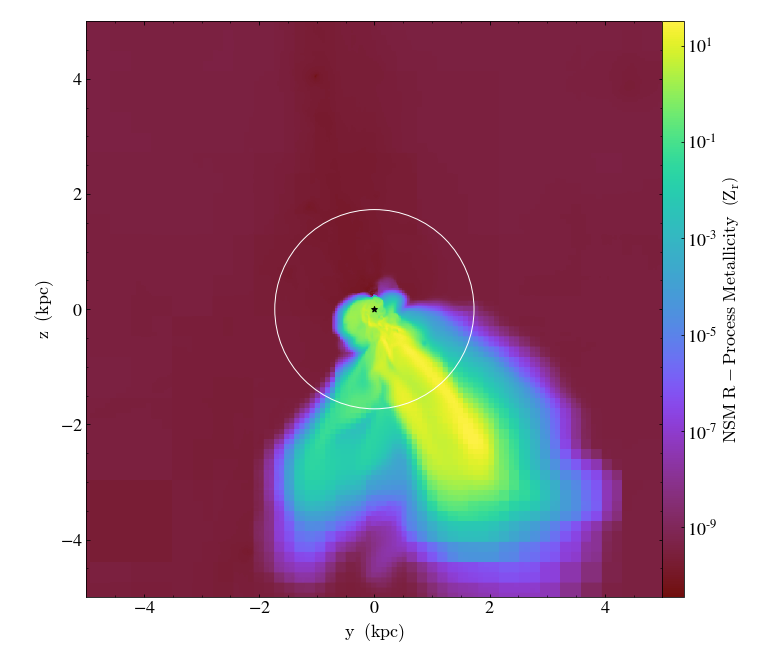

In [35]:
prj = yt.ProjectionPlot(ds, 'x', 'metallicity4', center = halo_pos, weight_field='density', width=(10, 'kpc'))
prj.annotate_sphere([0,0], halo_rvir, coord_system='plot')
prj.annotate_marker([0, 0], marker = '*', plot_args = {'color':'black'}, coord_system="plot")
#prj.save(output_images + original_output + '_matching_density.png')

In [50]:
sp.quantities.total_quantity('metallicity4')

unyt_quantity(2933279.53967546, 'Zr')

In [7]:
ds.add_particle_filter('p2')

True

In [9]:
ds.add_particle_filter('p3')

True

In [10]:
ds.derived_field_list

[('all', 'NSM_metallicity_fraction'),
 ('all', 'P2_metallicity_fraction'),
 ('all', 'P3_metallicity_fraction'),
 ('all', 'age'),
 ('all', 'creation_time'),
 ('all', 'dynamical_time'),
 ('all', 'mesh_id'),
 ('all', 'metallicity_fraction'),
 ('all', 'particle_angular_momentum'),
 ('all', 'particle_angular_momentum_magnitude'),
 ('all', 'particle_angular_momentum_x'),
 ('all', 'particle_angular_momentum_y'),
 ('all', 'particle_angular_momentum_z'),
 ('all', 'particle_cylindrical_velocity_theta'),
 ('all', 'particle_cylindrical_velocity_z'),
 ('all', 'particle_index'),
 ('all', 'particle_mass'),
 ('all', 'particle_ones'),
 ('all', 'particle_position'),
 ('all', 'particle_position_cylindrical_radius'),
 ('all', 'particle_position_cylindrical_theta'),
 ('all', 'particle_position_cylindrical_z'),
 ('all', 'particle_position_relative_x'),
 ('all', 'particle_position_relative_y'),
 ('all', 'particle_position_relative_z'),
 ('all', 'particle_position_spherical_phi'),
 ('all', 'particle_position_

In [11]:
ad = ds.all_data()

In [12]:
ad['p2', 'NSM_metallicity_fraction'].to('Zr')

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'all', 'p2', 'nbody', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p2", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)


unyt_array([4.68072026e-12, 7.40669883e-01, 1.90465719e+00,
            1.97345670e+00, 6.36653077e-01, 2.63726206e+00,
            1.89917546e+00, 2.79761101e+00, 2.33411992e+00,
            1.02125222e-11, 1.04846164e-11, 1.13653762e-11,
            2.34431394e-11, 2.10915675e-11, 2.45040789e+00,
            2.68174036e+00, 2.10688325e-12, 1.90396597e-13,
            3.04666312e+00, 1.58574152e+01, 4.02067064e+00,
            2.68528925e+00, 1.93594891e+00, 4.30120736e+00,
            2.45178201e+00, 1.40471540e+01, 1.75762237e-11,
            4.14454639e+00, 3.95499756e+00, 8.18237056e-12,
            1.00146949e+00, 1.10045881e+00, 1.53360724e+00,
            8.52373519e+00, 5.96680272e+00, 1.25676156e-11,
            3.49599109e-12, 7.39467173e-12, 5.75849984e-13], 'Zr')

In [14]:
ad['p2', 'P3_metallicity_fraction'].to('Zsun')

unyt_array([0.00132321, 0.00115647, 0.00172876, 0.00191573, 0.00050632,
            0.00345454, 0.0014078 , 0.00273925, 0.00197707, 0.00183769,
            0.00198428, 0.00191283, 0.00083901, 0.00078574, 0.00234457,
            0.00243118, 0.00024542, 0.00023636, 0.00280123, 0.00372953,
            0.00255943, 0.00247949, 0.00239276, 0.00277724, 0.00203805,
            0.00516064, 0.00234989, 0.00306365, 0.0030905 , 0.00143979,
            0.00146582, 0.00140512, 0.00148074, 0.00412963, 0.00383437,
            0.00206674, 0.0010604 , 0.00091449, 0.00085677], 'Zsun')

In [54]:
ad = ds.all_data()

ad['p2', 'NSM_metallicity_fraction'].to('Zr')

unyt_array([1.04816523e-11, 2.46804458e-11, 1.69325784e-11,
            4.57222398e-11, 3.39724815e-11, 4.09869344e-12,
            2.02691182e-11, 1.59443404e-11, 2.91892523e-12,
            2.20436629e-12, 5.45918375e-13, 7.90353568e-13,
            6.86430888e-12, 1.64195085e-11, 1.95631055e+00,
            3.31700932e-13, 2.22610447e+00, 2.73341796e-11,
            2.60550313e+01, 1.84175939e+01, 4.08590386e+00,
            1.41519609e+01, 4.90134491e+00, 4.34448297e+00,
            1.88901689e+00, 2.21965689e+00, 2.79541642e+00,
            6.20673367e-12, 7.21912917e-12, 3.92754394e-11,
            1.01694043e-11, 8.57846357e+00, 1.52260517e-11,
            1.98338522e-11, 2.58399314e-11, 3.93741546e-11,
            5.43406851e+00, 5.93644319e+00, 8.08039158e+00,
            5.03182125e-11, 4.52134462e-11, 4.02310989e-11,
            1.46153780e-12, 4.30363777e-11, 9.48061505e-13,
            1.59967916e+01, 1.00399839e-11, 1.39235848e-11,
            1.78474206e-11, 2.09487857e+

In [52]:
ds.derived_field_list

[('all', 'NSM_metallicity_fraction'),
 ('all', 'P2_metallicity_fraction'),
 ('all', 'P3_metallicity_fraction'),
 ('all', 'age'),
 ('all', 'creation_time'),
 ('all', 'dynamical_time'),
 ('all', 'mesh_id'),
 ('all', 'metallicity_fraction'),
 ('all', 'particle_angular_momentum'),
 ('all', 'particle_angular_momentum_magnitude'),
 ('all', 'particle_angular_momentum_x'),
 ('all', 'particle_angular_momentum_y'),
 ('all', 'particle_angular_momentum_z'),
 ('all', 'particle_cylindrical_velocity_theta'),
 ('all', 'particle_cylindrical_velocity_z'),
 ('all', 'particle_index'),
 ('all', 'particle_mass'),
 ('all', 'particle_ones'),
 ('all', 'particle_position'),
 ('all', 'particle_position_cylindrical_radius'),
 ('all', 'particle_position_cylindrical_theta'),
 ('all', 'particle_position_cylindrical_z'),
 ('all', 'particle_position_relative_x'),
 ('all', 'particle_position_relative_y'),
 ('all', 'particle_position_relative_z'),
 ('all', 'particle_position_spherical_phi'),
 ('all', 'particle_position_

In [48]:
### Making a movie for Laura's class

output = '/home/dskinner6/Dropbox/GaTech/GRAD/CETL_8718/PHYS_4247/Oct_13/sim_images/'

for o in matching_halo_info['run_A']:
    ds = yt.load('../run_A/DD' + o + '/output_' + o)
    hds = yt.load('../run_A/rockstar_halos/halos_DD' + o + '.0.bin')
    
    stars = ['p3', 'p2', 'p3_living']
    for s in stars:
        ds.add_particle_filter(s)
    
    ad = ds.all_data()
    halos = hds.all_data()
    
    halo_pos = ds.arr(matching_halo_info['run_A'][o]['position'], 'unitary').to('kpc')
    halo_rvir = ds.quan(matching_halo_info['run_A'][o]['rvir'], 'unitary').to('kpc')
    sp = ds.sphere(halo_pos, halo_rvir)
    
    p3_pos = sp['p3', 'particle_position'].to('kpc')
    p2_pos = sp['p2', 'particle_position'].to('kpc')
    
    #prj = yt.ProjectionPlot(ds, 'x', ('deposit', 'all_cic'), center = halo_pos, weight_field=('deposit', 'all_cic'), width=(10, 'kpc'))
    #prj.annotate_sphere([0,0], halo_rvir, coord_system='plot')
    #if len(p3_pos) > 0:
    #    for p3 in p3_pos:
    #        prj.annotate_marker(p3, marker = '*', plot_args={'color':'white'})
    #if len(p2_pos) > 0:
    #    for p2 in p3_pos:
    #        prj.annotate_marker(p2, marker = '*', plot_args={'color':'black'})
    #prj.annotate_timestamp(corner='upper_left', redshift=True, draw_inset_box=True)
    #prj.save(output + o + '_dark_matter.png', mpl_kwargs={'facecolor':'w'})
    
    if int(o) >= 38:
        prj = yt.ProjectionPlot(ds, 'x', 'metallicity4', center = halo_pos, weight_field='density', width=(10, 'kpc'))
        prj.annotate_sphere([0,0], halo_rvir, coord_system='plot')
        if len(p3_pos) > 0:
            for p3 in p3_pos:
                prj.annotate_marker(p3, marker = '*', plot_args={'color':'white'})
        if len(p2_pos) > 0:
            for p2 in p3_pos:
                prj.annotate_marker(p2, marker = '*', plot_args={'color':'black'})
        prj.annotate_timestamp(corner='upper_left', redshift=True, draw_inset_box=True)
        #prj.show()
        prj.save(output + o + '_metallicity4.png', mpl_kwargs={'facecolor':'w'})
    


yt : [INFO     ] 2022-10-11 12:31:09,429 Parameters: current_time              = 22.745089719978
yt : [INFO     ] 2022-10-11 12:31:09,433 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-11 12:31:09,433 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-11 12:31:09,434 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-11 12:31:09,435 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-11 12:31:09,435 Parameters: current_redshift          = 26.205185090537
yt : [INFO     ] 2022-10-11 12:31:09,435 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-11 12:31:09,436 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-11 12:31:09,436 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-10-11 12:31:09,436 Parameters: hubble_constant           = 0.6766
yt : [INFO     ] 2022-10-11 12:31:09,524 Parameters: current_time              = 3841422892753316.0 

yt : [INFO     ] 2022-10-11 12:31:20,135 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2022-10-11 12:31:20,136 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-11 12:31:20,137 Parameters: domain_right_edge         = [0.67659998 0.67659998 0.67659998]
yt : [INFO     ] 2022-10-11 12:31:20,137 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-11 12:31:20,137 Parameters: current_redshift          = 24.290313195739163
yt : [INFO     ] 2022-10-11 12:31:20,138 Parameters: omega_lambda              = 0.6888999938964844
yt : [INFO     ] 2022-10-11 12:31:20,138 Parameters: omega_matter              = 0.3111000061035156
yt : [INFO     ] 2022-10-11 12:31:20,138 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2022-10-11 12:31:20,138 Parameters: hubble_constant           = 0.6765999794006348
Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████

yt : [INFO     ] 2022-10-11 12:31:45,148 Parameters: current_redshift          = 20.88835557169
yt : [INFO     ] 2022-10-11 12:31:45,149 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-11 12:31:45,149 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-11 12:31:45,149 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-10-11 12:31:45,149 Parameters: hubble_constant           = 0.6766
yt : [INFO     ] 2022-10-11 12:31:45,219 Parameters: current_time              = 5322830707838883.0 s
yt : [INFO     ] 2022-10-11 12:31:45,220 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2022-10-11 12:31:45,220 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-11 12:31:45,221 Parameters: domain_right_edge         = [0.67659998 0.67659998 0.67659998]
yt : [INFO     ] 2022-10-11 12:31:45,221 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-11 12:31:45,221 Parameters: current_redshift      

yt : [INFO     ] 2022-10-11 12:31:55,853 Parameters: omega_lambda              = 0.6888999938964844
yt : [INFO     ] 2022-10-11 12:31:55,853 Parameters: omega_matter              = 0.3111000061035156
yt : [INFO     ] 2022-10-11 12:31:55,854 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2022-10-11 12:31:55,854 Parameters: hubble_constant           = 0.6765999794006348
Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:00<00:00, 19790.21it/s]
yt : [INFO     ] 2022-10-11 12:31:55,899 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-10-11 12:31:57,228 Allocating for 1.760e+02 particles
Loading particle index: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 130528.13it/s]
yt : [INFO     ] 2022-10-11 12:31:59,530 Projection completed
y

yt : [INFO     ] 2022-10-11 12:32:03,996 Projection completed
yt : [INFO     ] 2022-10-11 12:32:03,996 xlim = 20.947467 30.947467
yt : [INFO     ] 2022-10-11 12:32:03,997 ylim = 17.491765 27.491765
yt : [INFO     ] 2022-10-11 12:32:03,997 xlim = 0.427348 0.631357
yt : [INFO     ] 2022-10-11 12:32:03,998 ylim = 0.356848 0.560858
yt : [INFO     ] 2022-10-11 12:32:03,999 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:32:04,187 Saving plot /home/dskinner6/Dropbox/GaTech/GRAD/CETL_8718/PHYS_4247/Oct_13/sim_images/0039_metallicity4.png
yt : [INFO     ] 2022-10-11 12:32:04,389 Parameters: current_time              = 35.902222481214
yt : [INFO     ] 2022-10-11 12:32:04,390 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-11 12:32:04,391 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-11 12:32:04,391 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-11 12:32:

yt : [INFO     ] 2022-10-11 12:32:09,157 Projection completed
yt : [INFO     ] 2022-10-11 12:32:09,158 xlim = 21.375979 31.375979
yt : [INFO     ] 2022-10-11 12:32:09,159 ylim = 17.920999 27.920999
yt : [INFO     ] 2022-10-11 12:32:09,159 xlim = 0.428957 0.629630
yt : [INFO     ] 2022-10-11 12:32:09,160 ylim = 0.359625 0.560298
yt : [INFO     ] 2022-10-11 12:32:09,161 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:32:09,353 Saving plot /home/dskinner6/Dropbox/GaTech/GRAD/CETL_8718/PHYS_4247/Oct_13/sim_images/0040_metallicity4.png
yt : [INFO     ] 2022-10-11 12:32:09,559 Parameters: current_time              = 36.779365080144
yt : [INFO     ] 2022-10-11 12:32:09,559 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-11 12:32:09,560 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-11 12:32:09,561 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-11 12:32:

yt : [INFO     ] 2022-10-11 12:32:16,838 Projection completed
yt : [INFO     ] 2022-10-11 12:32:16,839 xlim = 21.797902 31.797902
yt : [INFO     ] 2022-10-11 12:32:16,840 ylim = 18.345251 28.345251
yt : [INFO     ] 2022-10-11 12:32:16,842 xlim = 0.430441 0.627910
yt : [INFO     ] 2022-10-11 12:32:16,843 ylim = 0.362262 0.559731
yt : [INFO     ] 2022-10-11 12:32:16,844 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:32:17,053 Saving plot /home/dskinner6/Dropbox/GaTech/GRAD/CETL_8718/PHYS_4247/Oct_13/sim_images/0041_metallicity4.png
yt : [INFO     ] 2022-10-11 12:32:17,247 Parameters: current_time              = 37.656507247322
yt : [INFO     ] 2022-10-11 12:32:17,248 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-11 12:32:17,249 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-11 12:32:17,249 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-11 12:32:

yt : [INFO     ] 2022-10-11 12:32:26,582 Projection completed
yt : [INFO     ] 2022-10-11 12:32:26,584 xlim = 22.209409 32.209409
yt : [INFO     ] 2022-10-11 12:32:26,585 ylim = 18.742370 28.742370
yt : [INFO     ] 2022-10-11 12:32:26,587 xlim = 0.431729 0.626119
yt : [INFO     ] 2022-10-11 12:32:26,587 ylim = 0.364333 0.558723
yt : [INFO     ] 2022-10-11 12:32:26,589 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:32:26,806 Saving plot /home/dskinner6/Dropbox/GaTech/GRAD/CETL_8718/PHYS_4247/Oct_13/sim_images/0042_metallicity4.png
yt : [INFO     ] 2022-10-11 12:32:27,004 Parameters: current_time              = 38.533641182594
yt : [INFO     ] 2022-10-11 12:32:27,004 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-11 12:32:27,005 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-11 12:32:27,006 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-11 12:32:

yt : [INFO     ] 2022-10-11 12:32:37,038 Projection completed
yt : [INFO     ] 2022-10-11 12:32:37,040 xlim = 22.608734 32.608734
yt : [INFO     ] 2022-10-11 12:32:37,040 ylim = 19.128980 29.128980
yt : [INFO     ] 2022-10-11 12:32:37,042 xlim = 0.432796 0.624224
yt : [INFO     ] 2022-10-11 12:32:37,042 ylim = 0.366183 0.557612
yt : [INFO     ] 2022-10-11 12:32:37,044 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:32:37,256 Saving plot /home/dskinner6/Dropbox/GaTech/GRAD/CETL_8718/PHYS_4247/Oct_13/sim_images/0043_metallicity4.png
yt : [INFO     ] 2022-10-11 12:32:37,456 Parameters: current_time              = 39.410784698242
yt : [INFO     ] 2022-10-11 12:32:37,457 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-11 12:32:37,457 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-11 12:32:37,458 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-11 12:32:

yt : [INFO     ] 2022-10-11 12:32:47,200 Projection completed
yt : [INFO     ] 2022-10-11 12:32:47,201 xlim = 23.026178 33.026178
yt : [INFO     ] 2022-10-11 12:32:47,202 ylim = 19.547892 29.547892
yt : [INFO     ] 2022-10-11 12:32:47,203 xlim = 0.434221 0.622799
yt : [INFO     ] 2022-10-11 12:32:47,204 ylim = 0.368629 0.557206
yt : [INFO     ] 2022-10-11 12:32:47,207 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:32:47,419 Saving plot /home/dskinner6/Dropbox/GaTech/GRAD/CETL_8718/PHYS_4247/Oct_13/sim_images/0044_metallicity4.png
yt : [INFO     ] 2022-10-11 12:32:47,618 Parameters: current_time              = 40.287926326965
yt : [INFO     ] 2022-10-11 12:32:47,619 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-11 12:32:47,620 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-11 12:32:47,620 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-11 12:32:

yt : [INFO     ] 2022-10-11 12:32:57,898 Projection completed
yt : [INFO     ] 2022-10-11 12:32:57,899 xlim = 23.414295 33.414295
yt : [INFO     ] 2022-10-11 12:32:57,899 ylim = 19.944231 29.944231
yt : [INFO     ] 2022-10-11 12:32:57,900 xlim = 0.435108 0.620937
yt : [INFO     ] 2022-10-11 12:32:57,901 ylim = 0.370623 0.556453
yt : [INFO     ] 2022-10-11 12:32:57,903 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:32:58,118 Saving plot /home/dskinner6/Dropbox/GaTech/GRAD/CETL_8718/PHYS_4247/Oct_13/sim_images/0045_metallicity4.png
yt : [INFO     ] 2022-10-11 12:32:58,321 Parameters: current_time              = 41.165056935338
yt : [INFO     ] 2022-10-11 12:32:58,321 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-11 12:32:58,322 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-11 12:32:58,322 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-11 12:32:

yt : [INFO     ] 2022-10-11 12:33:09,412 Projection completed
yt : [INFO     ] 2022-10-11 12:33:09,414 xlim = 23.809948 33.809948
yt : [INFO     ] 2022-10-11 12:33:09,414 ylim = 20.350203 30.350203
yt : [INFO     ] 2022-10-11 12:33:09,415 xlim = 0.436151 0.619332
yt : [INFO     ] 2022-10-11 12:33:09,416 ylim = 0.372776 0.555956
yt : [INFO     ] 2022-10-11 12:33:09,418 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:33:09,633 Saving plot /home/dskinner6/Dropbox/GaTech/GRAD/CETL_8718/PHYS_4247/Oct_13/sim_images/0046_metallicity4.png
yt : [INFO     ] 2022-10-11 12:33:09,836 Parameters: current_time              = 42.042198519707
yt : [INFO     ] 2022-10-11 12:33:09,836 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-11 12:33:09,837 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-11 12:33:09,837 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-11 12:33:

yt : [INFO     ] 2022-10-11 12:33:20,610 Projection completed
yt : [INFO     ] 2022-10-11 12:33:20,611 xlim = 24.206358 34.206358
yt : [INFO     ] 2022-10-11 12:33:20,612 ylim = 20.754910 30.754910
yt : [INFO     ] 2022-10-11 12:33:20,613 xlim = 0.437223 0.617846
yt : [INFO     ] 2022-10-11 12:33:20,613 ylim = 0.374882 0.555505
yt : [INFO     ] 2022-10-11 12:33:20,615 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:33:20,833 Saving plot /home/dskinner6/Dropbox/GaTech/GRAD/CETL_8718/PHYS_4247/Oct_13/sim_images/0047_metallicity4.png
yt : [INFO     ] 2022-10-11 12:33:21,029 Parameters: current_time              = 42.919317688765
yt : [INFO     ] 2022-10-11 12:33:21,029 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-11 12:33:21,030 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-11 12:33:21,031 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-11 12:33:

yt : [INFO     ] 2022-10-11 12:33:31,466 Projection completed
yt : [INFO     ] 2022-10-11 12:33:31,468 xlim = 24.598779 34.598779
yt : [INFO     ] 2022-10-11 12:33:31,468 ylim = 21.160882 31.160882
yt : [INFO     ] 2022-10-11 12:33:31,470 xlim = 0.438236 0.616390
yt : [INFO     ] 2022-10-11 12:33:31,470 ylim = 0.376989 0.555142
yt : [INFO     ] 2022-10-11 12:33:31,472 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:33:31,691 Saving plot /home/dskinner6/Dropbox/GaTech/GRAD/CETL_8718/PHYS_4247/Oct_13/sim_images/0048_metallicity4.png
yt : [INFO     ] 2022-10-11 12:33:31,890 Parameters: current_time              = 43.796501703069
yt : [INFO     ] 2022-10-11 12:33:31,891 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-11 12:33:31,892 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-11 12:33:31,892 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-11 12:33:

yt : [INFO     ] 2022-10-11 12:33:42,615 Projection completed
yt : [INFO     ] 2022-10-11 12:33:42,616 xlim = 24.982266 34.982266
yt : [INFO     ] 2022-10-11 12:33:42,617 ylim = 21.564948 31.564948
yt : [INFO     ] 2022-10-11 12:33:42,618 xlim = 0.439105 0.614871
yt : [INFO     ] 2022-10-11 12:33:42,618 ylim = 0.379040 0.554806
yt : [INFO     ] 2022-10-11 12:33:42,620 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:33:43,539 Saving plot /home/dskinner6/Dropbox/GaTech/GRAD/CETL_8718/PHYS_4247/Oct_13/sim_images/0049_metallicity4.png
yt : [INFO     ] 2022-10-11 12:33:43,743 Parameters: current_time              = 44.673632439356
yt : [INFO     ] 2022-10-11 12:33:43,744 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-11 12:33:43,745 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-11 12:33:43,745 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-11 12:33:

yt : [INFO     ] 2022-10-11 12:33:54,612 Projection completed
yt : [INFO     ] 2022-10-11 12:33:54,613 xlim = 25.347228 35.347228
yt : [INFO     ] 2022-10-11 12:33:54,614 ylim = 21.971336 31.971336
yt : [INFO     ] 2022-10-11 12:33:54,615 xlim = 0.439668 0.613126
yt : [INFO     ] 2022-10-11 12:33:54,615 ylim = 0.381110 0.554568
yt : [INFO     ] 2022-10-11 12:33:54,617 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:33:54,856 Saving plot /home/dskinner6/Dropbox/GaTech/GRAD/CETL_8718/PHYS_4247/Oct_13/sim_images/0050_metallicity4.png
yt : [INFO     ] 2022-10-11 12:33:55,061 Parameters: current_time              = 45.550757219002
yt : [INFO     ] 2022-10-11 12:33:55,062 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-11 12:33:55,063 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-11 12:33:55,063 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-11 12:33:

yt : [INFO     ] 2022-10-11 12:34:05,346 Projection completed
yt : [INFO     ] 2022-10-11 12:34:05,347 xlim = 25.708697 35.708697
yt : [INFO     ] 2022-10-11 12:34:05,348 ylim = 22.389746 32.389746
yt : [INFO     ] 2022-10-11 12:34:05,349 xlim = 0.440194 0.611417
yt : [INFO     ] 2022-10-11 12:34:05,350 ylim = 0.383365 0.554589
yt : [INFO     ] 2022-10-11 12:34:05,352 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:34:05,573 Saving plot /home/dskinner6/Dropbox/GaTech/GRAD/CETL_8718/PHYS_4247/Oct_13/sim_images/0051_metallicity4.png
yt : [INFO     ] 2022-10-11 12:34:05,774 Parameters: current_time              = 46.42791015271
yt : [INFO     ] 2022-10-11 12:34:05,774 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-11 12:34:05,775 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-11 12:34:05,776 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-11 12:34:0

yt : [INFO     ] 2022-10-11 12:34:15,729 Projection completed
yt : [INFO     ] 2022-10-11 12:34:15,730 xlim = 26.053646 36.053646
yt : [INFO     ] 2022-10-11 12:34:15,731 ylim = 22.745547 32.745547
yt : [INFO     ] 2022-10-11 12:34:15,732 xlim = 0.440463 0.609523
yt : [INFO     ] 2022-10-11 12:34:15,732 ylim = 0.384536 0.553596
yt : [INFO     ] 2022-10-11 12:34:15,734 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:34:15,947 Saving plot /home/dskinner6/Dropbox/GaTech/GRAD/CETL_8718/PHYS_4247/Oct_13/sim_images/0052_metallicity4.png
yt : [INFO     ] 2022-10-11 12:34:16,143 Parameters: current_time              = 47.305048003957
yt : [INFO     ] 2022-10-11 12:34:16,144 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-11 12:34:16,145 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-11 12:34:16,145 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-11 12:34:

yt : [INFO     ] 2022-10-11 12:34:27,648 Projection completed
yt : [INFO     ] 2022-10-11 12:34:27,649 xlim = 26.443605 36.443605
yt : [INFO     ] 2022-10-11 12:34:27,650 ylim = 23.147962 33.147962
yt : [INFO     ] 2022-10-11 12:34:27,650 xlim = 0.441511 0.608474
yt : [INFO     ] 2022-10-11 12:34:27,651 ylim = 0.386486 0.553449
yt : [INFO     ] 2022-10-11 12:34:27,653 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:34:27,874 Saving plot /home/dskinner6/Dropbox/GaTech/GRAD/CETL_8718/PHYS_4247/Oct_13/sim_images/0053_metallicity4.png
yt : [INFO     ] 2022-10-11 12:34:28,075 Parameters: current_time              = 48.182188956268
yt : [INFO     ] 2022-10-11 12:34:28,076 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-11 12:34:28,076 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-11 12:34:28,077 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-11 12:34:

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p2", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-10-11 12:34:38,671 Projection completed
yt : [INFO     ] 2022-10-11 12:34:38,672 xlim = 26.798009 36.798009
yt : [INFO     ] 2022-10-11 12:34:38,673 ylim = 23.592579 33.592579
yt : [INFO     ] 2022-10-11 12:34:38,674 xlim = 0.441981 0.606911
yt : [INFO     ] 2022-10-11 12:34:38,674 ylim = 0.389113 0.554044
yt : [INFO     ] 2022-10-11 12:34:38,677 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:34:38

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p2", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-10-11 12:34:49,665 Projection completed
yt : [INFO     ] 2022-10-11 12:34:49,666 xlim = 27.160155 37.160155
yt : [INFO     ] 2022-10-11 12:34:49,667 ylim = 24.057420 34.057420
yt : [INFO     ] 2022-10-11 12:34:49,668 xlim = 0.442597 0.605555
yt : [INFO     ] 2022-10-11 12:34:49,668 ylim = 0.392036 0.554994
yt : [INFO     ] 2022-10-11 12:34:49,670 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:34:49

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p2", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-10-11 12:35:01,966 Projection completed
yt : [INFO     ] 2022-10-11 12:35:01,967 xlim = 27.509382 37.509382
yt : [INFO     ] 2022-10-11 12:35:01,967 ylim = 24.376190 34.376190
yt : [INFO     ] 2022-10-11 12:35:01,968 xlim = 0.443022 0.604066
yt : [INFO     ] 2022-10-11 12:35:01,968 ylim = 0.392564 0.553608
yt : [INFO     ] 2022-10-11 12:35:01,970 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:35:02

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p2", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-10-11 12:35:13,396 Projection completed
yt : [INFO     ] 2022-10-11 12:35:13,397 xlim = 27.860245 37.860245
yt : [INFO     ] 2022-10-11 12:35:13,398 ylim = 24.774028 34.774028
yt : [INFO     ] 2022-10-11 12:35:13,399 xlim = 0.443493 0.602679
yt : [INFO     ] 2022-10-11 12:35:13,399 ylim = 0.394366 0.553551
yt : [INFO     ] 2022-10-11 12:35:13,401 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:35:13

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p2", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-10-11 12:35:24,533 Projection completed
yt : [INFO     ] 2022-10-11 12:35:24,534 xlim = 28.209233 38.209233
yt : [INFO     ] 2022-10-11 12:35:24,535 ylim = 25.167415 35.167415
yt : [INFO     ] 2022-10-11 12:35:24,536 xlim = 0.443953 0.601332
yt : [INFO     ] 2022-10-11 12:35:24,536 ylim = 0.396082 0.553460
yt : [INFO     ] 2022-10-11 12:35:24,538 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:35:24

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p2", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-10-11 12:35:36,049 Projection completed
yt : [INFO     ] 2022-10-11 12:35:36,050 xlim = 28.563041 38.563041
yt : [INFO     ] 2022-10-11 12:35:36,051 ylim = 25.540089 35.540089
yt : [INFO     ] 2022-10-11 12:35:36,052 xlim = 0.444506 0.600129
yt : [INFO     ] 2022-10-11 12:35:36,052 ylim = 0.397462 0.553085
yt : [INFO     ] 2022-10-11 12:35:36,054 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:35:36

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p2", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-10-11 12:35:47,285 Projection completed
yt : [INFO     ] 2022-10-11 12:35:47,286 xlim = 28.914311 38.914311
yt : [INFO     ] 2022-10-11 12:35:47,287 ylim = 25.910634 35.910634
yt : [INFO     ] 2022-10-11 12:35:47,288 xlim = 0.445035 0.598950
yt : [INFO     ] 2022-10-11 12:35:47,288 ylim = 0.398804 0.552719
yt : [INFO     ] 2022-10-11 12:35:47,290 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:35:47

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p2", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-10-11 12:35:58,466 Projection completed
yt : [INFO     ] 2022-10-11 12:35:58,467 xlim = 29.260169 39.260169
yt : [INFO     ] 2022-10-11 12:35:58,468 ylim = 26.284860 36.284860
yt : [INFO     ] 2022-10-11 12:35:58,469 xlim = 0.445496 0.597750
yt : [INFO     ] 2022-10-11 12:35:58,469 ylim = 0.400196 0.552449
yt : [INFO     ] 2022-10-11 12:35:58,471 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:35:58

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p2", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-10-11 12:36:10,699 Projection completed
yt : [INFO     ] 2022-10-11 12:36:10,700 xlim = 29.591753 39.591753
yt : [INFO     ] 2022-10-11 12:36:10,701 ylim = 26.666920 36.666920
yt : [INFO     ] 2022-10-11 12:36:10,702 xlim = 0.445758 0.596394
yt : [INFO     ] 2022-10-11 12:36:10,702 ylim = 0.401699 0.552335
yt : [INFO     ] 2022-10-11 12:36:10,704 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:36:10

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p2", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-10-11 12:36:22,505 Projection completed
yt : [INFO     ] 2022-10-11 12:36:22,506 xlim = 29.917665 39.917665
yt : [INFO     ] 2022-10-11 12:36:22,506 ylim = 27.029339 37.029339
yt : [INFO     ] 2022-10-11 12:36:22,507 xlim = 0.445955 0.595015
yt : [INFO     ] 2022-10-11 12:36:22,508 ylim = 0.402901 0.551962
yt : [INFO     ] 2022-10-11 12:36:22,509 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:36:22

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p2", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-10-11 12:36:33,885 Projection completed
yt : [INFO     ] 2022-10-11 12:36:33,886 xlim = 30.251872 40.251872
yt : [INFO     ] 2022-10-11 12:36:33,887 ylim = 27.413650 37.413650
yt : [INFO     ] 2022-10-11 12:36:33,888 xlim = 0.446293 0.593819
yt : [INFO     ] 2022-10-11 12:36:33,888 ylim = 0.404422 0.551948
yt : [INFO     ] 2022-10-11 12:36:33,890 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:36:34

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p2", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-10-11 12:36:46,197 Projection completed
yt : [INFO     ] 2022-10-11 12:36:46,198 xlim = 30.599824 40.599824
yt : [INFO     ] 2022-10-11 12:36:46,198 ylim = 27.798310 37.798310
yt : [INFO     ] 2022-10-11 12:36:46,199 xlim = 0.446849 0.592879
yt : [INFO     ] 2022-10-11 12:36:46,200 ylim = 0.405939 0.551969
yt : [INFO     ] 2022-10-11 12:36:46,202 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:36:46

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p2", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-10-11 12:36:57,739 Projection completed
yt : [INFO     ] 2022-10-11 12:36:57,740 xlim = 30.740196 40.740196
yt : [INFO     ] 2022-10-11 12:36:57,740 ylim = 28.023903 38.023903
yt : [INFO     ] 2022-10-11 12:36:57,742 xlim = 0.444415 0.588987
yt : [INFO     ] 2022-10-11 12:36:57,743 ylim = 0.405146 0.549717
yt : [INFO     ] 2022-10-11 12:36:57,744 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:36:57

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p2", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-10-11 12:37:09,520 Projection completed
yt : [INFO     ] 2022-10-11 12:37:09,521 xlim = 31.279176 41.279176
yt : [INFO     ] 2022-10-11 12:37:09,521 ylim = 28.526592 38.526592
yt : [INFO     ] 2022-10-11 12:37:09,522 xlim = 0.447758 0.590906
yt : [INFO     ] 2022-10-11 12:37:09,523 ylim = 0.408355 0.551503
yt : [INFO     ] 2022-10-11 12:37:09,524 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:37:09

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p2", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-10-11 12:37:21,628 Projection completed
yt : [INFO     ] 2022-10-11 12:37:21,629 xlim = 31.606287 41.606287
yt : [INFO     ] 2022-10-11 12:37:21,629 ylim = 28.910155 38.910155
yt : [INFO     ] 2022-10-11 12:37:21,630 xlim = 0.448053 0.589813
yt : [INFO     ] 2022-10-11 12:37:21,630 ylim = 0.409832 0.551593
yt : [INFO     ] 2022-10-11 12:37:21,631 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:37:21

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p2", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-10-11 12:37:33,013 Projection completed
yt : [INFO     ] 2022-10-11 12:37:33,013 xlim = 31.923793 41.923793
yt : [INFO     ] 2022-10-11 12:37:33,014 ylim = 29.290065 39.290065
yt : [INFO     ] 2022-10-11 12:37:33,014 xlim = 0.448228 0.588633
yt : [INFO     ] 2022-10-11 12:37:33,015 ylim = 0.411249 0.551654
yt : [INFO     ] 2022-10-11 12:37:33,016 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:37:33

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p2", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
yt : [INFO     ] 2022-10-11 12:37:44,115 Projection completed
yt : [INFO     ] 2022-10-11 12:37:44,116 xlim = 32.215548 42.215548
yt : [INFO     ] 2022-10-11 12:37:44,117 ylim = 29.657713 39.657713
yt : [INFO     ] 2022-10-11 12:37:44,117 xlim = 0.448061 0.587144
yt : [INFO     ] 2022-10-11 12:37:44,117 ylim = 0.412487 0.551569
yt : [INFO     ] 2022-10-11 12:37:44,119 Making a fixed resolution buffer of (('gas', 'metallicity4')) 800 by 800
yt : [INFO     ] 2022-10-11 12:37:44

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'creation_time' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "creation_time")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("p3", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_mass' is ambiguous and corresponds to any one of the following field types:
 {'p2', 'all', 'nbody', 'p3_living', 'p3'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_mass")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


In [20]:
hds_original = yt.load('../run_original/rockstar_halos/halos_DD0030.0.bin')
hds = yt.load('../run_A/rockstar_halos/halos_DD0030.0.bin')

halos_original = hds_original.all_data()
halos = hds.all_data()

yt : [INFO     ] 2022-10-06 16:05:59,715 Parameters: current_time              = 4582124722631928.0 s
yt : [INFO     ] 2022-10-06 16:05:59,716 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2022-10-06 16:05:59,717 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-06 16:05:59,717 Parameters: domain_right_edge         = [0.67659998 0.67659998 0.67659998]
yt : [INFO     ] 2022-10-06 16:05:59,718 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-06 16:05:59,718 Parameters: current_redshift          = 23.187978846784077
yt : [INFO     ] 2022-10-06 16:05:59,718 Parameters: omega_lambda              = 0.6888999938964844
yt : [INFO     ] 2022-10-06 16:05:59,718 Parameters: omega_matter              = 0.3111000061035156
yt : [INFO     ] 2022-10-06 16:05:59,719 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2022-10-06 16:05:59,719 Parameters: hubble_constant           = 0.6765999794006348
yt : [INFO     ] 2022-10-06 16:05

In [22]:
halos_original['particle_position']

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_position' is ambiguous and corresponds to any one of the following field types:
 {'nbody', 'all'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_position")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)


unyt_array([[0.31608769, 0.33834752, 0.32915315],
            [0.25988996, 0.24899577, 0.230922  ],
            [0.3086392 , 0.33435729, 0.3383339 ],
            [0.31493214, 0.32521552, 0.34338644],
            [0.33902594, 0.38620934, 0.32660663],
            [0.33182976, 0.36043981, 0.30622414],
            [0.33629417, 0.36171478, 0.31008893],
            [0.33958781, 0.36818811, 0.31143805],
            [0.32501575, 0.36110523, 0.25028887],
            [0.31453568, 0.3513048 , 0.31182718],
            [0.26838899, 0.35461524, 0.2375955 ],
            [0.33503222, 0.39277321, 0.33200788],
            [0.30797371, 0.35300484, 0.34684476],
            [0.30995333, 0.35940993, 0.35060832],
            [0.43101031, 0.25116175, 0.23070104],
            [0.41666219, 0.34919077, 0.24153194],
            [0.41518116, 0.44575617, 0.23319757],
            [0.37159523, 0.35298055, 0.34359717],
            [0.37353235, 0.35310709, 0.34557062],
            [0.37304479, 0.35345528, 0.34998757],


In [23]:
halos['particle_position']

unyt_array([[0.25981724, 0.2486611 , 0.23061228],
            [0.3054263 , 0.25498503, 0.23231487],
            [0.31411052, 0.33693525, 0.33219716],
            [0.31635472, 0.3386181 , 0.32878968],
            [0.41684663, 0.34900159, 0.24103507],
            [0.41518882, 0.44573072, 0.23302324],
            [0.41515046, 0.445768  , 0.23495324],
            [0.39694402, 0.44752082, 0.23430017],
            [0.36157078, 0.36682427, 0.30094802],
            [0.37336382, 0.35321653, 0.34605116],
            [0.37282106, 0.35325214, 0.34211811],
            [0.3724139 , 0.35309556, 0.34361792],
            [0.37274906, 0.35240644, 0.35861313],
            [0.37508807, 0.358899  , 0.35068783],
            [0.37922493, 0.35929021, 0.35519654],
            [0.38042802, 0.35947886, 0.35775498],
            [0.37096226, 0.35791463, 0.36201125],
            [0.37149179, 0.3580271 , 0.36460653],
            [0.37220791, 0.35824794, 0.36565042],
            [0.3746407 , 0.35950407, 0.36718535],


In [156]:
matching_halo_info

{'run_A': {'0025': {'halo_id': 6,
   'position': unyt_array([0.50118238, 0.57598287, 0.48202777], dtype=float32, units='unitary'),
   'mass': unyt_quantity(49630.504, dtype=float32, units='Msun'),
   'rvir': unyt_quantity(0.00118977, dtype=float32, units='unitary')},
  '0026': {'halo_id': 9,
   'position': unyt_array([0.50090158, 0.57521427, 0.4826633 ], dtype=float32, units='unitary'),
   'mass': unyt_quantity(79396.984, dtype=float32, units='Msun'),
   'rvir': unyt_quantity(0.00139226, dtype=float32, units='unitary')},
  '0027': {'halo_id': 12,
   'position': unyt_array([0.50100499, 0.57412058, 0.48250073], dtype=float32, units='unitary'),
   'mass': unyt_quantity(87333.73, dtype=float32, units='Msun'),
   'rvir': unyt_quantity(0.00143659, dtype=float32, units='unitary')},
  '0028': {'halo_id': 17,
   'position': unyt_array([0.49110258, 0.53149569, 0.45211351], dtype=float32, units='unitary'),
   'mass': unyt_quantity(138944.72, dtype=float32, units='Msun'),
   'rvir': unyt_quantity(

In [140]:
original_output = matching_ds['run_A'][-1][0]
matching_output = matching_ds['run_A'][-1][1]
matching_redshift = DD_data['run_A'][matching_output]['redshift']

target_halo = massive_prog[original_output]['halo_id']
target_mass = massive_prog[original_output]['mass']
target_position = massive_prog[original_output]['position']
target_rvir = massive_prog[original_output]['rvir']

a = ytree.load('../run_A' + '/rockstar_halos/trees/tree_0_0_0.dat')
b = ytree.load('../run_original' + '/rockstar_halos/trees/tree_0_0_0.dat')

In [146]:
delta = 0.05
original_output

'0125'

In [147]:
criteria = "(tree['tree', 'redshift'] > " + str(matching_redshift - delta) + ") & (tree['tree', 'redshift'] < " + str(matching_redshift + delta) + ')'
    
print(criteria)

(tree['tree', 'redshift'] > 11.093943136353) & (tree['tree', 'redshift'] < 11.193943136353)


In [148]:
halos_original = list(b.select_halos(criteria))

Selecting halos (found 203): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 522.35it/s]


In [99]:
## Check to see if we found the matching halo in the original tree:
original_positions = []
original_masses = []
original_ids = []
for halo in halos_original:
    original_positions.append(halo['position'].to('unitary'))
    original_masses.append(halo['mass'])
    original_ids.append(halo['halo_id'])
    
dr_position = np.sqrt(((np.array(original_positions) - target_position)**2).sum(1))
dr_mass = np.abs(np.array(original_masses) - target_mass)

min_pos_index = np.argwhere(dr_position == np.min(dr_position))[0][0]
min_mass_index = np.argwhere(dr_mass == np.min(dr_mass))[0][0]

if min_pos_index == min_mass_index:
    print('Found the matching halo! Halo ID #' + str(original_ids[min_pos_index]))
    original_redshift = halos_original[min_pos_index]['redshift']
    print(original_redshift)
else:
    print('Cant find matching halo in original tree...')
    print('Must refine criteria.')

Found the matching halo! Halo ID #3
26.203484


In [102]:
halos = list(a.select_halos("(tree['tree', 'redshift'] == " + str(original_redshift) + ')'))


Selecting halos (found 21): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 826.16it/s]


In [133]:
positions = []
masses = []
ids = []
for halo in halos:
    positions.append(halo['position'].to('unitary'))
    masses.append(halo['mass'])
    ids.append(halo['halo_id'])

dr_position = np.sqrt(((np.array(positions) - target_position)**2).sum(1))
dr_mass = np.abs(np.array(masses) - target_mass)

min_pos_index = np.argwhere(dr_position == np.min(dr_position))[0][0]
min_mass_index = [i[0] for i in np.argwhere(dr_mass == np.min(dr_mass))]

if min_pos_index in min_mass_index:
    print('Found the matching halo! Halo ID #' + str(ids[min_pos_index]))
    redshift = halos[min_pos_index]['redshift']
    print(redshift)
else:
    print('Cant find matching halo in original tree...')
    print('Choosing closest halo that is of the same order mass')
    order_mass = int("{:e}".format(target_mass).split('e+')[1])
    mass_criteria  = (np.array(masses) > 10**(order_mass)) & (np.array(masses) < 9*10**(order_mass))

    index = np.argwhere(dr_position == np.min(dr_position))[0][0]
    
    run_position = positions[index]
    run_mass = masses[index]
    run_id = ids[index]

Cant find matching halo in original tree...
Choosing closest halo that is of the same order mass


In [120]:
[i[0] for i in np.argwhere(dr_mass == np.min(dr_mass))]

[5, 14]

In [52]:
positions = []
masses = []
ids = []
for halo in halos:
    positions.append(halo['position'].to('unitary'))
    masses.append(halo['mass'])
    ids.append(halo['halo_id'])

In [68]:
dr_position = np.sqrt(((np.array(positions) - target_position)**2).sum(1))
dr_mass = np.abs(np.array(masses) - target_mass)

In [69]:
np.argwhere(dr_position == np.min(dr_position))

array([[4]])

In [70]:
np.argwhere(dr_mass == np.min(dr_mass))

array([[ 5],
       [14]])

In [77]:
print('Original position = ', target_position)
print('Matched position = ', positions[4])

Original position =  [0.5009754300117493, 0.5763375759124756, 0.48253029584884644]
Matched position =  [0.5011824  0.57598287 0.48202777] unitary


In [78]:
print('Original mass = ' + str(target_mass))
print('Matched mass = ' + str(masses[4]))

Original mass = 61528.23046875
Matched mass = 49630.504 Msun


In [86]:
ids[4]

6

In [47]:
[DD_data['run_original'][i[0]]['redshift'] for i in temp]

[19.748838461229, 19.900897685591]

In [45]:
DD_data['run_original']

{'0000': {'time': 4.369889293125582, 'redshift': 249},
 '0002': {'time': 13.758638303994367, 'redshift': 115.37794923487},
 '0003': {'time': 18.453009782383162, 'redshift': 94.692132050604},
 '0004': {'time': 23.147397943200815, 'redshift': 81.272160867619},
 '0005': {'time': 27.841793315125376, 'redshift': 71.742714386919},
 '0006': {'time': 32.53616155572589, 'redshift': 64.565697547761},
 '0007': {'time': 37.23055260165262, 'redshift': 58.931407425166},
 '0008': {'time': 41.92496567970632, 'redshift': 54.369704113801},
 '0009': {'time': 46.619400045454285, 'redshift': 50.58729499523},
 '0010': {'time': 51.31374284518717, 'redshift': 47.39099946049},
 '0011': {'time': 56.00820907733894, 'redshift': 44.647720100363},
 '0012': {'time': 60.70256316506435, 'redshift': 42.26287127522},
 '0013': {'time': 65.39691726491183, 'redshift': 40.166913021692},
 '0014': {'time': 70.09127136490918, 'redshift': 38.30764015379},
 '0015': {'time': 74.78579034126518, 'redshift': 36.64494199988},
 '0016'

In [27]:
ds = yt.load('../run_B/DD0067/output_0067')

yt : [INFO     ] 2022-10-20 09:34:15,938 Parameters: current_time              = 59.585025538692
yt : [INFO     ] 2022-10-20 09:34:15,939 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-20 09:34:15,940 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-20 09:34:15,940 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-20 09:34:15,941 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-10-20 09:34:15,941 Parameters: current_redshift          = 13.314876573963
yt : [INFO     ] 2022-10-20 09:34:15,941 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2022-10-20 09:34:15,941 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2022-10-20 09:34:15,942 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-10-20 09:34:15,942 Parameters: hubble_constant           = 0.6766


In [28]:
ds.add_particle_filter('p3')
ds.add_particle_filter('p2')

Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 954/954 [00:00<00:00, 21437.46it/s]
yt : [INFO     ] 2022-10-20 09:34:16,657 Gathering a field list (this may take a moment.)


True

In [29]:
ad = ds.all_data()

In [30]:
ad

YTRegion (output_0067): , center=[1.077787e+23 1.077787e+23 1.077787e+23] cm cm, left_edge=[0. 0. 0.] cm cm, right_edge=[2.155574e+23 2.155574e+23 2.155574e+23] cm cm

In [31]:
ad['all', 'particle_type']

TypeError: 'NoneType' object is not subscriptable

In [10]:
ad['density']

unyt_array([8.72314569e-28, 8.78878609e-28, 9.84621938e-28, ...,
            1.21340584e-26, 1.33613013e-26, 1.35448770e-26], 'g/cm**3')

In [11]:
ad['particle_type']

/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'particle_type' is ambiguous and corresponds to any one of the following field types:
 {'all', 'nbody'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "particle_type")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)


TypeError: 'NoneType' object is not subscriptable